In [1]:
import tensorflow as tf
import pandas as pd
import requests
import shutil
import matplotlib
from matplotlib import image
from matplotlib import pyplot
from PIL import Image, ImageColor
import numpy as np
import urllib
from sklearn.model_selection import train_test_split
import cv2
from sklearn.cluster import KMeans
import webcolors
from webcolors import rgb_to_name
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split

In [2]:
path = '/Users/anaghabalaji/Desktop/approved_products.csv'

In [3]:
df = pd.read_csv(path, names = ['name', 'tags', 'image_url'], skiprows = [0, 1])

In [4]:
def convert_tag(tag):
    split_tag = tag.split(',')
    intermediate = []
    for item in split_tag:
        removed = item.replace('"', "")
        removed_3 = removed.replace('{', '')
        removed_4 = removed_3.replace('}', '')
        intermediate.append(removed_4)
    return intermediate

In [5]:
df['tags'] = df['tags'].apply(convert_tag)

In [6]:
df.index.name = "index"

In [7]:
def get_flowers(index):
    tags = df.loc[index].at['tags']
    flowers = []
    for feature in tags:
        if 'flower_' in feature:
            string2 = feature.replace("flower_", "")
            flowers.append(string2)
    return flowers

In [8]:
flower_col = []
for row in range(len(df)):
    flowers = get_flowers(row)
    flower_col.append(flowers)

In [9]:
df['flowers'] = flower_col

In [10]:
def get_colors(index):
    tags = df.loc[index].at['tags']
    colors = []
    for feature in tags:
        if 'color' in feature:
            string = feature.replace("color_", "")
            colors.append(string)
    return colors

In [11]:
color_col = []
for row in range(len(df)):
    colors = get_colors(row)
    color_col.append(colors)

In [12]:
df['colors'] = color_col

In [13]:
import os

_, _, files = next(os.walk('/Users/anaghabalaji/Desktop/flower_images/'))
file_count = len(files)

In [14]:
array_data = []
for i in range(1, file_count - 1):
    if i != 97:
        img = Image.open('/Users/anaghabalaji/Desktop/flower_images/image-' + str(i) + '.jpg')
        array = np.asarray(img)
        array_data.append(array)

In [15]:
array_data = np.asarray(array_data)

/var/folders/sc/g0x9kgp11qv7yvdsbkhqm9tr0000gn/T/ipykernel_2408/1319265687.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array_data = np.asarray(array_data)


In [16]:
train_data, test_data = train_test_split(array_data, test_size = .20, 
                                         train_size = .80, shuffle = True)

In [17]:
def get_pie_chart(index):
    img = cv2.imread('/Users/anaghabalaji/Desktop/flower_images/image-' + str(index) + '.jpg')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    pyplot.imshow(img)
    pyplot.show()
    img=img.reshape((img.shape[1]*img.shape[0],3))
    kmeans=KMeans(n_clusters=10)
    s=kmeans.fit(img)
    labels=kmeans.labels_
    labels=list(labels)
    centroid=kmeans.cluster_centers_
    percent=[]
    for i in range(len(centroid)):
      j=labels.count(i)
      j=j/(len(labels))
      percent.append(j)
    pyplot.pie(percent,colors=np.array(centroid/255),labels=np.arange(len(centroid)))
    pyplot.show()

In [18]:
def bounding_rect(index):
    image = cv2.imread('/Users/anaghabalaji/Desktop/flower_images/image-' + str(index) + '.jpg')
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    ROI_number = 0
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    max_w = 0
    max_h = 0
    x_save = 0
    y_save = 0
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if (w * h) > (max_h * max_w):
            max_w = w
            max_h = h
            x_save = x
            y_save = y
    cv2.rectangle(image, (x_save, y_save), (x_save + max_w, y_save + max_h), (0,0,255), 2)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    specs = [x_save, y_save, max_w, max_h]
    pyplot.imshow(image)
    pyplot.show()
    return specs

In [19]:
def crop_image(index, x, y, w, h):
    img = cv2.imread('/Users/anaghabalaji/Desktop/flower_images/image-' + str(index) + '.jpg')
    crop = img[y:y+h, x:x+w]
    crop=cv2.cvtColor(crop,cv2.COLOR_BGR2RGB)
    return crop

In [20]:
def get_color_name(rgb_triplet):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - rgb_triplet[0]) ** 2
        gd = (g_c - rgb_triplet[1]) ** 2
        bd = (b_c - rgb_triplet[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

In [21]:
def get_pie_chart(index):
    img = cv2.imread('/Users/anaghabalaji/Desktop/flower_images/image-' + str(index) + '.jpg')
    x, y, w, h = bounding_rect(index)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = crop_image(index, x, y, w, h)
    pyplot.imshow(img)
    pyplot.show()
    img=img.reshape((img.shape[1]*img.shape[0],3))
    kmeans=KMeans(n_clusters=15)
    s=kmeans.fit(img)
    labels=kmeans.labels_
    labels=list(labels)
    centroid=kmeans.cluster_centers_
    percent=[]
    for i in range(len(centroid)):
      j=labels.count(i)
      j=j/(len(labels))
      percent.append(j)
    pyplot.pie(percent,colors=np.array(centroid/255),labels=np.arange(len(centroid)))
    pyplot.show()
    colors_webcolors = dict()
    centroid = centroid.tolist()
    key = 0
    for color in centroid:
        color_name = get_color_name(color)
        colors_webcolors[key] = color_name
        key+=1
    for row in colors_webcolors:
        print(str(row), ' --> ', colors_webcolors[row])

In [22]:
def convert_coco(yolo_coordinates):
    coco_coordinates = []
    for box in yolo_coordinates:
        x_yolo = box[0]
        y_yolo = box[1]
        w = box[2]
        h = box[3]
    
        width_coco = w * 200
        height_coco = h * 200
        x_coco = (x_yolo * 200) - (width_coco/2)
        y_coco = (y_yolo * 200) - (height_coco/2)
        width_coco = int(width_coco)
        height_coco = int(height_coco)
        x_coco = int(x_coco)
        y_coco = int(y_coco)
    
        coco_coordinates.append([x_coco, y_coco, width_coco, height_coco])
    return coco_coordinates

In [23]:
def modify(x):
    x = float(x)
    return x

def bb_labeled(index):
    yolo_coordinates = []
    file = open("/Users/anaghabalaji/Desktop/bounding_box/image-" + str(index) + ".txt", "r")
    for line in file:
        lst = line.split(" ")
        lst.pop(0)
        lst = [modify(i) for i in lst]
        yolo_coordinates.append(lst)
    
    
    coco_coordinates = convert_coco(yolo_coordinates)
    image = cv2.imread('/Users/anaghabalaji/Desktop/flower_images/image-' + str(index) + '.jpg')
    for box in coco_coordinates:
        x_coco = box[0]
        y_coco = box[1]
        width_coco = box[2]
        height_coco = box[3]
        cv2.rectangle(image,(x_coco,y_coco),(x_coco+width_coco,y_coco+height_coco),(0,255,0),2)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    pyplot.imshow(image)
    pyplot.show()


In [24]:
def color_wheel(img, index):
    img=img.reshape((img.shape[1]*img.shape[0],3))
    kmeans=KMeans(n_clusters=15)
    s=kmeans.fit(img)
    labels=kmeans.labels_
    labels=list(labels)
    centroid=kmeans.cluster_centers_
    percent=[]
    for i in range(len(centroid)):
      j=labels.count(i)
      j=j/(len(labels))
      percent.append(j)
    pyplot.pie(percent,colors=np.array(centroid/255),labels=np.arange(len(centroid)))
    pyplot.show()
    colors_webcolors = dict()
    centroid = centroid.tolist()
    key = 0
    for color in centroid:
        color_name = get_color_name(color)
        colors_webcolors[key] = color_name
        key+=1
    colors = []
    for row in colors_webcolors:
        colors.append(colors_webcolors[row])
    return colors

In [25]:
def color_wheel_no_display(img, index):
    img=img.reshape((img.shape[1]*img.shape[0],3))
    kmeans=KMeans(n_clusters=5)
    s=kmeans.fit(img)
    labels=kmeans.labels_
    labels=list(labels)
    centroid=kmeans.cluster_centers_
    percent=[]
    for i in range(len(centroid)):
      j=labels.count(i)
      j=j/(len(labels))
      percent.append(j)
    colors_webcolors = dict()
    centroid = centroid.tolist()
    key = 0
    for color in centroid:
        color_name = get_color_name(color)
        colors_webcolors[key] = color_name
        key+=1
    colors = []
    for row in colors_webcolors:
        colors.append(colors_webcolors[row])
    return colors

In [26]:
def pie_labeled(index):
    yolo_coordinates = []
    file = open("/Users/anaghabalaji/Desktop/bounding_box/image-" + str(index) + ".txt", "r")
    for line in file:
        lst = line.split(" ")
        lst.pop(0)
        lst = [modify(i) for i in lst]
        yolo_coordinates.append(lst)
    
    
    coco_coordinates = convert_coco(yolo_coordinates)
    img = cv2.imread('/Users/anaghabalaji/Desktop/flower_images/image-' + str(index) + '.jpg')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    pyplot.imshow(img)
    pyplot.show()
    all_colors = set()
    for box in coco_coordinates:
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        img = crop_image(index, x, y, w, h)
        pyplot.imshow(img)
        pyplot.show()
        colors = color_wheel(img, index)
        for color in colors:
            all_colors.add(color)

In [27]:
def colors_percent(img):
    img=img.reshape((img.shape[1]*img.shape[0],3))
    kmeans=KMeans(n_clusters=15)
    s=kmeans.fit(img)
    labels=kmeans.labels_
    labels=list(labels)
    centroid=kmeans.cluster_centers_
    percent=[]
    for i in range(len(centroid)):
      j=labels.count(i)
      j=j/(len(labels))
      percent.append(j)
    colors_webcolors = dict()
    key = 0
    for color in centroid:
        color_name = get_color_name(color)
        colors_webcolors[key] = color_name
        key+=1
    colors = dict()
    for row in colors_webcolors:
        colors[colors_webcolors[row]] = percent[row]
    return colors

In [28]:
def colors_in_crop(index):
    yolo_coordinates = []
    file = open("/Users/anaghabalaji/Desktop/bounding_box/image-" + str(index) + ".txt", "r")
    #path = "/Users/anaghabalaji/Desktop/bounding_box/image-" + str(index) + ".txt", "r"
    for line in file:
        lst = line.split(" ")
        lst.pop(0)
        lst = [modify(i) for i in lst]
        yolo_coordinates.append(lst)
    
    
    coco_coordinates = convert_coco(yolo_coordinates)
    path = '/Users/anaghabalaji/Desktop/flower_images/image-' + str(index) + '.jpg'
    img = cv2.imread('/Users/anaghabalaji/Desktop/flower_images/image-' + str(index) + '.jpg')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    all_colors = set()
    percent_dict = dict()
    try:
        for box in coco_coordinates:
            #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            x = box[0]
            y = box[1]
            w = box[2]
            h = box[3]
            img = crop_image(index, x, y, w, h)
            colors = colors_percent(img)
            for color in colors:
                all_colors.add(color)
            for color in colors:
                if color not in percent_dict:
                    percent_dict[color] = colors[color]
                else: 
                    percent = colors[color]
                    add = percent_dict.get(color)
                    percent_dict[color] = percent + add  
    except:
        print("Error")
    return percent_dict

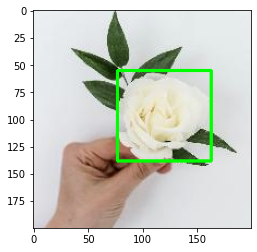

In [29]:
bb_labeled(1)

In [30]:
colors_in_crop(8)

{'lightgray': 0.2545068928950159,
 'firebrick': 0.019971721456344998,
 'rosybrown': 0.05514316012725345,
 'peru': 0.03048780487804878,
 'darkolivegreen': 0.015553199010250972,
 'darkslategray': 0.00857193354542241,
 'silver': 0.15120183810533758,
 'gainsboro': 0.17037822552138565,
 'tan': 0.09367267585719335,
 'sandybrown': 0.03799929303640862,
 'gray': 0.026422764227642278,
 'darksalmon': 0.04480381760339343,
 'chocolate': 0.024301873453517146,
 'burlywood': 0.05629197596323789,
 'maroon': 0.010692824319547543}

In [31]:
colors_in_crop(2)

{'black': 0.16543442210587117,
 'darkgray': 0.09702994279751812,
 'darkslategray': 0.14889135254988914,
 'lightgray': 0.18061637071680114,
 'gray': 0.11987460172539083,
 'beige': 0.04025974025974026,
 'dimgray': 0.12234809666660455,
 'gainsboro': 0.14689951368574036,
 'silver': 0.13730831578751235,
 'darkolivegreen': 0.06038961038961039,
 'linen': 0.04878048780487805}

In [32]:
colors_in_crop(5)

{'gainsboro': 0.19527186761229315,
 'gray': 0.01619385342789598,
 'whitesmoke': 0.08309692671394799,
 'silver': 0.03877068557919622,
 'darkgray': 0.030260047281323876,
 'darkslategray': 0.0009456264775413711,
 'dimgray': 0.01099290780141844,
 'linen': 0.09267139479905437,
 'lightgray': 0.06382978723404255,
 'snow': 0.1132387706855792}

In [33]:
"""colors_web = dict()
for i in range(0, file_count):
    print(i)
    try:
        colors = colors_in_crop(i)
        colors_web[i] = colors
    except:
        print("error")"""

'colors_web = dict()\nfor i in range(0, file_count):\n    print(i)\n    try:\n        colors = colors_in_crop(i)\n        colors_web[i] = colors\n    except:\n        print("error")'

In [34]:
#colors_web

In [35]:
colors_web = {0: {'maroon': 0.042257259648564,
  'lightgray': 0.12597547380156077,
  'rosybrown': 0.07495885756755322,
  'indianred': 0.0608908000212348,
  'saddlebrown': 0.020385411689759516,
  'lightpink': 0.09927270796836014,
  'peachpuff': 0.07708233795190317,
  'darksalmon': 0.08047990656686309,
  'black': 0.03694855868768912,
  'lightcoral': 0.06858841641450338,
  'sienna': 0.03540903540903541,
  'brown': 0.05186600838774752,
  'gainsboro': 0.12889525933004195},
 1: {'tan': 0.014569907537125245,
  'antiquewhite': 0.14976183804987392,
  'darkslategray': 0.026197814513869433,
  'lightgray': 0.0949845895208742,
  'indianred': 0.016671336508826,
  'palegoldenrod': 0.031101148781171196,
  'darkolivegreen': 0.026478005043429533,
  'silver': 0.04230876996357523,
  'gainsboro': 0.23129728215186326,
  'saddlebrown': 0.014149621742785093,
  'darkgray': 0.011207621182404036,
  'wheat': 0.09372373213785375,
  'gray': 0.00658447744466237},
 2: {'darkslategray': 0.16190910954182117,
  'silver': 0.12526132404181184,
  'black': 0.1419031470681399,
  'gray': 0.11756786971995006,
  'gainsboro': 0.15323836851813896,
  'dimgray': 0.11037563584191992,
  'lightgray': 0.19080195271013062,
  'darkolivegreen': 0.06363636363636363,
  'darkgray': 0.11586111162868695,
  'beige': 0.04025974025974026,
  'linen': 0.04949784791965567},
 3: {'burlywood': 0.18853771500830324,
  'saddlebrown': 0.07574767280649633,
  'gray': 0.169051754345872,
  'black': 0.14107972637384403,
  'tan': 0.15223425811661107,
  'dimgray': 0.12264195499489618,
  'sienna': 0.09594664594664595,
  'darkkhaki': 0.0855119825708061,
  'darkslategray': 0.04520697167755991,
  'lightgray': 0.06263616557734204,
  'darkolivegreen': 0.07574081691728751,
  'darksalmon': 0.11040343099166629,
  'blanchedalmond': 0.08951048951048951,
  'peru': 0.03776223776223776,
  'rosybrown': 0.11328671328671329,
  'wheat': 0.12937062937062938},
 4: {'darkolivegreen': 0.1839455782312925,
  'darksalmon': 0.014285714285714285,
  'gray': 0.15965986394557824,
  'lightgray': 0.24750364431486882,
  'black': 0.13294460641399417,
  'darkgreen': 0.1419047619047619,
  'silver': 0.20430879494655005,
  'dimgray': 0.10962099125364431,
  'papayawhip': 0.025714285714285714,
  'tan': 0.12309523809523809,
  'rosybrown': 0.08555879494655005,
  'gainsboro': 0.3491010689990282,
  'darkseagreen': 0.10649902818270165,
  'darkgray': 0.11302842565597668,
  'darkslategray': 0.04956268221574344,
  'olivedrab': 0.0625,
  'darkkhaki': 0.08541666666666667,
  'palegoldenrod': 0.04583333333333333},
 5: {'linen': 0.09267139479905437,
  'darkgray': 0.021631205673758865,
  'gainsboro': 0.19527186761229315,
  'gray': 0.01619385342789598,
  'lightgray': 0.06134751773049645,
  'snow': 0.1132387706855792,
  'dimgray': 0.01099290780141844,
  'darkslategray': 0.0009456264775413711,
  'whitesmoke': 0.08309692671394799,
  'silver': 0.04018912529550828},
 6: {'maroon': 0.057285746760627414,
  'gray': 0.07069788588315526,
  'black': 0.11548079108888384,
  'darkolivegreen': 0.05660377358490566,
  'silver': 0.0550125028415549,
  'sienna': 0.03887247101614003,
  'rosybrown': 0.03523528074562401,
  'dimgray': 0.06387815412593771,
  'darkslategray': 0.11025233007501704,
  'darkgray': 0.069561263923619,
  'lightgray': 0.031370766083200725},
 7: {'tan': 0.45969693600072786,
  'darkslategray': 0.09616213444190759,
  'rosybrown': 0.331352419526555,
  'black': 0.17858922339629557,
  'wheat': 0.09262759924385633,
  'dimgray': 0.09438729722283598,
  'darkgray': 0.24310332599557555,
  'silver': 0.368239013540915,
  'gray': 0.19722927035281088,
  'darkolivegreen': 0.08912776315200423,
  'gainsboro': 0.270223922759228,
  'lightgray': 0.439841694253459,
  'antiquewhite': 0.0748663101604278,
  'linen': 0.058823529411764705,
  'bisque': 0.08888888888888889},
 8: {'wheat': 0.05708731000353482,
  'peru': 0.03243195475433015,
  'darkolivegreen': 0.014581124072110286,
  'gainsboro': 0.18195475433015199,
  'burlywood': 0.04436196535878402,
  'silver': 0.14360197949805584,
  'rosybrown': 0.05213856486390951,
  'maroon': 0.010692824319547543,
  'lightgray': 0.2540650406504065,
  'chocolate': 0.024655355249204668,
  'gray': 0.02518557794273595,
  'tan': 0.09217037822552139,
  'sandybrown': 0.03782255213856486,
  'darkslategray': 0.008483563096500531,
  'firebrick': 0.02076705549664192},
 9: {'gray': 0.01335428122545169,
  'peachpuff': 0.23068866195339094,
  'darkolivegreen': 0.018853102906520033,
  'lightpink': 0.10631055250065462,
  'maroon': 0.014925373134328358,
  'darksalmon': 0.037182508510081175,
  'linen': 0.03744435716156062,
  'tan': 0.057083006022518985,
  'antiquewhite': 0.1953390940036659,
  'black': 0.03273108143493061,
  'wheat': 0.12621105001309244,
  'sienna': 0.021209740769835034,
  'burlywood': 0.04556166535742341,
  'indianred': 0.028279654359780047},
 10: {'wheat': 0.10847137460040686,
  'maroon': 0.03102295844231328,
  'peru': 0.0531095611740773,
  'linen': 0.16129032258064516,
  'rosybrown': 0.07824760244115082,
  'black': 0.06429816913687882,
  'burlywood': 0.08754722464399883,
  'chocolate': 0.03080499854693403,
  'gainsboro': 0.12489102005231037,
  'saddlebrown': 0.03632664922987504,
  'gray': 0.03414705027608254,
  'sandybrown': 0.034655623365300786,
  'tan': 0.06262714327230456,
  'darkslategray': 0.043010752688172046,
  'darkolivegreen': 0.04954954954954955},
 11: {'tan': 0.06415006947660955,
  'darkslategray': 0.02053419793114096,
  'bisque': 0.1232823838196696,
  'rosybrown': 0.04932839277443261,
  'saddlebrown': 0.02354485101127065,
  'black': 0.03898409757603829,
  'linen': 0.0866913694611703,
  'sienna': 0.02346765477844681,
  'lightgray': 0.10398332561371006,
  'wheat': 0.03967886367145283,
  'silver': 0.0725644588544079,
  'indianred': 0.02393083217538984,
  'gainsboro': 0.14698162729658792},
 12: {'peachpuff': 0.0939060939060939,
  'darkolivegreen': 0.035339660339660336,
  'rosybrown': 0.05844155844155844,
  'sienna': 0.029845154845154844,
  'black': 0.03496503496503497,
  'silver': 0.06630869130869131,
  'lightgray': 0.11925574425574426,
  'linen': 0.09652847152847154,
  'burlywood': 0.05244755244755245,
  'wheat': 0.07842157842157842,
  'gray': 0.037212787212787216,
  'antiquewhite': 0.1580919080919081},
 13: {'gray': 0.02578361981799798,
  'burlywood': 0.0872093023255814,
  'black': 0.02249747219413549,
  'bisque': 0.15470171890798787,
  'rosybrown': 0.03968655207280081,
  'darkolivegreen': 0.02199191102123357,
  'wheat': 0.15647118301314458,
  'chocolate': 0.0358948432760364,
  'tan': 0.06319514661274014,
  'linen': 0.08746208291203236,
  'peru': 0.047522750252780584,
  'saddlebrown': 0.014408493427704751,
  'darksalmon': 0.07633973710819009},
 14: {'darkslategray': 0.07347781217750259,
  'silver': 0.06996904024767801,
  'gray': 0.04066047471620227,
  'black': 0.08875128998968008,
  'dimgray': 0.05201238390092879,
  'antiquewhite': 0.07698658410732714,
  'darkgray': 0.05779153766769866,
  'oldlace': 0.047265221878224975,
  'darkolivegreen': 0.05696594427244582,
  'darkseagreen': 0.05345717234262126,
  'lightgray': 0.07574819401444788},
 15: {'darkgreen': 0.07696759259259259,
  'darkkhaki': 0.05555555555555555,
  'gainsboro': 0.08058449074074074,
  'dimgray': 0.055844907407407406,
  'darkolivegreen': 0.040219907407407406,
  'black': 0.0853587962962963,
  'linen': 0.04152199074074074,
  'tan': 0.07016782407407407,
  'wheat': 0.09056712962962964,
  'silver': 0.08058449074074074},
 16: {'rosybrown': 0.10219368646334938,
  'darkolivegreen': 0.02514713750668807,
  'tan': 0.0821294810058855,
  'sienna': 0.06674692348849652,
  'navajowhite': 0.08386837881219904,
  'darksalmon': 0.05604601391118245,
  'saddlebrown': 0.06005885500267523,
  'peru': 0.0563135366506153,
  'pink': 0.12586944890315677,
  'olivedrab': 0.026886035313001606,
  'indianred': 0.09189406099518459,
  'darkkhaki': 0.021401819154628143,
  'maroon': 0.05898876404494382,
  'mistyrose': 0.08761369716425896,
  'chocolate': 0.05484216158373462},
 17: {'wheat': 0.17154720279720279,
  'darkolivegreen': 0.06545017482517483,
  'rosybrown': 0.07408216783216784,
  'black': 0.060205419580419584,
  'sienna': 0.047312062937062936,
  'indianred': 0.04807692307692308,
  'darkgoldenrod': 0.041520979020979024,
  'darkkhaki': 0.03190559440559441,
  'saddlebrown': 0.06293706293706294,
  'goldenrod': 0.022618006993006992,
  'tan': 0.12139423076923077,
  'antiquewhite': 0.08435314685314685,
  'peru': 0.06501311188811189,
  'darksalmon': 0.07167832167832168},
 18: {'antiquewhite': 0.08108108108108109,
  'sienna': 0.05328185328185328,
  'black': 0.04382239382239382,
  'rosybrown': 0.0886100386100386,
  'tan': 0.11081081081081082,
  'darkolivegreen': 0.043243243243243246,
  'dimgray': 0.044015444015444015,
  'peru': 0.07413127413127413,
  'saddlebrown': 0.033204633204633204,
  'darksalmon': 0.055598455598455596,
  'lightgray': 0.10888030888030888,
  'silver': 0.07837837837837838},
 19: {'lightgray': 0.10657894736842105,
  'dimgray': 0.049210526315789475,
  'black': 0.06763157894736842,
  'burlywood': 0.06815789473684211,
  'peru': 0.07,
  'wheat': 0.06605263157894736,
  'tan': 0.08407894736842106,
  'darkolivegreen': 0.0431578947368421,
  'silver': 0.10328947368421053,
  'saddlebrown': 0.021710526315789475,
  'darkkhaki': 0.06671052631578947,
  'antiquewhite': 0.08171052631578947},
 20: {'black': 0.0666967780788919,
  'silver': 0.0603733815115929,
  'dimgray': 0.06413730803974707,
  'darkslategray': 0.07889190003011141,
  'darkseagreen': 0.06007226738934056,
  'gainsboro': 0.04817825956037338,
  'darkolivegreen': 0.07377295995182175,
  'darkgray': 0.0608250526949714,
  'gray': 0.06202950918398073,
  'lightgray': 0.06202950918398073},
 21: {'darkslategray': 0.10229885057471265,
  'darkgray': 0.02375478927203065,
  'black': 0.11877394636015326,
  'dimgray': 0.04980842911877394,
  'gainsboro': 0.027586206896551724,
  'gray': 0.03524904214559387,
  'lightgray': 0.04099616858237548,
  'darkolivegreen': 0.06053639846743295,
  'silver': 0.01800766283524904},
 22: {'gainsboro': 0.10259433962264151,
  'darkslategray': 0.029874213836477988,
  'tan': 0.0660377358490566,
  'black': 0.07625786163522012,
  'gray': 0.031446540880503145,
  'silver': 0.09198113207547169,
  'beige': 0.1281446540880503,
  'saddlebrown': 0.02397798742138365,
  'rosybrown': 0.029874213836477988,
  'lightgray': 0.09984276729559749,
  'darkkhaki': 0.02240566037735849,
  'dimgray': 0.03459119496855346},
 23: {'lightpink': 0.06451612903225806,
  'dimgray': 0.06304985337243402,
  'burlywood': 0.05249266862170088,
  'darkolivegreen': 0.09269895843866924,
  'gray': 0.12184750733137831,
  'lightgray': 0.09530791788856305,
  'black': 0.13995095560724036,
  'tan': 0.1919380119324502,
  'saddlebrown': 0.02346041055718475,
  'rosybrown': 0.07859237536656892,
  'peru': 0.06993713553780295,
  'bisque': 0.06510263929618769,
  'darksalmon': 0.10297300030336737,
  'darkkhaki': 0.0603448275862069,
  'wheat': 0.11379310344827587,
  'navajowhite': 0.07471264367816093,
  'sienna': 0.052298850574712646,
  'antiquewhite': 0.09971264367816092},
 24: {'darkolivegreen': 0.055130784708249496,
  'silver': 0.0823608316566063,
  'sienna': 0.015157612340710933,
  'black': 0.09067739771965123,
  'peachpuff': 0.08249496981891348,
  'peru': 0.022401073105298458,
  'rosybrown': 0.06519114688128773,
  'antiquewhite': 0.1062374245472837,
  'lightgray': 0.09322602280348759,
  'gray': 0.06277665995975855,
  'burlywood': 0.03420523138832998,
  'tan': 0.07431254191817573},
 25: {'rosybrown': 0.04331357048748353,
  'darkolivegreen': 0.057971014492753624,
  'linen': 0.10721343873517787,
  'dimgray': 0.05928853754940711,
  'pink': 0.08926218708827405,
  'darkgoldenrod': 0.0630764163372859,
  'black': 0.09519104084321475,
  'saddlebrown': 0.048748353096179184,
  'tan': 0.05665349143610013,
  'wheat': 0.08547430830039526,
  'darkkhaki': 0.05764163372859025,
  'burlywood': 0.03771409749670619,
  'goldenrod': 0.046442687747035576},
 26: {'darkolivegreen': 0.07719087635054021,
  'burlywood': 0.0546218487394958,
  'gray': 0.058823529411764705,
  'darkgoldenrod': 0.030732292917166868,
  'black': 0.12388955582232893,
  'beige': 0.051860744297719086,
  'darkkhaki': 0.04561824729891957,
  'goldenrod': 0.037695078031212484,
  'saddlebrown': 0.04873949579831933,
  'sienna': 0.047298919567827134,
  'wheat': 0.050900360144057626,
  'darksalmon': 0.04777911164465786,
  'maroon': 0.048499399759903965},
 27: {'sandybrown': 0.052298850574712646,
  'dimgray': 0.06695402298850575,
  'antiquewhite': 0.08975095785440614,
  'chocolate': 0.0617816091954023,
  'saddlebrown': 0.030363984674329502,
  'gray': 0.07528735632183908,
  'black': 0.07279693486590039,
  'wheat': 0.08017241379310344,
  'coral': 0.08323754789272031,
  'tan': 0.08754789272030651,
  'darkolivegreen': 0.07576628352490422,
  'yellowgreen': 0.033045977011494254},
 28: {'rosybrown': 0.08983957219251337,
  'black': 0.06242100145843461,
  'wheat': 0.11366067087992222,
  'darkolivegreen': 0.06271268838113758,
  'gray': 0.06494895478852698,
  'burlywood': 0.032863393291200776,
  'darkkhaki': 0.0636849781234808,
  'antiquewhite': 0.0699076324744774,
  'silver': 0.10753524550315995,
  'dimgray': 0.03140495867768595,
  'navajowhite': 0.042683519688867286},
 29: {'gainsboro': 0.10679824561403509,
  'darkslategray': 0.0525219298245614,
  'darkgray': 0.06589912280701754,
  'black': 0.08026315789473684,
  'olivedrab': 0.03475877192982456,
  'silver': 0.0824561403508772,
  'lightgray': 0.11907894736842105,
  'gray': 0.052083333333333336,
  'darkolivegreen': 0.06469298245614036,
  'tan': 0.048793859649122806,
  'linen': 0.06633771929824561,
  'darkkhaki': 0.05712719298245614,
  'dimgray': 0.05087719298245614},
 30: {'darkkhaki': 0.0605421686746988,
  'silver': 0.1213855421686747,
  'darkolivegreen': 0.056626506024096385,
  'olivedrab': 0.03734939759036145,
  'beige': 0.09186746987951808,
  'black': 0.03072289156626506,
  'gray': 0.06897590361445784,
  'darkgreen': 0.05677710843373494,
  'darkseagreen': 0.04503012048192771,
  'gainsboro': 0.10843373493975904,
  'tan': 0.0858433734939759},
 31: {'burlywood': 0.03576723498888065,
  'darkolivegreen': 0.06838398813936249,
  'linen': 0.11397331356560415,
  'gray': 0.06616011860637509,
  'antiquewhite': 0.13213491475166791,
  'black': 0.03224610822831727,
  'tan': 0.08506300963676798,
  'dimgray': 0.058747220163083765,
  'darkkhaki': 0.06449221645663454,
  'lightgray': 0.10044477390659748,
  'wheat': 0.04558932542624166,
  'rosybrown': 0.038917716827279465,
  'olivedrab': 0.03762045959970348},
 32: {'saddlebrown': 0.024991322457480043,
  'gainsboro': 0.1391877820201319,
  'goldenrod': 0.04425546685178757,
  'tan': 0.05275945852134675,
  'darkolivegreen': 0.011801457827143353,
  'darkgoldenrod': 0.046511627906976744,
  'linen': 0.17389795209996528,
  'darkkhaki': 0.026900381811870877,
  'wheat': 0.101874349184311,
  'black': 0.022908712252690037,
  'khaki': 0.029850746268656716,
  'peru': 0.029850746268656716,
  'antiquewhite': 0.22162443595973622,
  'sandybrown': 0.030024297119055885},
 33: {'olivedrab': 0.036178107606679034,
  'palegoldenrod': 0.09276437847866419,
  'darkkhaki': 0.050556586270871985,
  'black': 0.0027829313543599257,
  'beige': 0.04406307977736549,
  'darkolivegreen': 0.022727272727272728,
  'tan': 0.07096474953617811,
  'blanchedalmond': 0.09879406307977737,
  'gray': 0.04359925788497217,
  'wheat': 0.16001855287569575,
  'burlywood': 0.11688311688311688},
 34: {'antiquewhite': 0.23633156966490299,
  'darkolivegreen': 0.0427689594356261,
  'rosybrown': 0.041005291005291,
  'dimgray': 0.029982363315696647,
  'tan': 0.06106701940035273,
  'black': 0.025793650793650792,
  'linen': 0.04828042328042328,
  'silver': 0.07517636684303351,
  'gray': 0.035493827160493825,
  'darkgray': 0.05202821869488536,
  'gainsboro': 0.0822310405643739,
  'darkslategray': 0.03130511463844797,
  'lightgray': 0.09237213403880071},
 35: {'wheat': 0.08813077469793888,
  'dimgray': 0.0021321961620469083,
  'darkgray': 0.009772565742714996,
  'burlywood': 0.03642501776830135,
  'gainsboro': 0.1298862828713575,
  'antiquewhite': 0.20593461265103055,
  'darkslategray': 0.01261549395877754,
  'peru': 0.007818052594171997,
  'tan': 0.018656716417910446,
  'silver': 0.035181236673773986,
  'beige': 0.1865671641791045,
  'lightgray': 0.059168443496801705,
  'bisque': 0.08386638237384506,
  'black': 0.009950248756218905},
 36: {'silver': 0.13082417582417583,
  'gainsboro': 0.13857142857142857,
  'antiquewhite': 0.09714285714285714,
  'wheat': 0.03857142857142857,
  'lightgray': 0.07,
  'tan': 0.1332967032967033,
  'blanchedalmond': 0.03571428571428571,
  'peru': 0.07371794871794872,
  'sienna': 0.07692307692307693,
  'burlywood': 0.05128205128205128,
  'rosybrown': 0.05128205128205128,
  'saddlebrown': 0.019230769230769232,
  'sandybrown': 0.07371794871794872,
  'darkolivegreen': 0.019230769230769232,
  'pink': 0.08333333333333333},
 37: {'burlywood': 0.13872650846794887,
  'saddlebrown': 0.13856073380744072,
  'darkslategray': 0.040633120718166785,
  'silver': 0.1276697583171561,
  'darksalmon': 0.17571665974241796,
  'wheat': 0.17407004708640922,
  'black': 0.06969845035971434,
  'rosybrown': 0.1391375158831438,
  'gray': 0.04653909756673754,
  'maroon': 0.03354594849988188,
  'antiquewhite': 0.21569331766231897,
  'tan': 0.14189956757978206,
  'sienna': 0.15516793339687351,
  'darkolivegreen': 0.022915190172454525,
  'peru': 0.1753891835088834,
  'gainsboro': 0.11055900621118013,
  'darkgray': 0.11809809381023774,
  'darkkhaki': 0.07950310559006211,
  'bisque': 0.0968944099378882,
  'lightgray': 0.02608695652173913,
  'peachpuff': 0.039655172413793106,
  'navajowhite': 0.05862068965517241,
  'dimgray': 0.01896551724137931},
 38: {'darkseagreen': 0.07664609053497942,
  'bisque': 0.1183127572016461,
  'burlywood': 0.053497942386831275,
  'darkkhaki': 0.018261316872427984,
  'dimgray': 0.05941358024691358,
  'silver': 0.05092592592592592,
  'darkgoldenrod': 0.01646090534979424,
  'darkgray': 0.07098765432098765,
  'antiquewhite': 0.15097736625514405,
  'wheat': 0.06867283950617284,
  'gray': 0.09953703703703703,
  'linen': 0.06610082304526749,
  'lightgray': 0.102880658436214,
  'goldenrod': 0.013631687242798354},
 39: {'burlywood': 0.089828634604754,
  'darkolivegreen': 0.04560530679933665,
  'gray': 0.06025428413488115,
  'linen': 0.08568269762299613,
  'black': 0.03178551686014373,
  'darkkhaki': 0.05113322277501382,
  'wheat': 0.07683803206191266,
  'dimgray': 0.07822001105583196,
  'tan': 0.09839690436705362,
  'blanchedalmond': 0.1025428413488115},
 40: {'black': 0.2624362244897959,
  'lightgray': 0.007334183673469388,
  'dimgray': 0.02391581632653061,
  'darkolivegreen': 0.038584183673469385,
  'rosybrown': 0.006696428571428571,
  'snow': 0.0389030612244898,
  'darkslategray': 0.04878826530612245,
  'maroon': 0.020089285714285716},
 41: {'black': 0.03260099220411056,
  'silver': 0.10087408457358847,
  'dimgray': 0.04275927238365226,
  'antiquewhite': 0.09449562957713206,
  'gray': 0.06307583274273565,
  'darkolivegreen': 0.040396881644223954,
  'lightgray': 0.10489014883061658,
  'rosybrown': 0.07512402551381998,
  'oldlace': 0.04677533664068037,
  'gainsboro': 0.10016536735175999,
  'tan': 0.07559650366170564},
 42: {'gainsboro': 0.09351432880844646,
  'sienna': 0.053695324283559574,
  'black': 0.0579185520361991,
  'darkolivegreen': 0.08265460030165912,
  'darkkhaki': 0.030165912518853696,
  'gray': 0.0473604826546003,
  'lavender': 0.1248868778280543,
  'darkgray': 0.017194570135746608,
  'olivedrab': 0.051583710407239816,
  'lightgray': 0.03800904977375565},
 43: {'black': 0.2872427958285839,
  'gray': 0.15575395333876416,
  'darkslategray': 0.25738325614075996,
  'peachpuff': 0.035303776683087026,
  'dimgray': 0.15720125655906753,
  'peru': 0.019704433497536946,
  'darkseagreen': 0.0926035247269367,
  'saddlebrown': 0.020525451559934318,
  'burlywood': 0.009852216748768473,
  'silver': 0.033424409830943407,
  'darkgray': 0.03441295546558704,
  'slategray': 0.04412955465587044,
  'seagreen': 0.05384615384615385,
  'darkolivegreen': 0.07692307692307693},
 44: {'black': 0.10175438596491228,
  'gray': 0.03245614035087719,
  'darkolivegreen': 0.09707602339181287,
  'darkgray': 0.02675438596491228,
  'dimgray': 0.05804093567251462,
  'darkslategray': 0.03084795321637427,
  'wheat': 0.01476608187134503},
 45: {'lightgray': 0.13070776255707764,
  'darkolivegreen': 0.025684931506849314,
  'rosybrown': 0.05955098934550989,
  'lightcoral': 0.048515981735159815,
  'silver': 0.14726027397260275,
  'gray': 0.04794520547945205,
  'brown': 0.028538812785388126,
  'lightpink': 0.07382039573820395,
  'maroon': 0.018645357686453576,
  'tan': 0.1449771689497717,
  'black': 0.02987062404870624,
  'indianred': 0.043949771689497714},
 46: {'darkslategray': 0.07366071428571429,
  'gray': 0.08056006493506493,
  'black': 0.11607142857142858,
  'gainsboro': 0.01461038961038961,
  'darkolivegreen': 0.024350649350649352,
  'darkkhaki': 0.016639610389610388,
  'dimgray': 0.09659090909090909,
  'silver': 0.016639610389610388,
  'darkseagreen': 0.044439935064935064},
 47: {'tan': 0.31297237076648843,
  'dimgray': 0.06138591800356506,
  'silver': 0.3732365673542144,
  'gray': 0.07916666666666666,
  'gainsboro': 0.26764833206009675,
  'darkolivegreen': 0.023809523809523808,
  'darkkhaki': 0.03571428571428571,
  'lightgray': 0.7480284485335635,
  'olivedrab': 0.03273809523809524,
  'wheat': 0.3727244217845241,
  'sandybrown': 0.08460144927536231,
  'lightsalmon': 0.21574440052700922,
  'peru': 0.10767108424397427,
  'peachpuff': 0.019021739130434784,
  'chocolate': 0.021739130434782608,
  'navajowhite': 0.08423913043478261,
  'darksalmon': 0.22778617375804078,
  'burlywood': 0.21898163217856315,
  'maroon': 0.009358288770053475,
  'rosybrown': 0.16172650878533232,
  'sienna': 0.03607843137254902,
  'saddlebrown': 0.026390374331550802,
  'darkgray': 0.04285714285714286,
  'khaki': 0.023333333333333334,
  'bisque': 0.08333333333333333,
  'lightpink': 0.07575757575757576},
 48: {'maroon': 0.134210205821459,
  'thistle': 0.06764705882352941,
  'sienna': 0.1003668858847887,
  'black': 0.18284313725490195,
  'rosybrown': 0.15508768724881256,
  'saddlebrown': 0.1434088589127444,
  'gray': 0.14593630351548903,
  'mistyrose': 0.2737531969309463,
  'dimgray': 0.18048203822056047,
  'pink': 0.16586438923395447,
  'salmon': 0.039337474120082816,
  'lightpink': 0.16387163561076606,
  'indianred': 0.053830227743271224,
  'tan': 0.25225816314863136,
  'gainsboro': 0.7299981510281086,
  'lightsalmon': 0.041407867494824016,
  'lightgray': 0.29576522732010535,
  'wheat': 0.1571334648257725,
  'darksalmon': 0.03418803418803419,
  'burlywood': 0.09697567389875082,
  'peachpuff': 0.1111111111111111,
  'antiquewhite': 0.15384615384615385,
  'peru': 0.09962195923734385,
  'goldenrod': 0.16608727810650886,
  'darkkhaki': 0.08463456059609906,
  'darkgoldenrod': 0.15784023668639052,
  'sandybrown': 0.12692307692307692,
  'palegoldenrod': 0.10258875739644971,
  'orange': 0.14008875739644971,
  'darkorange': 0.11242603550295859,
  'gold': 0.05625,
  'khaki': 0.0375,
  'olive': 0.04375,
  'darkolivegreen': 0.11828703703703704,
  'darkslategray': 0.12466997207850866,
  'olivedrab': 0.046296296296296294,
  'silver': 0.05852734663710274,
  'darkseagreen': 0.023148148148148147,
  'slategray': 0.031042128603104215,
  'midnightblue': 0.03325942350332594,
  'darkgray': 0.09958425720620842,
  'lavender': 0.07760532150776053,
  'lightslategray': 0.0598669623059867},
 49: {'darkolivegreen': 0.1358735632183908,
  'wheat': 0.09044444444444444,
  'gray': 0.16075862068965519,
  'black': 0.13266666666666665,
  'tan': 0.12876767676767675,
  'darkgreen': 0.20426436781609197,
  'darkkhaki': 0.1423674677812609,
  'cornsilk': 0.027,
  'olivedrab': 0.0977070707070707,
  'lightgray': 0.0735632183908046,
  'dimgray': 0.08505747126436781,
  'darkgray': 0.0367816091954023,
  'silver': 0.09390456287008012,
  'darkseagreen': 0.05747126436781609,
  'gainsboro': 0.11515151515151516,
  'palegoldenrod': 0.05454545454545454,
  'yellowgreen': 0.07878787878787878},
 50: {'darkkhaki': 0.077524893314367,
  'wheat': 0.0777619724988146,
  'sienna': 0.03816974869606449,
  'antiquewhite': 0.059743954480796585,
  'saddlebrown': 0.02370791844476055,
  'peru': 0.05879563774300616,
  'tan': 0.09364627785680417,
  'maroon': 0.012565196775723092,
  'burlywood': 0.09222380275011854},
 51: {'burlywood': 0.09762962962962964,
  'saddlebrown': 0.02562962962962963,
  'rosybrown': 0.09125925925925926,
  'peru': 0.06162962962962963,
  'linen': 0.053925925925925926,
  'wheat': 0.10414814814814814,
  'sienna': 0.038814814814814816,
  'maroon': 0.011407407407407408,
  'tan': 0.06977777777777777,
  'peachpuff': 0.08918518518518519,
  'bisque': 0.07081481481481482},
 52: {'beige': 0.12262872628726287,
  'darkolivegreen': 0.05047425474254742,
  'darkkhaki': 0.03929539295392954,
  'khaki': 0.06131436314363144,
  'black': 0.04290876242095754,
  'olivedrab': 0.03308491418247516,
  'tan': 0.07971996386630532,
  'wheat': 0.10185185185185185,
  'gainsboro': 0.10659439927732611,
  'peru': 0.028681120144534777,
  'dimgray': 0.041327913279132794,
  'darkgreen': 0.05724932249322493},
 53: {'rosybrown': 0.07566204287515763,
  'black': 0.06935687263556116,
  'darkolivegreen': 0.05674653215636822,
  'lightgray': 0.07440100882723834,
  'gray': 0.05422446406052964,
  'gainsboro': 0.05926860025220681,
  'tan': 0.06935687263556116,
  'dimgray': 0.07313997477931904,
  'silver': 0.09457755359394704},
 54: {'silver': 0.10987654320987654,
  'black': 0.08580246913580247,
  'indianred': 0.028395061728395062,
  'rosybrown': 0.025308641975308643,
  'sienna': 0.02962962962962963,
  'gray': 0.05555555555555555,
  'dimgray': 0.06481481481481481,
  'wheat': 0.06419753086419754,
  'darkolivegreen': 0.08333333333333333,
  'tan': 0.1037037037037037},
 55: {'lightgray': 0.10176200204290092,
  'sienna': 0.031281920326864145,
  'black': 0.02183350357507661,
  'tan': 0.06779877425944841,
  'silver': 0.07877936670071502,
  'wheat': 0.08414198161389172,
  'antiquewhite': 0.14006639427987744,
  'gray': 0.046348314606741575,
  'burlywood': 0.041496424923391215,
  'rosybrown': 0.058605720122574055,
  'saddlebrown': 0.02643003064351379,
  'darkkhaki': 0.014938712972420838},
 56: {'navajowhite': 0.04691358024691358,
  'saddlebrown': 0.026851851851851852,
  'beige': 0.21280864197530863,
  'coral': 0.043055555555555555,
  'rosybrown': 0.053858024691358024,
  'black': 0.023148148148148147,
  'chocolate': 0.03981481481481482,
  'bisque': 0.16003086419753088,
  'sandybrown': 0.05,
  'firebrick': 0.014814814814814815,
  'dimgray': 0.06589506172839506,
  'darkolivegreen': 0.027469135802469135,
  'wheat': 0.12253086419753087,
  'peru': 0.03966049382716049,
  'tan': 0.07314814814814814},
 57: {'silver': 0.13705118411000763,
  'chocolate': 0.04507257448433919,
  'black': 0.03361344537815126,
  'darkkhaki': 0.0533231474407945,
  'beige': 0.14346829640947287,
  'burlywood': 0.045530939648586705,
  'tan': 0.080061115355233,
  'gray': 0.02536287242169595,
  'peru': 0.04461420932009167,
  'darkslategray': 0.031016042780748664,
  'gainsboro': 0.18869365928189458,
  'sandybrown': 0.04385026737967915,
  'saddlebrown': 0.019098548510313215,
  'wheat': 0.08999236058059587,
  'darkolivegreen': 0.019251336898395723},
 58: {'gray': 0.202295253765842,
  'gainsboro': 0.10078157136980667,
  'black': 0.17674727233550763,
  'darkolivegreen': 0.16104075662899192,
  'rosybrown': 0.2571831763008233,
  'silver': 0.14112276612276614,
  'blanchedalmond': 0.06993006993006994,
  'dimgray': 0.17671788995318408,
  'wheat': 0.2397284088460559,
  'linen': 0.15276879982762337,
  'tan': 0.26896632778985724,
  'antiquewhite': 0.07341269841269842,
  'bisque': 0.11507936507936507},
 59: {'maroon': 0.06838530410620562,
  'gold': 0.1614695893794381,
  'sienna': 0.060666872491509725,
  'khaki': 0.16185472336511017,
  'indianred': 0.08873859824880863,
  'orange': 0.1156221055881445,
  'saddlebrown': 0.0509416486569929,
  'dimgray': 0.01960481630132757,
  'darksalmon': 0.09230482869282322,
  'darkgoldenrod': 0.07564062982401976,
  'sandybrown': 0.061593084285273235,
  'wheat': 0.04878048780487805,
  'brown': 0.06495795292491804,
  'black': 0.06931151589996913,
  'bisque': 0.1921768707482993,
  'goldenrod': 0.05272108843537415,
  'burlywood': 0.07908163265306123,
  'crimson': 0.04336734693877551,
  'lightcoral': 0.03571428571428571,
  'cornsilk': 0.07397959183673469,
  'palegoldenrod': 0.125,
  'lightgray': 0.04846938775510204},
 60: {'darkseagreen': 0.040562248995983936,
  'black': 0.12309236947791165,
  'darkolivegreen': 0.05100401606425703,
  'palegoldenrod': 0.03654618473895582,
  'gray': 0.04899598393574297,
  'dimgray': 0.05301204819277108,
  'beige': 0.0285140562248996,
  'darkgreen': 0.061646586345381525,
  'tan': 0.04096385542168675,
  'darkslategray': 0.07289156626506024},
 61: {'darkolivegreen': 0.03612903225806452,
  'silver': 0.04043010752688172,
  'black': 0.11655913978494624,
  'darkgreen': 0.08021505376344086,
  'gray': 0.056129032258064517,
  'beige': 0.04258064516129032,
  'darkseagreen': 0.04236559139784946,
  'dimgray': 0.05806451612903226,
  'darkslategray': 0.09204301075268817,
  'palegoldenrod': 0.0389247311827957},
 62: {'lightgray': 0.09642733263961152,
  'olivedrab': 0.041854549658920104,
  'darkkhaki': 0.05179789571048676,
  'darkolivegreen': 0.03329864724245578,
  'palegoldenrod': 0.05422592207191583,
  'antiquewhite': 0.14695340501792115,
  'tan': 0.10174586657417042,
  'linen': 0.08833391143484796,
  'black': 0.02682391027864493},
 63: {'antiquewhite': 0.13474926253687317,
  'black': 0.07162241887905604,
  'dimgray': 0.04743362831858407,
  'darkkhaki': 0.03964601769911504,
  'silver': 0.09262536873156342,
  'darkolivegreen': 0.03646017699115044,
  'rosybrown': 0.051799410029498526,
  'linen': 0.09651917404129794,
  'olivedrab': 0.020294985250737464,
  'tan': 0.08542772861356931,
  'khaki': 0.044483775811209436,
  'gray': 0.04967551622418879,
  'wheat': 0.1191740412979351},
 64: {'olivedrab': 0.025398191993112353,
  'wheat': 0.15568948199167743,
  'darkgreen': 0.021810876739847898,
  'peru': 0.02080642846893385,
  'tan': 0.1597072750753336,
  'bisque': 0.16831683168316833,
  'beige': 0.1195293442387717,
  'sienna': 0.015353709283971876,
  'black': 0.020375950638542115,
  'darksalmon': 0.0515138470368776,
  'darkkhaki': 0.05926244798392883,
  'saddlebrown': 0.011048930980054527,
  'darkolivegreen': 0.024680728942459464},
 65: {'rosybrown': 0.06989443028758646,
  'burlywood': 0.0886421550782672,
  'darkolivegreen': 0.03203494721514379,
  'peru': 0.06406989443028759,
  'tan': 0.10884601383327266,
  'gainsboro': 0.10593374590462322,
  'darkkhaki': 0.07735711685475063,
  'black': 0.04932653804149982,
  'darkgoldenrod': 0.03967965052784856,
  'wheat': 0.08572988714961777,
  'saddlebrown': 0.056607207863123406,
  'maroon': 0.04040771751001092,
  'sienna': 0.059519475791772844},
 66: {'black': 0.22541016089403187,
  'dimgray': 0.0755964175319014,
  'darkslategray': 0.13904256162320677,
  'darkgray': 0.015835777126099706,
  'darkolivegreen': 0.07126892288182611,
  'gray': 0.10846476975509234,
  'lightgray': 0.00469208211143695,
  'darkseagreen': 0.01994134897360704},
 67: {'rosybrown': 0.1563900253263199,
  'sienna': 0.11306923339177868,
  'lightpink': 0.140180571790376,
  'black': 0.09661717075784142,
  'dimgray': 0.06041666666666667,
  'saddlebrown': 0.11489808591466978,
  'mistyrose': 0.16884253847652447,
  'pink': 0.1895367596921878,
  'silver': 0.05677083333333333,
  'maroon': 0.11422626875121761,
  'indianred': 0.11277487580362361,
  'linen': 0.07831677381648158,
  'gray': 0.053185271770894216},
 68: {'indianred': 0.0391665058846228,
  'rosybrown': 0.06482732008489292,
  'silver': 0.12444530194867837,
  'black': 0.0625120586532896,
  'wheat': 0.0721589812849701,
  'sienna': 0.027783137179239824,
  'darkolivegreen': 0.0410958904109589,
  'burlywood': 0.055759212811113255,
  'maroon': 0.021030291337063477,
  'tan': 0.0762106887902759,
  'beige': 0.11827127146440286,
  'gray': 0.055180397453212425,
  'gainsboro': 0.1460544086436427},
 69: {'rosybrown': 0.07226890756302522,
  'saddlebrown': 0.06008403361344538,
  'pink': 0.10063025210084034,
  'dimgray': 0.05525210084033613,
  'mistyrose': 0.10630252100840336,
  'black': 0.042226890756302524,
  'lightpink': 0.07584033613445378,
  'sienna': 0.057352941176470586,
  'maroon': 0.045168067226890755,
  'gray': 0.06239495798319328,
  'tan': 0.07079831932773109},
 70: {'silver': 0.09480431848852902,
  'black': 0.040654520917678814,
  'gainsboro': 0.12331309041835357,
  'gray': 0.03120782726045884,
  'darkolivegreen': 0.025809716599190284,
  'darkgray': 0.04487179487179487,
  'whitesmoke': 0.12483130904183536,
  'darkseagreen': 0.039979757085020245,
  'dimgray': 0.027327935222672066,
  'beige': 0.13309716599190283,
  'darkslategray': 0.03913630229419703,
  'lightgray': 0.12112010796221323},
 71: {'darkolivegreen': 0.07797858099062918,
  'burlywood': 0.07488286479250335,
  'darkgoldenrod': 0.06325301204819277,
  'mistyrose': 0.06149598393574297,
  'black': 0.08969210174029452,
  'darksalmon': 0.08266398929049532,
  'peru': 0.05814926372155288,
  'sienna': 0.057814591700133866,
  'saddlebrown': 0.054969879518072286,
  'goldenrod': 0.03823627844712182,
  'tan': 0.04877844712182062,
  'chocolate': 0.0570615796519411,
  'peachpuff': 0.0749665327978581},
 72: {'tan': 0.04477611940298507,
  'black': 0.061691542288557215,
  'gainsboro': 0.07860696517412935,
  'gray': 0.09353233830845771,
  'darkolivegreen': 0.06069651741293532,
  'lightgray': 0.05970149253731343,
  'darkkhaki': 0.05970149253731343,
  'dimgray': 0.05970149253731343,
  'whitesmoke': 0.13333333333333333},
 73: {'mediumvioletred': 0.06198714780029659,
  'indigo': 0.10677212061295106,
  'brown': 0.05981216015818092,
  'plum': 0.08927335640138408,
  'dimgray': 0.0796836381611468,
  'darkslategray': 0.077805239742956,
  'darkkhaki': 0.03124073158675235,
  'hotpink': 0.0624814631735047,
  'rosybrown': 0.0629757785467128,
  'purple': 0.07553138902619871,
  'antiquewhite': 0.08215521502718734,
  'black': 0.10973801285219971,
  'mediumpurple': 0.0189817103311913,
  'darkslateblue': 0.03262481463173505},
 74: {'black': 0.0990301724137931,
  'rosybrown': 0.05635775862068965,
  'brown': 0.058836206896551724,
  'gainsboro': 0.11584051724137931,
  'darkolivegreen': 0.05344827586206897,
  'silver': 0.06530172413793103,
  'darkred': 0.0824353448275862,
  'hotpink': 0.03286637931034483,
  'mediumvioletred': 0.0709051724137931,
  'crimson': 0.09234913793103448,
  'dimgray': 0.045150862068965514,
  'maroon': 0.09288793103448276,
  'darkslategray': 0.05969827586206897,
  'darkslateblue': 0.02478448275862069},
 75: {'lightpink': 0.119281045751634,
  'maroon': 0.03684640522875817,
  'crimson': 0.06200980392156863,
  'dimgray': 0.03758169934640523,
  'palevioletred': 0.07720588235294118,
  'lightcoral': 0.13545751633986927,
  'firebrick': 0.05228758169934641,
  'indianred': 0.06895424836601308,
  'darkolivegreen': 0.03839869281045752,
  'rosybrown': 0.036683006535947714,
  'mistyrose': 0.07769607843137255,
  'black': 0.05915032679738562,
  'silver': 0.051552287581699344},
 76: {'gainsboro': 0.0630559621664227,
  'darkolivegreen': 0.043576173854295686,
  'rosybrown': 0.03974777615133431,
  'black': 0.027136583718049768,
  'silver': 0.08647674811395113,
  'gray': 0.08490034905979056,
  'darkslategray': 0.0374957775025335,
  'darkgray': 0.047742371354577186,
  'burlywood': 0.014187591487445108,
  'dimgray': 0.06294336223398266,
  'whitesmoke': 0.11530233081860151},
 77: {'indianred': 0.035535117056856184,
  'peachpuff': 0.08458751393534002,
  'darkolivegreen': 0.05420847268673356,
  'palevioletred': 0.058807134894091416,
  'darksalmon': 0.07190635451505016,
  'dimgray': 0.08193979933110368,
  'black': 0.035395763656633224,
  'beige': 0.13377926421404682,
  'darkgray': 0.06577480490523968,
  'burlywood': 0.08598104793756968,
  'silver': 0.0802675585284281,
  'brown': 0.0266164994425864,
  'lightpink': 0.0713489409141583,
  'gray': 0.07009476031215162},
 78: {'darkgray': 0.07335907335907337,
  'darkslategray': 0.057363485934914506,
  'lightslategray': 0.058604522890237175,
  'lightgray': 0.15182018753447324,
  'dimgray': 0.04991726420297849,
  'silver': 0.1083838940981798,
  'darkseagreen': 0.061638168781025925,
  'black': 0.036265857694429124,
  'gray': 0.038885824600110315,
  'rosybrown': 0.017374517374517374,
  'slategray': 0.043160507446221734},
 79: {'lightgray': 0.13232497839239413,
  'darkolivegreen': 0.042869490060501295,
  'tan': 0.06300777873811582,
  'gray': 0.042005185825410546,
  'whitesmoke': 0.15315471045808124,
  'dimgray': 0.04079515989628349,
  'black': 0.05090751944684529,
  'darkslategray': 0.05133967156439066,
  'silver': 0.05479688850475367,
  'gainsboro': 0.16084701815038893,
  'darkgray': 0.03059636992221262,
  'slategray': 0.032757130509939496},
 80: {'gray': 0.04736498257839721,
  'darkolivegreen': 0.06162891986062718,
  'lightsalmon': 0.053353658536585365,
  'maroon': 0.03560540069686411,
  'firebrick': 0.06543989547038327,
  'indianred': 0.06489547038327526,
  'antiquewhite': 0.10496515679442509,
  'lightpink': 0.12565331010452963,
  'peru': 0.028963414634146343,
  'tan': 0.05520470383275261,
  'black': 0.048344947735191636,
  'lightcoral': 0.08710801393728224},
 81: {'gray': 0.0836046511627907,
  'mistyrose': 0.13197674418604652,
  'darksalmon': 0.05488372093023256,
  'saddlebrown': 0.05232558139534884,
  'silver': 0.0672093023255814,
  'mediumvioletred': 0.039883720930232555,
  'palevioletred': 0.044767441860465114,
  'darkslategray': 0.06523255813953488,
  'goldenrod': 0.0263953488372093,
  'lightpink': 0.1019767441860465,
  'black': 0.056511627906976745,
  'rosybrown': 0.08151162790697675,
  'dimgray': 0.0727906976744186,
  'sienna': 0.027906976744186046,
  'tan': 0.09302325581395349},
 82: {'mistyrose': 0.14287030213706706,
  'rosybrown': 0.04624170965364775,
  'darkolivegreen': 0.024871039056742816,
  'silver': 0.09183861459100957,
  'black': 0.019344141488577746,
  'darkseagreen': 0.03914885777450258,
  'tan': 0.06650700073691967,
  'linen': 0.15217391304347827,
  'lightgray': 0.09985261606484894,
  'gray': 0.03214812085482682,
  'dimgray': 0.037767133382461314,
  'gainsboro': 0.11274871039056743},
 83: {'dimgray': 0.03745410036719706,
  'plum': 0.06328029375764994,
  'goldenrod': 0.06303549571603427,
  'black': 0.10624235006119952,
  'darkolivegreen': 0.08531211750305998,
  'sandybrown': 0.05728274173806609,
  'darkgoldenrod': 0.041982864137086906,
  'darkkhaki': 0.06731946144430845,
  'gold': 0.09510403916768666,
  'palegoldenrod': 0.07135862913096695,
  'orchid': 0.03965728274173807,
  'beige': 0.09510403916768666,
  'saddlebrown': 0.05373317013463892},
 84: {'gainsboro': 0.18253968253968253,
  'gray': 0.05777436422597713,
  'darkgray': 0.02577231609489674,
  'darkslategray': 0.045144222563577405,
  'silver': 0.06972179552824714,
  'darkolivegreen': 0.05214200375490698,
  'lightgray': 0.09344598054275474,
  'darkseagreen': 0.0646868066222905,
  'black': 0.015531660692951015,
  'lightslategray': 0.027052398020139954,
  'dimgray': 0.057433009045912274},
 85: {'gainsboro': 0.1305170239596469,
  'darkslategray': 0.05493379571248424,
  'darkgray': 0.03239281210592686,
  'gray': 0.0450031525851198,
  'black': 0.045239596469104665,
  'dimgray': 0.04791929382093316,
  'silver': 0.12239911727616645,
  'lightslategray': 0.04389974779319042,
  'darkseagreen': 0.056116015132408575,
  'lightgray': 0.16779634300126103},
 86: {'saddlebrown': 0.07936686124831611,
  'goldenrod': 0.062303547373147736,
  'gray': 0.08138751683879658,
  'gainsboro': 0.05814997754827122,
  'orange': 0.12572968118545128,
  'olive': 0.05051638976201168,
  'darkkhaki': 0.0643242029636282,
  'darkslategray': 0.05848675348001796,
  'black': 0.0643242029636282,
  'darkolivegreen': 0.06870229007633588,
  'silver': 0.07790749887741356,
  'dimgray': 0.044678940278401434,
  'khaki': 0.035585990121239336,
  'lightslategray': 0.06241580601706331},
 87: {'wheat': 0.07670654468684025,
  'darkkhaki': 0.06878958479943702,
  'darkolivegreen': 0.07019704433497537,
  'tan': 0.0723082336382829,
  'chocolate': 0.048557353976073185,
  'darksalmon': 0.08638282899366644,
  'black': 0.06069669247009148,
  'peru': 0.08374384236453201,
  'coral': 0.04310344827586207,
  'burlywood': 0.10098522167487685,
  'gray': 0.0663265306122449,
  'saddlebrown': 0.0422237860661506},
 88: {'tan': 0.08,
  'bisque': 0.10747474747474747,
  'darkslategray': 0.030303030303030304,
  'indianred': 0.01575757575757576,
  'burlywood': 0.12282828282828283,
  'beige': 0.10181818181818182,
  'darkolivegreen': 0.024242424242424242,
  'darksalmon': 0.030303030303030304,
  'black': 0.030303030303030304,
  'sienna': 0.007272727272727273,
  'wheat': 0.10262626262626262,
  'rosybrown': 0.05292929292929293,
  'lightgray': 0.11434343434343434,
  'gray': 0.03474747474747475,
  'oldlace': 0.14505050505050504},
 89: {'darkseagreen': 0.05405405405405406,
  'silver': 0.10810810810810811,
  'darkslategray': 0.03203203203203203,
  'black': 0.022022022022022022,
  'cornsilk': 0.1091091091091091,
  'tan': 0.07307307307307308,
  'dimgray': 0.08108108108108109,
  'antiquewhite': 0.07807807807807808,
  'gray': 0.06106106106106106,
  'rosybrown': 0.042042042042042045,
  'wheat': 0.1031031031031031,
  'darkgray': 0.06006006006006006},
 90: {'maroon': 0.056643356643356645,
  'gray': 0.015034965034965035,
  'darkslategray': 0.02937062937062937,
  'black': 0.12377622377622377,
  'brown': 0.04265734265734266,
  'dimgray': 0.019580419580419582,
  'darkgray': 0.01853146853146853,
  'firebrick': 0.04160839160839161},
 91: {'darkslategray': 0.07991803278688525,
  'darkgray': 0.029859484777517563,
  'dimgray': 0.04918032786885246,
  'black': 0.13026932084309134,
  'gainsboro': 0.043618266978922716,
  'gray': 0.04420374707259953,
  'darkolivegreen': 0.07084309133489461,
  'silver': 0.023126463700234193,
  'darkseagreen': 0.03161592505854801,
  'lightgray': 0.03834894613583138},
 92: {'lightgray': 0.10032223415682062,
  'darkolivegreen': 0.06251342642320086,
  'darkkhaki': 0.04919441460794844,
  'black': 0.05886143931256713,
  'dimgray': 0.05520945220193341,
  'antiquewhite': 0.0807733619763695,
  'tan': 0.02900107411385607,
  'silver': 0.07411385606874328,
  'gray': 0.06079484425349087,
  'darkslategray': 0.05757250268528464},
 93: {'black': 0.0712139423076923,
  'silver': 0.08203125,
  'darkslategray': 0.07421875,
  'gainsboro': 0.08743990384615384,
  'gray': 0.04927884615384615,
  'darkolivegreen': 0.06700721153846154,
  'oldlace': 0.06490384615384616,
  'darkgray': 0.05318509615384615,
  'dimgray': 0.04537259615384615,
  'beige': 0.0928485576923077},
 94: {'tan': 0.0475,
  'linen': 0.13916666666666666,
  'peru': 0.051666666666666666,
  'wheat': 0.08583333333333333,
  'saddlebrown': 0.0075,
  'darkkhaki': 0.06666666666666667,
  'sienna': 0.021666666666666667,
  'burlywood': 0.05333333333333334,
  'antiquewhite': 0.06583333333333333},
 95: {'lightgray': 0.23045917625984813,
  'dimgray': 0.2285049030849703,
  'rosybrown': 0.17247197247197246,
  'black': 0.10979694686301629,
  'darkslategray': 0.19004694447023673,
  'gray': 0.17987702231823172,
  'antiquewhite': 0.1417728718960522,
  'darkgray': 0.19374795914549553,
  'silver': 0.19962584385876658,
  'gainsboro': 0.1830084808808213,
  'saddlebrown': 0.037487335359675786,
  'seashell': 0.14017312785509872,
  'darkolivegreen': 0.07017543859649122,
  'linen': 0.09020979020979021,
  'floralwhite': 0.06993006993006994},
 96: {'black': 0.10703637447823494,
  'darkgray': 0.0381633870005963,
  'dimgray': 0.028324388789505068,
  'gainsboro': 0.06604054859868813,
  'darkolivegreen': 0.06723315444245677,
  'gray': 0.038461538461538464,
  'rosybrown': 0.0345855694692904,
  'silver': 0.06469886702444842,
  'darkslategray': 0.08109719737626714},
 98: {'gainsboro': 0.12121212121212122,
  'darkslategray': 0.03825136612021858,
  'darkseagreen': 0.04719324391455539,
  'gray': 0.03676105315449578,
  'black': 0.015399900645802286,
  'silver': 0.05812220566318927,
  'lightgray': 0.07749627421758569,
  'dimgray': 0.03278688524590164,
  'linen': 0.17734724292101342,
  'darkgray': 0.06756085444610035},
 99: {'maroon': 0.061087061087061086,
  'tan': 0.08754208754208755,
  'antiquewhite': 0.20899470899470898,
  'gray': 0.055796055796055795,
  'saddlebrown': 0.03607503607503607,
  'black': 0.06325156325156325,
  'burlywood': 0.03968253968253968,
  'khaki': 0.04449254449254449,
  'wheat': 0.12698412698412698,
  'darkkhaki': 0.03751803751803752,
  'rosybrown': 0.07383357383357383,
  'indianred': 0.037999037999038,
  'darkolivegreen': 0.037758537758537755,
  'brown': 0.04449254449254449,
  'sienna': 0.04449254449254449},
 100: {'silver': 0.047285714285714285,
  'darkslategray': 0.107,
  'dimgray': 0.03557142857142857,
  'black': 0.07985714285714286,
  'beige': 0.03957142857142857,
  'darkseagreen': 0.046142857142857145,
  'gainsboro': 0.05342857142857143,
  'gray': 0.09057142857142857,
  'darkgray': 0.047142857142857146,
  'darkolivegreen': 0.04114285714285714},
 101: {'silver': 0.045984100877192985,
  'darkslategray': 0.038240131578947366,
  'gray': 0.016378837719298246,
  'antiquewhite': 0.15803179824561403,
  'dimgray': 0.02412280701754386,
  'darkgray': 0.02919407894736842,
  'black': 0.027480811403508772,
  'gainsboro': 0.19661458333333334,
  'rosybrown': 0.048793859649122806,
  'lightgray': 0.13308662280701755,
  'darkolivegreen': 0.01918859649122807},
 102: {'silver': 0.06067251461988304,
  'darkslategray': 0.03866146848602989,
  'gainsboro': 0.12573099415204678,
  'rosybrown': 0.03760558804418453,
  'tan': 0.050032488628979854,
  'lightgray': 0.17730669265756985,
  'darkolivegreen': 0.027777777777777776,
  'darkgray': 0.05360623781676413,
  'wheat': 0.06254061078622482,
  'dimgray': 0.02257959714100065,
  'gray': 0.025259909031838855,
  'black': 0.0291585445094217},
 103: {'brown': 0.03406927075292059,
  'tan': 0.08162215017240491,
  'black': 0.10426637846739746,
  'gainsboro': 0.11805877206525654,
  'gray': 0.06484483557202408,
  'darkolivegreen': 0.06026452575780968,
  'maroon': 0.07868869332509906,
  'rosybrown': 0.06880757552364777,
  'sienna': 0.060058669136946116,
  'whitesmoke': 0.05851474448046935,
  'yellowgreen': 0.02542329267665071,
  'silver': 0.07683598373732695},
 104: {'lightgray': 0.07721470390632498,
  'darkslategray': 0.011037527593818985,
  'rosybrown': 0.014540742873596314,
  'linen': 0.16038007486323064,
  'black': 0.10634417890392552,
  'darkkhaki': 0.006478548805067665,
  'silver': 0.049860831173817066,
  'gainsboro': 0.11819752375467896,
  'dimgray': 0.00878203282464728,
  'darkgoldenrod': 0.006814473557923025,
  'khaki': 0.007918226317304924,
  'whitesmoke': 0.18758997984451484},
 105: {'darkolivegreen': 0.07324293353705118,
  'darkseagreen': 0.03561879297173415,
  'black': 0.10962566844919786,
  'gainsboro': 0.019671504965622612,
  'darkslategray': 0.076585179526356,
  'rosybrown': 0.06541252864782277,
  'gray': 0.03141711229946524,
  'wheat': 0.022727272727272728,
  'silver': 0.04555003819709702,
  'dimgray': 0.05509931245225363,
  'peru': 0.009071810542398778},
 106: {'gainsboro': 0.25755754292988337,
  'darkslategray': 0.24769113864858544,
  'darkseagreen': 0.09771841633543761,
  'silver': 0.17742803886420908,
  'darkolivegreen': 0.25484146468189023,
  'black': 0.16418017561634582,
  'lightgray': 0.1857714389629283,
  'tan': 0.047996064219468476,
  'dimgray': 0.20102453692879224,
  'darkkhaki': 0.013736263736263736,
  'gray': 0.16259222456030967,
  'darkgray': 0.14565700257189618},
 107: {'silver': 0.15625428631719626,
  'darkslategray': 0.11898970404628342,
  'black': 0.11525071658431076,
  'dimgray': 0.1353687112033341,
  'gainsboro': 0.21532809010498177,
  'gray': 0.11127543214869784,
  'darkgray': 0.11371643483918617,
  'lightgray': 0.19730555506708636,
  'beige': 0.043258832011535686,
  'linen': 0.05121951219512195},
 108: {'rosybrown': 0.0473733583489681,
  'gainsboro': 0.11444652908067542,
  'darkolivegreen': 0.042682926829268296,
  'silver': 0.08864915572232646,
  'black': 0.013133208255159476,
  'dimgray': 0.03048780487804878,
  'darkgray': 0.08677298311444653,
  'beige': 0.1425891181988743,
  'oldlace': 0.06941838649155722,
  'lightgray': 0.05675422138836773,
  'gray': 0.0375234521575985},
 109: {'black': 0.13833006943208118,
  'darkgray': 0.04628805412141713,
  'gainsboro': 0.059818408403062136,
  'dimgray': 0.03916681502581449,
  'silver': 0.05056079757877871,
  'darkslategray': 0.09150792237849385,
  'linen': 0.04076909382232508,
  'darkseagreen': 0.05234110735267937,
  'gray': 0.09951931636104683,
  'darkolivegreen': 0.03275769983977212},
 110: {'dimgray': 0.04712301587301587,
  'black': 0.16021825396825398,
  'silver': 0.033234126984126984,
  'darkslategray': 0.04751984126984127,
  'gray': 0.0375,
  'gainsboro': 0.03422619047619048,
  'lightgray': 0.05714285714285714,
  'darkgray': 0.029464285714285714},
 111: {'gray': 0.06283783783783783,
  'lightgray': 0.14144144144144144,
  'black': 0.04121621621621622,
  'olivedrab': 0.055855855855855854,
  'darkolivegreen': 0.04054054054054054,
  'tan': 0.047972972972972976,
  'silver': 0.054954954954954956,
  'gainsboro': 0.09864864864864865,
  'darkseagreen': 0.050225225225225226,
  'darkslategray': 0.027927927927927927,
  'palegoldenrod': 0.07072072072072072},
 112: {'antiquewhite': 0.07968929804372843,
  'darkgreen': 0.06703107019562715,
  'gray': 0.020713463751438434,
  'wheat': 0.13924050632911392,
  'black': 0.07968929804372843,
  'darkolivegreen': 0.03164556962025317,
  'tan': 0.08256616800920598,
  'bisque': 0.1021288837744534,
  'linen': 0.11708860759493671,
  'rosybrown': 0.03222094361334868},
 113: {'gray': 0.033288349077822764,
  'wheat': 0.15789473684210525,
  'black': 0.07332433648223122,
  'palevioletred': 0.07647323436797121,
  'dimgray': 0.03081421502474134,
  'darkslategray': 0.038911381016644174,
  'tan': 0.1090868196131354,
  'indianred': 0.06680161943319839,
  'rosybrown': 0.049707602339181284,
  'gainsboro': 0.12235717498875394,
  'burlywood': 0.044534412955465584,
  'brown': 0.04048582995951417,
  'lightpink': 0.05218173639226271},
 114: {'darkgreen': 0.11180413330850866,
  'silver': 0.05566933531930739,
  'dimgray': 0.05957922174641594,
  'maroon': 0.10547384099795197,
  'floralwhite': 0.0704710482219326,
  'darkolivegreen': 0.07037795568795382,
  'black': 0.09951591882331037,
  'gray': 0.05250418916402905,
  'gainsboro': 0.06227890523180041,
  'sienna': 0.027462297523738598,
  'darkgray': 0.05445913237758332},
 115: {'silver': 0.4027479927479927,
  'gray': 0.09581455581455581,
  'lightgray': 0.4004972804972805,
  'saddlebrown': 0.015384615384615385,
  'rosybrown': 0.138997668997669,
  'tan': 0.2624889924889925,
  'antiquewhite': 0.0841025641025641,
  'darkolivegreen': 0.046337736337736336,
  'gainsboro': 0.2906941206941207,
  'dimgray': 0.04152292152292152,
  'darkkhaki': 0.03787878787878788,
  'black': 0.023737373737373738,
  'linen': 0.02727272727272727,
  'sienna': 0.018518518518518517},
 116: {'black': 0.07745735888869351,
  'gainsboro': 0.11368032354492702,
  'gray': 0.04976261649375769,
  'darkgray': 0.059873395463337434,
  'darkolivegreen': 0.03824512045014947,
  'lightgray': 0.09301916652013364,
  'darkslategray': 0.04686126252857394,
  'dimgray': 0.040091436609811855,
  'silver': 0.0748197643748901,
  'linen': 0.10497626164937576},
 117: {'wheat': 0.10888049126121871,
  'darkolivegreen': 0.044402456306093525,
  'silver': 0.06955597543693906,
  'black': 0.038734057628719884,
  'rosybrown': 0.08408124704770903,
  'beige': 0.12635805384978743,
  'lightgray': 0.1213982050070855,
  'darkslategray': 0.048181388757675955,
  'dimgray': 0.03778932451582428,
  'gray': 0.04369390647142182,
  'tan': 0.0747520075578649,
  'sienna': 0.02574397732640529},
 118: {'linen': 0.19407407407407407,
  'darkolivegreen': 0.051111111111111114,
  'tan': 0.044444444444444446,
  'black': 0.045925925925925926,
  'dimgray': 0.051111111111111114,
  'lightgray': 0.0637037037037037,
  'gainsboro': 0.12074074074074075,
  'darkkhaki': 0.04814814814814815,
  'darkslategray': 0.057777777777777775,
  'gray': 0.052592592592592594},
 119: {'gray': 0.07958921694480103,
  'burlywood': 0.045699614890885754,
  'black': 0.06675224646983312,
  'peru': 0.05956354300385109,
  'saddlebrown': 0.06880616174582799,
  'sandybrown': 0.08549422336328627,
  'tan': 0.08459563543003851,
  'rosybrown': 0.06521181001283698,
  'antiquewhite': 0.05840821566110398,
  'darkolivegreen': 0.07008985879332477,
  'darksalmon': 0.049165596919127086,
  'sienna': 0.05699614890885751,
  'silver': 0.08973042362002567,
  'goldenrod': 0.06675224646983312},
 120: {'maroon': 0.08047834518422754,
  'brown': 0.0546218487394958,
  'rosybrown': 0.05284421460892049,
  'black': 0.1510989010989011,
  'dimgray': 0.06027795733678087,
  'lightpink': 0.05979314802844215,
  'darkslategray': 0.09146735617323852,
  'gray': 0.050581771170006465,
  'darkgray': 0.02068519715578539,
  'lightslategray': 0.016483516483516484,
  'salmon': 0.022947640594699416,
  'indianred': 0.04702650290885585},
 121: {'wheat': 0.09383903133903133,
  'darkolivegreen': 0.04291310541310541,
  'rosybrown': 0.06374643874643875,
  'black': 0.053774928774928774,
  'burlywood': 0.06766381766381767,
  'sienna': 0.038105413105413107,
  'bisque': 0.14636752136752137,
  'lightgray': 0.08244301994301995,
  'indianred': 0.042735042735042736,
  'darksalmon': 0.04576210826210826,
  'dimgray': 0.03579059829059829,
  'silver': 0.06926638176638177,
  'antiquewhite': 0.0974002849002849},
 122: {'rosybrown': 0.07893020221787345,
  'wheat': 0.12067840834964122,
  'darkolivegreen': 0.052968036529680365,
  'black': 0.05622961513372472,
  'sienna': 0.053881278538812784,
  'antiquewhite': 0.10515329419439008,
  'saddlebrown': 0.03131115459882583,
  'indianred': 0.06679712981082844,
  'darksalmon': 0.04957599478147423,
  'tan': 0.09915198956294846,
  'dimgray': 0.05466405740378343,
  'burlywood': 0.0609262883235486},
 123: {'darksalmon': 0.06961613532856213,
  'darkolivegreen': 0.07482108002602472,
  'burlywood': 0.0741704619388419,
  'tan': 0.06538711776187378,
  'lightgray': 0.09271307742355238,
  'sienna': 0.02309694209499024,
  'peru': 0.05530253741054001,
  'black': 0.052374756018217304,
  'dimgray': 0.07579700715679896,
  'gainsboro': 0.05985686402081978,
  'gray': 0.05855562784645413,
  'rosybrown': 0.07156798959011061},
 124: {'silver': 0.07590612002376708,
  'dimgray': 0.027480689245395127,
  'gainsboro': 0.12076648841354724,
  'darkgray': 0.03906714200831848,
  'darkslategray': 0.024509803921568627,
  'gray': 0.025698158051099228,
  'lightgray': 0.13710635769459298,
  'darkolivegreen': 0.024658348187759953,
  'black': 0.017825311942959002},
 125: {'black': 0.05536836353701849,
  'rosybrown': 0.04453146343684546,
  'darkolivegreen': 0.04034240961661051,
  'gray': 0.04972224751844094,
  'darkslategray': 0.03779255076951098,
  'darkgray': 0.06065021400601038,
  'dimgray': 0.04070667516619616,
  'sienna': 0.035151625535015024},
 126: {'antiquewhite': 0.14659926470588236,
  'maroon': 0.10860906862745098,
  'gray': 0.04197303921568627,
  'black': 0.07521446078431372,
  'tan': 0.07245710784313726,
  'sienna': 0.02803308823529412,
  'darkkhaki': 0.03753063725490196,
  'darkolivegreen': 0.03998161764705882,
  'darkslategray': 0.046875,
  'firebrick': 0.05024509803921569,
  'wheat': 0.1015625,
  'rosybrown': 0.03232230392156863,
  'saddlebrown': 0.04580269607843137},
 127: {'darkslategray': 0.14465202571514862,
  'dimgray': 0.11002670271773261,
  'black': 0.19292689591692913,
  'gray': 0.052821523253416935,
  'darkolivegreen': 0.12390156908429334,
  'darkgray': 0.024042992813756933},
 128: {'lightgray': 0.087430426716141,
  'dimgray': 0.04019789734075448,
  'linen': 0.11379097093382808,
  'darkslategray': 0.04514533085961658,
  'darkgray': 0.06895485466914038,
  'silver': 0.0747526283240569,
  'gray': 0.041743970315398886,
  'darkseagreen': 0.04529993815708101,
  'gainsboro': 0.09817563388991961,
  'snow': 0.09253246753246754},
 129: {'black': 0.2020834286585831,
  'gray': 0.12114542820102189,
  'dimgray': 0.1432883398154503,
  'lightgray': 0.10610386639212994,
  'darkgray': 0.11641729581331503,
  'antiquewhite': 0.03900709219858156,
  'darkslategray': 0.17810874704491725,
  'silver': 0.09406695645542591,
  'darkolivegreen': 0.13414779226721574,
  'darkseagreen': 0.061465721040189124,
  'beige': 0.04645161290322581,
  'rosybrown': 0.06580645161290323,
  'saddlebrown': 0.02064516129032258},
 130: {'antiquewhite': 0.020525451559934318,
  'dimgray': 0.1509500351864884,
  'darkgray': 0.1518003753225428,
  'darkslategray': 0.1916783954961295,
  'gray': 0.12552779732582686,
  'lightgray': 0.10142505277973259,
  'darkolivegreen': 0.16291344123856438,
  'black': 0.07867112362186254,
  'silver': 0.13441238564391272,
  'burlywood': 0.030612244897959183,
  'darkseagreen': 0.05612244897959184},
 131: {'lightgray': 0.12246929970129439,
  'dimgray': 0.06394512667330457,
  'black': 0.035955304790352915,
  'darkgray': 0.022900763358778626,
  'darkolivegreen': 0.06560460227901317,
  'gray': 0.05564774864476159,
  'silver': 0.10255559243279123,
  'gainsboro': 0.10399380462440536,
  'darkslategray': 0.04790352915145481,
  'darkseagreen': 0.062064387653501495,
  'slategray': 0.024228343843345504},
 132: {'black': 0.159830007390983,
  'dimgray': 0.038802660753880266,
  'darkolivegreen': 0.07206208425720621,
  'palevioletred': 0.015890613451589063,
  'burlywood': 0.022912047302291204,
  'darkgreen': 0.12084257206208426,
  'gray': 0.04490022172949002,
  'darkgray': 0.038802660753880266,
  'lightgray': 0.035846267553584624,
  'slategray': 0.05931263858093126,
  'sienna': 0.03991130820399113},
 133: {'tan': 0.2504141458333458,
  'darkolivegreen': 0.029136496730798052,
  'darkkhaki': 0.18982547106855072,
  'lightgray': 0.5391024755855778,
  'rosybrown': 0.17487585263593633,
  'peru': 0.07939752258672657,
  'gainsboro': 0.44330212101989497,
  'black': 0.038355625491738786,
  'gray': 0.06403531777253257,
  'dimgray': 0.04482486338247761,
  'sienna': 0.022714056032565936,
  'silver': 0.34717080805225603,
  'darkgray': 0.11005066572404855,
  'darkslategray': 0.008130081300813009,
  'olivedrab': 0.014354066985645933},
 134: {'antiquewhite': 0.20546631730842255,
  'palegoldenrod': 0.07539682539682539,
  'gray': 0.08604143758606,
  'tan': 0.21036967418546368,
  'wheat': 0.3479104959368117,
  'gainsboro': 0.5551902648584571,
  'lightgray': 0.4014590164475748,
  'silver': 0.36481107247697636,
  'beige': 0.03869047619047619,
  'darkgray': 0.05141476880607315,
  'darkslategray': 0.029168771731700793,
  'darkkhaki': 0.019138755980861243,
  'burlywood': 0.05357142857142857,
  'dimgray': 0.05581435472739821,
  'darkseagreen': 0.035196687370600416,
  'darkolivegreen': 0.043478260869565216},
 135: {'tan': 0.06207482993197279,
  'dimgray': 0.01969954648526077,
  'wheat': 0.05413832199546485,
  'saddlebrown': 0.009212018140589568,
  'rosybrown': 0.0286281179138322,
  'peru': 0.03939909297052154,
  'darksalmon': 0.035572562358276646,
  'burlywood': 0.03358843537414966,
  'beige': 0.11493764172335601,
  'gainsboro': 0.1522108843537415,
  'silver': 0.10204081632653061,
  'sienna': 0.034722222222222224,
  'lightgray': 0.1578798185941043},
 136: {'silver': 0.08137108792846498,
  'dimgray': 0.036661698956780925,
  'gainsboro': 0.14232488822652756,
  'darkseagreen': 0.0511177347242921,
  'darkslategray': 0.021311475409836064,
  'lightgray': 0.10342771982116244,
  'darkgray': 0.07228017883755589,
  'gray': 0.03755588673621461,
  'darkolivegreen': 0.035171385991058124},
 137: {'gray': 0.27283664476862235,
  'darkslategray': 0.24001973630637122,
  'darkgray': 0.2397965874382908,
  'darkolivegreen': 0.3322900969304582,
  'saddlebrown': 0.04076086956521739,
  'lightgray': 0.5056610793979005,
  'rosybrown': 0.33987192665766686,
  'indianred': 0.09572628458498024,
  'black': 0.20344801735658724,
  'tan': 0.3481101147922979,
  'dimgray': 0.22873145640441428,
  'sienna': 0.058797804721717764,
  'bisque': 0.1375921375921376,
  'beige': 0.11055373555373554,
  'silver': 0.30602854073376873,
  'gainsboro': 0.14195259690254128,
  'wheat': 0.04466501240694789},
 138: {'black': 0.03508771929824561,
  'wheat': 0.2732968785600365,
  'sienna': 0.0342447026657553,
  'darkkhaki': 0.15475051264524947,
  'gainsboro': 0.4603554340396446,
  'burlywood': 0.09022556390977443,
  'darkolivegreen': 0.023946229209387104,
  'lightgray': 0.4320802005012531,
  'tan': 0.27530189109136477,
  'peru': 0.052722715880610616,
  'dimgray': 0.03759398496240601,
  'silver': 0.2518341307814992,
  'rosybrown': 0.03116883116883117,
  'antiquewhite': 0.08051948051948052,
  'gray': 0.015584415584415584,
  'olivedrab': 0.010526315789473684,
  'bisque': 0.031578947368421054},
 139: {'silver': 0.20479879133317164,
  'black': 0.10055380386449995,
  'darkolivegreen': 0.12175600291050206,
  'lightgray': 0.22926267281105991,
  'rosybrown': 0.09827744765138653,
  'darkslategray': 0.10392665130568357,
  'indianred': 0.0268640350877193,
  'tan': 0.10271899506831594,
  'dimgray': 0.11782733042283128,
  'gainsboro': 0.23032631983183766,
  'gray': 0.09588992642897567,
  'darkgray': 0.13477494138572238,
  'beige': 0.08870967741935484,
  'wheat': 0.05184331797235023},
 140: {'gainsboro': 0.11071107110711072,
  'darkkhaki': 0.020602060206020602,
  'palegoldenrod': 0.036203620362036205,
  'gray': 0.013801380138013802,
  'lightgray': 0.1076107610761076,
  'tan': 0.03660366036603661,
  'darkolivegreen': 0.0047004700470047005,
  'silver': 0.07700770077007701,
  'wheat': 0.08970897089708971,
  'dimgray': 0.0088008800880088,
  'black': 0.0014001400140014},
 141: {'tan': 0.05352138987483654,
  'gainsboro': 0.22641509433962265,
  'gray': 0.01606575751914814,
  'indianred': 0.028675509060339995,
  'silver': 0.09714178965066318,
  'rosybrown': 0.03437324864561928,
  'saddlebrown': 0.01223612927330469,
  'antiquewhite': 0.15477302447225855,
  'burlywood': 0.06220810760321315,
  'wheat': 0.06949374182701289,
  'sienna': 0.021109658135624883,
  'lightgray': 0.13842705025219504,
  'black': 0.0035494115449280776},
 142: {'gainsboro': 0.11306042884990253,
  'gray': 0.017543859649122806,
  'lightpink': 0.08576998050682261,
  'darkslategray': 0.04873294346978557,
  'tan': 0.07797270955165692,
  'lightgray': 0.10526315789473684,
  'saddlebrown': 0.025341130604288498,
  'rosybrown': 0.06237816764132553,
  'bisque': 0.12280701754385964,
  'sienna': 0.042884990253411304,
  'darkgray': 0.025341130604288498,
  'black': 0.017543859649122806,
  'mistyrose': 0.1949317738791423,
  'darkolivegreen': 0.01949317738791423},
 143: {'tan': 0.05801376597836775,
  'black': 0.051007866273353,
  'bisque': 0.10287610619469026,
  'darkolivegreen': 0.03711897738446411,
  'rosybrown': 0.052728613569321535,
  'wheat': 0.07989183874139626,
  'gray': 0.035152409046214354,
  'linen': 0.15253195673549655,
  'silver': 0.07841691248770895,
  'darkslategray': 0.04129793510324484,
  'gainsboro': 0.11209439528023599,
  'lightgray': 0.09587020648967552,
  'darkgray': 0.04805801376597837,
  'peru': 0.02753195673549656,
  'dimgray': 0.02740904621435595},
 144: {'darkgray': 0.040526849037487336,
  'darkslategray': 0.024620060790273558,
  'burlywood': 0.1254305977710233,
  'chocolate': 0.04184397163120567,
  'antiquewhite': 0.13404255319148936,
  'peru': 0.06849037487335359,
  'darkkhaki': 0.08682877406281661,
  'sandybrown': 0.04447821681864235,
  'black': 0.02684903748733536,
  'wheat': 0.14072948328267476,
  'silver': 0.06332320162107397,
  'gray': 0.04772036474164134,
  'saddlebrown': 0.03991894630192502,
  'sienna': 0.04883485309017224,
  'tomato': 0.06636271529888552},
 145: {'darkgray': 0.09620596205962059,
  'darkolivegreen': 0.08401084010840108,
  'darkslategray': 0.06639566395663957,
  'gray': 0.08807588075880758,
  'slategray': 0.03568202348690153,
  'lightgray': 0.037488708220415536,
  'dimgray': 0.025293586269196026,
  'rosybrown': 0.08265582655826559,
  'silver': 0.053297199638663056,
  'lightslategray': 0.031616982836495035,
  'black': 0.07046070460704607},
 146: {'silver': 0.19167159617470175,
  'darkslategray': 0.05485310066055407,
  'gray': 0.08223651779552402,
  'darkgray': 0.30020703933747417,
  'dimgray': 0.07985803016858917,
  'rosybrown': 0.06944444444444445,
  'black': 0.054692891649413385,
  'darkolivegreen': 0.05647983831213645},
 147: {'dimgray': 0.23157023850279584,
  'darkgray': 0.23140832367349962,
  'linen': 0.051618547681539804,
  'darkolivegreen': 0.23988395186299652,
  'gainsboro': 0.13583628133439843,
  'darkseagreen': 0.17465479858495947,
  'gray': 0.17779975014564825,
  'silver': 0.1902556802825276,
  'lightgray': 0.1173044158953815,
  'darkslategray': 0.17289600813628273,
  'black': 0.08120391558606661,
  'honeydew': 0.0043859649122807015,
  'whitesmoke': 0.06038647342995169},
 148: {'gray': 0.07927631578947368,
  'darkslategray': 0.0694078947368421,
  'darkgray': 0.06036184210526316,
  'darkseagreen': 0.06628289473684211,
  'dimgray': 0.09490131578947368,
  'lightgray': 0.03256578947368421,
  'black': 0.03305921052631579,
  'darkolivegreen': 0.08092105263157895,
  'silver': 0.046875},
 149: {'tan': 0.0693398316349136,
  'wheat': 0.10190518387239698,
  'darkolivegreen': 0.024147097917589722,
  'gray': 0.03943287549844927,
  'beige': 0.06978289765175011,
  'palegoldenrod': 0.08218874612317235,
  'darkkhaki': 0.05649091714665485,
  'antiquewhite': 0.13557820115197164,
  'lightgray': 0.09525919361984936,
  'dimgray': 0.0334514842711564,
  'silver': 0.07111209570225964,
  'darkslategray': 0.01329198050509526,
  'darkgray': 0.06424457244129375},
 150: {'gray': 0.06630095526340679,
  'black': 0.16674548377943818,
  'dimgray': 0.018632365459188498,
  'lightgray': 0.01702449635864939,
  'saddlebrown': 0.024685519720041616,
  'darkslategray': 0.06970585453513667,
  'darkgray': 0.027428355244490683,
  'darkolivegreen': 0.06365270027428355},
 151: {'indianred': 0.03409090909090909,
  'brown': 0.05479297929792979,
  'antiquewhite': 0.09147164716471647,
  'peru': 0.036566156615661566,
  'darkolivegreen': 0.052655265526552655,
  'tan': 0.050742574257425746,
  'black': 0.04354185418541854,
  'wheat': 0.12173717371737174,
  'sienna': 0.0738073807380738,
  'burlywood': 0.1035103510351035,
  'darksalmon': 0.10846084608460846,
  'darkkhaki': 0.03634113411341134,
  'gray': 0.05310531053105311,
  'olivedrab': 0.059293429342934294},
 152: {'darkgreen': 0.022496214579277526,
  'tan': 0.08219770711659095,
  'gray': 0.07138221933809215,
  'dimgray': 0.04564135842526498,
  'silver': 0.0899848583171101,
  'darkkhaki': 0.04023361453601557,
  'darkolivegreen': 0.05494267791477395,
  'lightgray': 0.05407743889249405,
  'olivedrab': 0.025957170668397145},
 153: {'black': 0.11666666666666667,
  'silver': 0.1125,
  'dimgray': 0.06666666666666667,
  'gainsboro': 0.0875,
  'darkgray': 0.058333333333333334,
  'darkslategray': 0.06666666666666667,
  'gray': 0.04583333333333333,
  'linen': 0.04583333333333333,
  'lightgray': 0.08333333333333333,
  'darkolivegreen': 0.025},
 154: {'whitesmoke': 0.1504360465116279,
  'dimgray': 0.021438953488372093,
  'bisque': 0.14534883720930233,
  'darkslategray': 0.024709302325581394,
  'antiquewhite': 0.1504360465116279,
  'rosybrown': 0.02507267441860465,
  'darkgreen': 0.04433139534883721,
  'silver': 0.03888081395348837,
  'gray': 0.01998546511627907,
  'linen': 0.14716569767441862,
  'burlywood': 0.009084302325581396,
  'wheat': 0.06359011627906977,
  'darkolivegreen': 0.022892441860465115,
  'gainsboro': 0.10247093023255814},
 155: {'beige': 0.19881865024506723,
  'dimgray': 0.04499183109212015,
  'darkgray': 0.053537765489506096,
  'black': 0.02576347869800176,
  'whitesmoke': 0.14100791755686817,
  'silver': 0.05781073268819907,
  'lightgray': 0.08747015206736207,
  'darkslategray': 0.03858238029408068,
  'rosybrown': 0.021490511499308786,
  'tan': 0.033806711072012066,
  'gainsboro': 0.1301998240542918,
  'darkseagreen': 0.039839135352519796,
  'gray': 0.04876209626743748,
  'darkolivegreen': 0.03682292321226593},
 156: {'gainsboro': 0.15874643874643873,
  'sienna': 0.031452991452991456,
  'black': 0.028831908831908833,
  'tan': 0.07532763532763533,
  'burlywood': 0.06803418803418804,
  'sandybrown': 0.0539031339031339,
  'saddlebrown': 0.02245014245014245,
  'darkolivegreen': 0.0472934472934473,
  'peru': 0.05094017094017094,
  'rosybrown': 0.046837606837606835,
  'wheat': 0.09094017094017094,
  'gray': 0.036125356125356126,
  'lightgray': 0.16319088319088318},
 157: {'goldenrod': 0.08094098883572567,
  'darkolivegreen': 0.03698165869218501,
  'lightpink': 0.1013755980861244,
  'darkslategray': 0.03728070175438596,
  'peru': 0.057117224880382775,
  'lightgray': 0.22348484848484848,
  'black': 0.057914673046251995,
  'darkgray': 0.03060207336523126,
  'khaki': 0.03628389154704944,
  'lightcoral': 0.05641945773524721,
  'sandybrown': 0.12071371610845295,
  'brown': 0.04286283891547049,
  'darkkhaki': 0.041666666666666664,
  'dimgray': 0.03518740031897927},
 158: {'dimgray': 0.05773169482846902,
  'silver': 0.07808499743983614,
  'darkslategray': 0.06169994879672299,
  'darkolivegreen': 0.056451612903225805,
  'lightgray': 0.06976446492575525,
  'gray': 0.06246799795186892,
  'black': 0.08090117767537122,
  'gainsboro': 0.04441884280593958,
  'darkgray': 0.08077316948284691,
  'darkseagreen': 0.07501280081925243},
 159: {'darkolivegreen': 0.05718475073313783,
  'linen': 0.07869012707722385,
  'darkkhaki': 0.06060606060606061,
  'silver': 0.08528836754643206,
  'wheat': 0.10654936461388075,
  'tan': 0.09970674486803519,
  'dimgray': 0.05547409579667644,
  'bisque': 0.13196480938416422,
  'black': 0.021505376344086023,
  'gray': 0.04252199413489736},
 160: {'gray': 0.06785714285714285,
  'silver': 0.11607142857142858,
  'black': 0.039285714285714285,
  'darkolivegreen': 0.06428571428571428,
  'rosybrown': 0.05357142857142857,
  'lightgray': 0.075,
  'tan': 0.08392857142857142,
  'dimgray': 0.04642857142857143},
 161: {'gray': 0.07316468253968254,
  'gainsboro': 0.06994047619047619,
  'darkslategray': 0.06498015873015874,
  'linen': 0.13293650793650794,
  'darkgray': 0.05853174603174603,
  'dimgray': 0.06101190476190476,
  'darkseagreen': 0.07043650793650794,
  'lightgray': 0.05530753968253968,
  'whitesmoke': 0.058779761904761904,
  'darkolivegreen': 0.061507936507936505,
  'black': 0.03968253968253968,
  'silver': 0.05084325396825397},
 162: {'gray': 0.23595564671676011,
  'burlywood': 0.05828571428571429,
  'darkolivegreen': 0.306085634625726,
  'rosybrown': 0.16527548313755208,
  'lightgray': 0.1865985381465232,
  'sienna': 0.10465555134520652,
  'tan': 0.17635164835164835,
  'black': 0.24171279378425203,
  'linen': 0.08057142857142857,
  'silver': 0.22036857893525943,
  'darksalmon': 0.13149829480863964,
  'beige': 0.1267624149842679,
  'peru': 0.0603448275862069,
  'darkslategray': 0.17045490861444332,
  'dimgray': 0.2005042112021755,
  'saddlebrown': 0.035145888594164454,
  'darkseagreen': 0.1005701126183054,
  'gainsboro': 0.08697727974836408,
  'darkgreen': 0.10683760683760683,
  'darkgray': 0.02564102564102564},
 163: {'beige': 0.148,
  'darkolivegreen': 0.07840909090909091,
  'darkseagreen': 0.068,
  'silver': 0.11554545454545453,
  'gray': 0.06504545454545455,
  'gainsboro': 0.25227272727272726,
  'black': 0.027681818181818182,
  'dimgray': 0.0684090909090909,
  'floralwhite': 0.068,
  'darkslategray': 0.05472727272727273,
  'darkgray': 0.12218181818181817,
  'lightgray': 0.15986363636363637,
  'linen': 0.2159090909090909,
  'antiquewhite': 0.13636363636363635},
 164: {'linen': 0.09859408795962508,
  'peru': 0.06506849315068493,
  'sienna': 0.029199711607786588,
  'wheat': 0.10075702956020187,
  'black': 0.014599855803893294,
  'darksalmon': 0.06416726748377793,
  'burlywood': 0.08561643835616438,
  'saddlebrown': 0.029379956741167987,
  'bisque': 0.14509733237202596,
  'rosybrown': 0.06182408074981975,
  'tan': 0.082732516222062,
  'indianred': 0.050468637346791634,
  'gray': 0.048846431146359046},
 165: {'darkgray': 0.04028618602091359,
  'lightgray': 0.1728123280132086,
  'darkolivegreen': 0.0364336818932306,
  'gray': 0.03423225096312603,
  'gainsboro': 0.15597138139790864,
  'black': 0.011337369290038524,
  'silver': 0.12955421023665384,
  'darkslategray': 0.02465602641717116,
  'lightslategray': 0.04997248211337369,
  'dimgray': 0.05679691799669785},
 166: {'tan': 0.04597701149425287,
  'darkolivegreen': 0.033477011494252876,
  'peachpuff': 0.13089080459770114,
  'sienna': 0.03261494252873563,
  'burlywood': 0.04439655172413793,
  'wheat': 0.09971264367816092,
  'linen': 0.09568965517241379,
  'peru': 0.04382183908045977,
  'antiquewhite': 0.17557471264367816,
  'gray': 0.0360632183908046,
  'black': 0.029022988505747128},
 167: {'wheat': 0.0759041394335512,
  'darkkhaki': 0.020043572984749455,
  'silver': 0.07215686274509804,
  'gainsboro': 0.135599128540305,
  'black': 0.0020915032679738564,
  'tan': 0.05045751633986928,
  'palegoldenrod': 0.031633986928104575,
  'dimgray': 0.009324618736383442,
  'lightgray': 0.140479302832244,
  'darkolivegreen': 0.005054466230936819,
  'gray': 0.013594771241830065},
 168: {'dimgray': 0.0545699528407815,
  'black': 0.0844374578935549,
  'silver': 0.09880979115203234,
  'darkslategray': 0.06557377049180328,
  'rosybrown': 0.09746238490905008,
  'darkgray': 0.12036829103974848,
  'darkolivegreen': 0.042892432068268586,
  'gray': 0.07680215584998877},
 169: {'tan': 0.049019607843137254,
  'darkolivegreen': 0.07996323529411764,
  'dimgray': 0.08517156862745098,
  'black': 0.07475490196078431,
  'wheat': 0.037377450980392156,
  'darkseagreen': 0.060355392156862746,
  'antiquewhite': 0.05575980392156863,
  'lightgray': 0.05759803921568627,
  'rosybrown': 0.019301470588235295,
  'gray': 0.09834558823529412},
 170: {'antiquewhite': 0.07247899159663866,
  'darkslategray': 0.07641806722689076,
  'rosybrown': 0.07326680672268908,
  'black': 0.13655462184873948,
  'darkolivegreen': 0.047531512605042014,
  'darksalmon': 0.03807773109243697,
  'lightgray': 0.08403361344537816,
  'dimgray': 0.054884453781512604,
  'peru': 0.030199579831932773,
  'burlywood': 0.04831932773109244,
  'gray': 0.06565126050420168,
  'peachpuff': 0.05514705882352941,
  'saddlebrown': 0.01995798319327731,
  'tan': 0.07956932773109243},
 171: {'darkgreen': 0.08625730994152046,
  'silver': 0.059576023391812866,
  'cadetblue': 0.06359649122807018,
  'honeydew': 0.06067251461988304,
  'darkslategray': 0.06725146198830409,
  'lightgray': 0.08223684210526316,
  'black': 0.06652046783625731,
  'seagreen': 0.07785087719298246,
  'darkseagreen': 0.0537280701754386,
  'mediumseagreen': 0.07858187134502924,
  'gainsboro': 0.08333333333333333},
 172: {'antiquewhite': 0.11390374331550802,
  'darkolivegreen': 0.06114081996434938,
  'darkkhaki': 0.04242424242424243,
  'black': 0.05062388591800356,
  'rosybrown': 0.06987522281639928,
  'darkgreen': 0.05650623885918003,
  'gray': 0.04884135472370767,
  'oldlace': 0.12424242424242424,
  'silver': 0.07807486631016043,
  'tan': 0.0784313725490196,
  'olivedrab': 0.04581105169340464,
  'lightgray': 0.08520499108734403},
 173: {'antiquewhite': 0.18012906097018247,
  'darkolivegreen': 0.014797507788161994,
  'gray': 0.011570983533600357,
  'silver': 0.06241655540720961,
  'darkslategray': 0.0392745883400089,
  'gainsboro': 0.23264352469959945,
  'darkgray': 0.03182020471740098,
  'black': 0.03215398308856253,
  'tan': 0.046951490876724525,
  'wheat': 0.0787716955941255,
  'lightgray': 0.08055184690698709},
 174: {'gray': 0.04515111057167132,
  'lightgray': 0.11202815875713072,
  'black': 0.02997936642796456,
  'darkolivegreen': 0.02706639155237286,
  'tan': 0.06481369098191528,
  'gainsboro': 0.15875713071974754,
  'silver': 0.10753732249059351,
  'dimgray': 0.03799004733584173,
  'wheat': 0.08763199417405025,
  'rosybrown': 0.053890035198446415,
  'antiquewhite': 0.0790144435004248},
 175: {'gainsboro': 0.10625199872081868,
  'gray': 0.04605052766229613,
  'darkgray': 0.060681164055004795,
  'darkolivegreen': 0.01982731052126639,
  'whitesmoke': 0.0828269907259354,
  'silver': 0.08810361368724016,
  'rosybrown': 0.05308602494403582,
  'dimgray': 0.043891909178126,
  'black': 0.009194115765909817,
  'lightgray': 0.09457946913975056},
 176: {'lightgray': 0.07414571244358478,
  'beige': 0.16408768536428112,
  'yellowgreen': 0.01773049645390071,
  'gainsboro': 0.18375241779497098,
  'darkkhaki': 0.034493874919406836,
  'lightgoldenrodyellow': 0.04223081882656351,
  'darkolivegreen': 0.005802707930367505,
  'olivedrab': 0.013217279174725984,
  'palegoldenrod': 0.0609284332688588,
  'silver': 0.05899419729206963,
  'tan': 0.03868471953578337},
 177: {'silver': 0.05805097451274363,
  'gainsboro': 0.17823088455772115,
  'peru': 0.006416791604197901,
  'lightgray': 0.13511244377811094,
  'rosybrown': 0.014092953523238382,
  'dimgray': 0.004677661169415292,
  'darkolivegreen': 0.0016191904047976012,
  'burlywood': 0.010314842578710645,
  'tan': 0.0304047976011994},
 178: {'dimgray': 0.06254545454545454,
  'wheat': 0.056,
  'black': 0.044,
  'rosybrown': 0.025272727272727273,
  'tan': 0.03890909090909091,
  'beige': 0.07727272727272727,
  'gray': 0.05981818181818182,
  'darkgray': 0.07745454545454546,
  'silver': 0.09509090909090909,
  'darkslategray': 0.051454545454545454,
  'lightgray': 0.108,
  'darkolivegreen': 0.05181818181818182,
  'gainsboro': 0.13054545454545455},
 179: {'silver': 0.10490196078431373,
  'dimgray': 0.020833333333333332,
  'antiquewhite': 0.16176470588235295,
  'darkseagreen': 0.0625,
  'darkslategray': 0.025,
  'gray': 0.03946078431372549,
  'seashell': 0.13970588235294118,
  'tan': 0.041666666666666664,
  'rosybrown': 0.047549019607843135,
  'darkolivegreen': 0.0392156862745098,
  'lightgray': 0.12598039215686274,
  'darkgray': 0.08161764705882353,
  'black': 0.013725490196078431},
 180: {'lightgray': 0.10258008226349245,
  'darkslategray': 0.07229216003988533,
  'dimgray': 0.048485603888819645,
  'darkseagreen': 0.04424778761061947,
  'darkolivegreen': 0.06356724417300262,
  'silver': 0.07279072666085006,
  'gainsboro': 0.058456936308114174,
  'black': 0.01944409821762433,
  'darkgray': 0.04861024554406083,
  'gray': 0.04275208774772529},
 181: {'black': 0.0671816479400749,
  'gainsboro': 0.19124531835205993,
  'dimgray': 0.024812734082397005,
  'darkolivegreen': 0.03745318352059925,
  'silver': 0.05079588014981273,
  'gray': 0.030664794007490635,
  'darkgray': 0.027387640449438203,
  'saddlebrown': 0.02551498127340824,
  'darkgreen': 0.06647940074906367,
  'linen': 0.11587078651685394,
  'lightgray': 0.1275749063670412,
  'sienna': 0.025046816479400748},
 182: {'lightgray': 0.08470588235294117,
  'olivedrab': 0.04894117647058824,
  'darkolivegreen': 0.04576470588235294,
  'tan': 0.0908235294117647,
  'gray': 0.06,
  'silver': 0.10858823529411765,
  'black': 0.018941176470588236,
  'darkkhaki': 0.0903529411764706,
  'gainsboro': 0.06541176470588235,
  'darkgreen': 0.033529411764705884},
 183: {'darkolivegreen': 0.03443766346992153,
  'lightgray': 0.10723626852659111,
  'darkkhaki': 0.06102877070619006,
  'black': 0.03225806451612903,
  'tan': 0.08064516129032258,
  'olivedrab': 0.05536181342632956,
  'gainsboro': 0.10897994768962511,
  'gray': 0.05231037489102005,
  'silver': 0.08587619877942458,
  'palegoldenrod': 0.05884917175239756,
  'linen': 0.08238884045335658},
 184: {'black': 0.065625,
  'silver': 0.0596875,
  'dimgray': 0.03734375,
  'rosybrown': 0.060625,
  'wheat': 0.09234375,
  'darkolivegreen': 0.02984375,
  'tan': 0.07046875,
  'beige': 0.080625,
  'palegoldenrod': 0.08046875,
  'gray': 0.0478125,
  'darkslategray': 0.04875,
  'gainsboro': 0.128125,
  'lightgray': 0.1075},
 185: {'linen': 0.11337209302325581,
  'dimgray': 0.031136950904392766,
  'darkgray': 0.09140826873385013,
  'black': 0.035723514211886305,
  'silver': 0.09528423772609819,
  'gray': 0.03378552971576227,
  'lightgray': 0.10930232558139535,
  'darkolivegreen': 0.03462532299741602,
  'rosybrown': 0.0725452196382429,
  'darkslategray': 0.034366925064599485,
  'gainsboro': 0.12751937984496123},
 186: {'linen': 0.10270270270270271,
  'darkolivegreen': 0.041891891891891894,
  'tan': 0.06351351351351352,
  'wheat': 0.1372972972972973,
  'rosybrown': 0.04081081081081081,
  'maroon': 0.027837837837837838,
  'gray': 0.03648648648648649,
  'silver': 0.0891891891891892,
  'black': 0.03891891891891892,
  'bisque': 0.15405405405405406,
  'burlywood': 0.035405405405405405,
  'dimgray': 0.04297297297297297},
 187: {'burlywood': 0.04230769230769231,
  'dimgray': 0.03882783882783883,
  'gainsboro': 0.12490842490842491,
  'rosybrown': 0.0521978021978022,
  'saddlebrown': 0.021062271062271064,
  'wheat': 0.07893772893772893,
  'sienna': 0.029304029304029304,
  'tan': 0.07362637362637363,
  'black': 0.007326007326007326,
  'lightgray': 0.10238095238095238,
  'antiquewhite': 0.16666666666666666,
  'darkkhaki': 0.017582417582417582,
  'beige': 0.12106227106227106,
  'silver': 0.06391941391941391},
 188: {'darkolivegreen': 0.09078590785907859,
  'silver': 0.03974706413730804,
  'gray': 0.06067449563384523,
  'black': 0.05630834086118639,
  'linen': 0.03297199638663053,
  'darkslategray': 0.06729900632339657,
  'lightgray': 0.06594399277326106,
  'dimgray': 0.08566696778078892,
  'saddlebrown': 0.04652213188798555,
  'darkgray': 0.08325805480277025,
  'rosybrown': 0.050286058416139714},
 189: {'black': 0.03372549019607843,
  'tan': 0.10207282913165266,
  'gray': 0.05703081232492997,
  'gainsboro': 0.14263305322128852,
  'maroon': 0.03148459383753501,
  'saddlebrown': 0.03697478991596639,
  'indianred': 0.055014005602240894,
  'burlywood': 0.05456582633053221,
  'darkolivegreen': 0.04089635854341737,
  'beige': 0.13008403361344537,
  'silver': 0.12022408963585435,
  'sienna': 0.033277310924369745,
  'darksalmon': 0.06341736694677871,
  'rosybrown': 0.06823529411764706},
 190: {'wheat': 0.09000708717221828,
  'gray': 0.04748405386250886,
  'black': 0.031656035908339236,
  'tan': 0.09685802031656036,
  'antiquewhite': 0.17103708953460903,
  'darkolivegreen': 0.040633120718166785,
  'sienna': 0.059059768485707535,
  'silver': 0.1089062130876447,
  'brown': 0.010394519253484526,
  'burlywood': 0.07158043940467754,
  'peru': 0.03732577368296716,
  'lightgray': 0.08717221828490432,
  'rosybrown': 0.07347035199622018,
  'indianred': 0.010394519253484526},
 191: {'tan': 0.10481825866441251,
  'maroon': 0.04260355029585799,
  'darkolivegreen': 0.0732037193575655,
  'rosybrown': 0.08791208791208792,
  'linen': 0.06069315300084531,
  'lightgray': 0.09873203719357565,
  'black': 0.05105663567202029,
  'indianred': 0.029754860524091292,
  'silver': 0.11462383770076078,
  'dimgray': 0.06711749788672866,
  'brown': 0.024175824175824177},
 192: {'lightgray': 0.12835616438356165,
  'sienna': 0.030684931506849315,
  'lightcoral': 0.04904109589041096,
  'black': 0.05136986301369863,
  'tan': 0.08561643835616438,
  'indianred': 0.04328767123287671,
  'antiquewhite': 0.17164383561643837,
  'darkolivegreen': 0.03753424657534247,
  'lightpink': 0.06,
  'silver': 0.1095890410958904,
  'maroon': 0.028219178082191782,
  'gray': 0.05041095890410959,
  'rosybrown': 0.06342465753424657},
 193: {'lightpink': 0.0761075772793215,
  'darkolivegreen': 0.04720455306327419,
  'darkkhaki': 0.0572480749916304,
  'goldenrod': 0.020645017297176653,
  'seashell': 0.15522821113714988,
  'gray': 0.04385671242048878,
  'tan': 0.06740319160807945,
  'sienna': 0.019194286351969646,
  'palegoldenrod': 0.08380761075772793,
  'darksalmon': 0.05758285905590894,
  'antiquewhite': 0.1283338913067738,
  'black': 0.028679834839861622,
  'peru': 0.040174087713424844,
  'wheat': 0.12353531971878139},
 194: {'bisque': 0.1200750469043152,
  'darkolivegreen': 0.04971857410881801,
  'darksalmon': 0.06679174484052533,
  'darkkhaki': 0.061163227016885556,
  'black': 0.030581613508442778,
  'linen': 0.10187617260787993,
  'sienna': 0.04709193245778612,
  'burlywood': 0.0876172607879925,
  'indianred': 0.05478424015009381,
  'tan': 0.07148217636022514,
  'sandybrown': 0.03452157598499062,
  'palegoldenrod': 0.08198874296435273,
  'peachpuff': 0.08067542213883677,
  'olivedrab': 0.05590994371482176},
 195: {'peachpuff': 0.09662698412698413,
  'darkkhaki': 0.025793650793650792,
  'black': 0.047817460317460314,
  'rosybrown': 0.07797619047619048,
  'darksalmon': 0.046825396825396826,
  'silver': 0.08174603174603175,
  'olivedrab': 0.03293650793650794,
  'saddlebrown': 0.059126984126984125,
  'indianred': 0.05992063492063492,
  'antiquewhite': 0.0992063492063492,
  'sienna': 0.06388888888888888,
  'burlywood': 0.06984126984126984},
 196: {'lightpink': 0.09264024704065878,
  'indianred': 0.0853062274832733,
  'black': 0.034354091610910964,
  'silver': 0.07694287184765826,
  'gray': 0.06150283067421513,
  'darkolivegreen': 0.04554812146165723,
  'linen': 0.07076685537828101,
  'maroon': 0.0371847658260422,
  'dimgray': 0.05185280494081317,
  'pink': 0.10254760679361812,
  'lightcoral': 0.09521358723623263,
  'tan': 0.0853062274832733,
  'sienna': 0.0407874420998456},
 197: {'tan': 0.11557649667405764,
  'brown': 0.05460088691796009,
  'black': 0.04171286031042128,
  'lightcoral': 0.06471729490022173,
  'rosybrown': 0.09340354767184035,
  'dimgray': 0.04406873614190687,
  'maroon': 0.05446230598669623,
  'bisque': 0.0684589800443459,
  'indianred': 0.07552660753880266,
  'darksalmon': 0.06485587583148558,
  'wheat': 0.13082039911308205,
  'darkolivegreen': 0.05238359201773836,
  'sienna': 0.04226718403547672},
 198: {'wheat': 0.115244708994709,
  'brown': 0.06018518518518518,
  'black': 0.09441137566137567,
  'darkkhaki': 0.06729497354497355,
  'orchid': 0.03521825396825397,
  'gray': 0.043816137566137565,
  'antiquewhite': 0.08779761904761904,
  'mediumvioletred': 0.04943783068783069,
  'rosybrown': 0.04861111111111111,
  'darkolivegreen': 0.06762566137566138,
  'palevioletred': 0.0441468253968254,
  'lightpink': 0.05026455026455026,
  'tan': 0.08845899470899471},
 199: {'dimgray': 0.03822222222222222,
  'mistyrose': 0.13444444444444445,
  'maroon': 0.05266666666666667,
  'palevioletred': 0.074,
  'saddlebrown': 0.03844444444444445,
  'gray': 0.034666666666666665,
  'black': 0.05444444444444444,
  'sienna': 0.05311111111111111,
  'lightpink': 0.06,
  'thistle': 0.07266666666666667,
  'darkolivegreen': 0.03977777777777778,
  'indianred': 0.060222222222222226,
  'rosybrown': 0.07022222222222223,
  'linen': 0.14755555555555555},
 200: {'lightpink': 0.05196399345335515,
  'darkslategray': 0.03805237315875614,
  'indianred': 0.05585106382978723,
  'mistyrose': 0.12950081833060556,
  'rosybrown': 0.060556464811783964,
  'palevioletred': 0.06260229132569559,
  'silver': 0.07712765957446809,
  'black': 0.06587561374795417,
  'maroon': 0.05339607201309329,
  'linen': 0.13604746317512276,
  'brown': 0.04746317512274959,
  'thistle': 0.08142389525368249,
  'gray': 0.03518821603927987,
  'darkolivegreen': 0.036211129296235677},
 201: {'whitesmoke': 0.14065473924628855,
  'dimgray': 0.03140464408070042,
  'silver': 0.06851922344880092,
  'darkseagreen': 0.029311001141987057,
  'black': 0.013513513513513514,
  'lightgray': 0.11134373810430148,
  'gray': 0.032736962314427104,
  'tan': 0.028169014084507043,
  'linen': 0.2040350209364294,
  'darkslategray': 0.017510468214693566,
  'wheat': 0.04853444994290065,
  'peru': 0.013513513513513514,
  'gainsboro': 0.14864864864864866,
  'bisque': 0.06851922344880092,
  'darkgray': 0.043585839360487245},
 202: {'linen': 0.13712463460005314,
  'dimgray': 0.029497741163964922,
  'darkgray': 0.062184427318628756,
  'lightgray': 0.10722827531225086,
  'darkseagreen': 0.03986181238373638,
  'black': 0.025511559925591284,
  'gainsboro': 0.11639649216051023,
  'darkslategray': 0.02896625033218177,
  'silver': 0.06138719107095403,
  'gray': 0.02843475950039862,
  'lightpink': 0.031225086367260166,
  'antiquewhite': 0.0935423863938347,
  'sienna': 0.008769598724422003,
  'darkolivegreen': 0.02763752325272389},
 203: {'rosybrown': 0.06923076923076923,
  'wheat': 0.12902097902097903,
  'saddlebrown': 0.021503496503496502,
  'darksalmon': 0.05384615384615385,
  'sienna': 0.06625874125874126,
  'tan': 0.09300699300699301,
  'antiquewhite': 0.07797202797202797,
  'black': 0.012062937062937063,
  'peru': 0.04685314685314685,
  'burlywood': 0.05926573426573427,
  'bisque': 0.12010489510489511},
 204: {'wheat': 0.09980237154150198,
  'peru': 0.07295783926218709,
  'darksalmon': 0.052865612648221344,
  'saddlebrown': 0.038372859025032936,
  'antiquewhite': 0.07921607378129117,
  'sienna': 0.045454545454545456,
  'burlywood': 0.07542819499341238,
  'rosybrown': 0.07872200263504611,
  'tan': 0.0981554677206851,
  'bisque': 0.12220026350461133,
  'peachpuff': 0.07789855072463768,
  'black': 0.012351778656126482},
 205: {'black': 0.07274853801169591,
  'silver': 0.07941520467836258,
  'dimgray': 0.04584795321637427,
  'linen': 0.1384795321637427,
  'darksalmon': 0.03192982456140351,
  'saddlebrown': 0.020584795321637428,
  'lightgray': 0.12935672514619884,
  'rosybrown': 0.05345029239766082,
  'sienna': 0.028421052631578948,
  'darkslategray': 0.057660818713450294,
  'darkolivegreen': 0.04631578947368421,
  'indianred': 0.025964912280701753,
  'gainsboro': 0.1591812865497076,
  'lightpink': 0.04280701754385965},
 206: {'lightgray': 0.1094230112666439,
  'peru': 0.026459542505974737,
  'black': 0.015363605326049846,
  'burlywood': 0.06247866165926937,
  'linen': 0.200409696142028,
  'silver': 0.06811198361215431,
  'dimgray': 0.016387845681119836,
  'darkgray': 0.03926254694434961,
  'wheat': 0.0795493342437692,
  'darkolivegreen': 0.018777739842949812,
  'peachpuff': 0.0798907476954592,
  'antiquewhite': 0.20723796517582793,
  'darkkhaki': 0.04045749402526459,
  'gray': 0.020655513827244794},
 207: {'sienna': 0.06567965023847377,
  'black': 0.14527027027027026,
  'sandybrown': 0.04799284578696343,
  'darkslategray': 0.07164149443561209,
  'lightslategray': 0.02176073131955485,
  'darkolivegreen': 0.04689984101748808,
  'peru': 0.0759141494435612,
  'saddlebrown': 0.05355723370429253,
  'burlywood': 0.03686406995230525,
  'gray': 0.036466613672496026},
 208: {'maroon': 0.08915193287383878,
  'darksalmon': 0.07222055738687444,
  'lightslategray': 0.025471980821096793,
  'darkslategray': 0.06817500749175906,
  'peru': 0.06143242433323344,
  'dimgray': 0.054240335630806116,
  'sienna': 0.07311956847467785,
  'saddlebrown': 0.08166017380881031,
  'silver': 0.08061132753970632,
  'black': 0.08960143841774049,
  'gray': 0.06787533712915793,
  'darkgray': 0.07971231645190291,
  'chocolate': 0.05229247827389871,
  'burlywood': 0.06188192987713515,
  'firebrick': 0.0425531914893617},
 209: {'rosybrown': 0.07661208813422277,
  'darkolivegreen': 0.06791995148574893,
  'goldenrod': 0.0667070952092177,
  'darkslateblue': 0.03598140287042652,
  'gainsboro': 0.10612492419648271,
  'gray': 0.06953709318779058,
  'khaki': 0.03860925813624419,
  'black': 0.08166565595310289,
  'orange': 0.1334141904184354,
  'sandybrown': 0.061249241964827165,
  'lightslategray': 0.026480695370931878,
  'midnightblue': 0.031938548615322415,
  'dimgray': 0.059227814837275114,
  'saddlebrown': 0.04608853850818678,
  'silver': 0.09844350111178492},
 210: {'maroon': 0.08812779206714498,
  'indianred': 0.05455529985108975,
  'pink': 0.08487884120752674,
  'brown': 0.07824556653580615,
  'darkslategray': 0.04534993908217138,
  'lightpink': 0.09773927169351564,
  'dimgray': 0.036821443075673484,
  'darkseagreen': 0.030052795451468797,
  'palevioletred': 0.062136185190199,
  'lightcoral': 0.059293353188033034,
  'black': 0.07323676729389468},
 211: {'antiquewhite': 0.06745909231244211,
  'black': 0.07780179067613462,
  'rosybrown': 0.05294844087681383,
  'tan': 0.10605125038592159,
  'dimgray': 0.030719357826489657,
  'burlywood': 0.08243284964495215,
  'darkolivegreen': 0.04167953071935783,
  'darksalmon': 0.060666872491509725,
  'lightgray': 0.09632602655140475,
  'sienna': 0.021920345785736338,
  'wheat': 0.0656066687249151,
  'peru': 0.04631058968817536},
 212: {'gray': 0.04876543209876543,
  'black': 0.08950617283950617,
  'lightgray': 0.10092592592592593,
  'darkolivegreen': 0.04660493827160494,
  'tan': 0.06604938271604938,
  'darkkhaki': 0.10092592592592593,
  'blanchedalmond': 0.04814814814814815,
  'peru': 0.02808641975308642,
  'palegoldenrod': 0.07932098765432098,
  'dimgray': 0.03641975308641975,
  'darkslategray': 0.08796296296296297,
  'silver': 0.09691358024691359},
 213: {'tan': 0.0821256038647343,
  'darkolivegreen': 0.060483091787439616,
  'dimgray': 0.06260869565217392,
  'antiquewhite': 0.05004830917874396,
  'black': 0.08811594202898551,
  'lightgray': 0.08560386473429951,
  'gray': 0.07149758454106281,
  'peru': 0.034202898550724635,
  'darkslategray': 0.08386473429951691,
  'wheat': 0.04811594202898551,
  'sienna': 0.025314009661835748,
  'rosybrown': 0.08019323671497584},
 214: {'peachpuff': 0.104998264491496,
  'black': 0.06525511975008677,
  'rosybrown': 0.04928844151336342,
  'linen': 0.12096494272821937,
  'darkolivegreen': 0.033148212426240886,
  'tan': 0.06855258590767095,
  'gray': 0.03141270392224922,
  'lightgray': 0.10326275598750434,
  'antiquewhite': 0.16556751128080527,
  'burlywood': 0.03783408538701839,
  'dimgray': 0.041999305796598406,
  'wheat': 0.06889968760846928},
 215: {'black': 0.12236675492114654,
  'darksalmon': 0.06699666167836998,
  'darkolivegreen': 0.0649245999769771,
  'burlywood': 0.056291009554506735,
  'gray': 0.06515482905490963,
  'sienna': 0.04880856452169909,
  'bisque': 0.055600322320709106,
  'wheat': 0.08023483365949119,
  'peru': 0.05456429147001266,
  'rosybrown': 0.07586048117877288,
  'maroon': 0.039599401404397376,
  'tan': 0.06860826522389778,
  'saddlebrown': 0.03764245424197076},
 216: {'burlywood': 0.08128544423440454,
  'seashell': 0.2570888468809074,
  'saddlebrown': 0.02948960302457467,
  'black': 0.01606805293005671,
  'gray': 0.022684310018903593,
  'lightgray': 0.06143667296786389,
  'darkolivegreen': 0.03251417769376182,
  'chocolate': 0.039508506616257086,
  'peru': 0.041398865784499056,
  'darkgray': 0.03931947069943289,
  'antiquewhite': 0.16465028355387523,
  'peachpuff': 0.07561436672967864,
  'darksalmon': 0.0612476370510397,
  'coral': 0.04933837429111531},
 217: {'black': 0.057875768496926015,
  'darkgray': 0.10154759380962476,
  'sienna': 0.02565189739241043,
  'gray': 0.08278566885732457,
  'lightgray': 0.08532965868136527,
  'darkslategray': 0.07048971804112783,
  'peru': 0.04038583845664617,
  'tan': 0.031587873648505405,
  'silver': 0.12783548865804537,
  'saddlebrown': 0.024803900784396864,
  'darksalmon': 0.03232987068051728,
  'dimgray': 0.06518973924104303},
 218: {'black': 0.07228344590591303,
  'burlywood': 0.05427183315558715,
  'sienna': 0.06967650195520796,
  'gray': 0.056641782201682665,
  'saddlebrown': 0.0796302879488091,
  'peru': 0.04443654461429079,
  'silver': 0.10688470197890745,
  'darkslategray': 0.07808982106884702,
  'darkgray': 0.073349922976656,
  'darkolivegreen': 0.061618675198483235,
  'maroon': 0.05439033060789193,
  'lightgray': 0.07702334399810404,
  'chocolate': 0.03519374333451831},
 219: {'silver': 0.10189473684210526,
  'olivedrab': 0.031157894736842107,
  'darkkhaki': 0.04098245614035088,
  'darkgreen': 0.04631578947368421,
  'beige': 0.11957894736842105,
  'dimgray': 0.04421052631578947,
  'tan': 0.059789473684210524,
  'darkolivegreen': 0.06273684210526316,
  'wheat': 0.08673684210526315,
  'peru': 0.02680701754385965,
  'bisque': 0.15382456140350878,
  'burlywood': 0.07087719298245614,
  'black': 0.030736842105263156},
 220: {'bisque': 0.08083752981712165,
  'black': 0.08666843360720912,
  'rosybrown': 0.03869599787967135,
  'darkolivegreen': 0.05618870924993374,
  'wheat': 0.09859528226875165,
  'burlywood': 0.08852372117678241,
  'saddlebrown': 0.04638218923933209,
  'dimgray': 0.04452690166975881,
  'darksalmon': 0.04717731248343493,
  'sienna': 0.024383779485820302},
 221: {'tan': 0.06703078450844091,
  'darkslategray': 0.04319761668321748,
  'sienna': 0.047950063838842386,
  'gainsboro': 0.061001560505036176,
  'gray': 0.049014044545325576,
  'black': 0.0585189388565754,
  'silver': 0.1272520924953894,
  'indianred': 0.059015463186267554,
  'maroon': 0.047382607462051356,
  'rosybrown': 0.09476521492410271,
  'darkolivegreen': 0.04986522911051213,
  'darkgray': 0.11115051780394382,
  'darksalmon': 0.07646474677259185},
 222: {'darkkhaki': 0.05198019801980198,
  'black': 0.05218646864686469,
  'seashell': 0.11695544554455446,
  'darkolivegreen': 0.02929042904290429,
  'palegoldenrod': 0.09900990099009901,
  'silver': 0.0724009900990099,
  'gray': 0.04661716171617162,
  'goldenrod': 0.04207920792079208,
  'khaki': 0.07384488448844885,
  'darkseagreen': 0.06745049504950495,
  'antiquewhite': 0.12561881188118812,
  'olivedrab': 0.039397689768976896},
 223: {'darkkhaki': 0.06554621848739496,
  'palegoldenrod': 0.12026143790849673,
  'olivedrab': 0.036041083099906626,
  'darkgreen': 0.050980392156862744,
  'gray': 0.06517273576097106,
  'antiquewhite': 0.1484593837535014,
  'darkolivegreen': 0.051167133520074695,
  'black': 0.04295051353874883,
  'gold': 0.036788048552754436,
  'wheat': 0.14789915966386555,
  'burlywood': 0.04183006535947712,
  'darkgoldenrod': 0.02054154995331466,
  'tan': 0.07320261437908497},
 224: {'black': 0.08754208754208755,
  'rosybrown': 0.050403020099989794,
  'sandybrown': 0.10947862463013978,
  'maroon': 0.05019895928986838,
  'indianred': 0.04979083766962555,
  'lightgray': 0.055300479542903784,
  'goldenrod': 0.052647689011325376,
  'khaki': 0.07682889501071319,
  'tan': 0.06693194571982451,
  'sienna': 0.05866748290990715,
  'darksalmon': 0.0440771349862259,
  'saddlebrown': 0.05907560453014998,
  'darkolivegreen': 0.04652586470768289,
  'dimgray': 0.03673094582185491},
 225: {'indianred': 0.01606248157972296,
  'lightgray': 0.12039493073975832,
  'black': 0.06439728853521957,
  'darkolivegreen': 0.052608311229000886,
  'darkkhaki': 0.07854406130268199,
  'tan': 0.12245800176834659,
  'gainsboro': 0.10565870910698497,
  'maroon': 0.044798113763631006,
  'darkslategray': 0.05776598880047156,
  'brown': 0.026525198938992044,
  'gray': 0.05378720895962275,
  'sienna': 0.02431476569407604},
 226: {'black': 0.13256372987477638,
  'rosybrown': 0.13083351967799642,
  'sienna': 0.030590339892665474,
  'beige': 0.02289803220035778,
  'darkslategray': 0.18915753577817532,
  'silver': 0.10863055307096003,
  'darkolivegreen': 0.06887298747763863,
  'gray': 0.10119633273703041,
  'saddlebrown': 0.04758497316636851,
  'dimgray': 0.08241279069767442,
  'tan': 0.08998211091234347,
  'lightgray': 0.05026833631484794,
  'indianred': 0.023255813953488372,
  'darkgray': 0.0390625,
  'gainsboro': 0.0234375},
 227: {'black': 0.0813612801442416,
  'darkseagreen': 0.06671174216813162,
  'gainsboro': 0.06997971602434078,
  'darkolivegreen': 0.06051386071670047,
  'darkslategray': 0.06626098715348208,
  'dimgray': 0.05634437683119225,
  'darkgray': 0.08699571782736083,
  'silver': 0.09386973180076628,
  'gray': 0.06242956952896101,
  'sienna': 0.015889114266396213,
  'maroon': 0.018142889339643902,
  'rosybrown': 0.02186161821050259},
 228: {'indianred': 0.042818693418155127,
  'darkslategray': 0.09738194274528994,
  'tan': 0.066797161732322,
  'black': 0.09089796917054074,
  'dimgray': 0.0698556398336188,
  'rosybrown': 0.05749938830437974,
  'wheat': 0.07536090041595302,
  'gray': 0.06129190114998777,
  'darkolivegreen': 0.07132370932224125,
  'antiquewhite': 0.03621238071935405,
  'sienna': 0.024834842182529973},
 229: {'tan': 0.0733201581027668,
  'maroon': 0.014426877470355731,
  'dimgray': 0.07470355731225296,
  'black': 0.06699604743083004,
  'gray': 0.07648221343873518,
  'bisque': 0.051185770750988145,
  'rosybrown': 0.10474308300395258,
  'sienna': 0.03339920948616601,
  'darkolivegreen': 0.07173913043478261,
  'burlywood': 0.06067193675889328,
  'darkslategray': 0.06739130434782609},
 230: {'rosybrown': 0.06291222729578894,
  'black': 0.1013022154574666,
  'tan': 0.06037544393708777,
  'darkolivegreen': 0.05817689835954676,
  'blanchedalmond': 0.031117875866734312,
  'dimgray': 0.04735328936242178,
  'maroon': 0.09166243869440216,
  'gray': 0.058515136140706914,
  'wheat': 0.050059191611703024,
  'saddlebrown': 0.028581092508033146},
 231: {'black': 0.08141321044546851,
  'darkgray': 0.10272657450076805,
  'dimgray': 0.03667434715821813,
  'gray': 0.03110599078341014,
  'darkslategray': 0.05366743471582181,
  'rosybrown': 0.03734639016897082,
  'silver': 0.0935099846390169},
 232: {'sienna': 0.05662609871534821,
  'darkgray': 0.06778228532792427,
  'black': 0.06727518593644355,
  'darkslategray': 0.05713319810682894,
  'indianred': 0.051048005409060175,
  'burlywood': 0.05070993914807302,
  'maroon': 0.0777552400270453,
  'bisque': 0.06896551724137931,
  'rosybrown': 0.0755578093306288,
  'darkolivegreen': 0.05240027045300879,
  'gray': 0.06812035158891143,
  'silver': 0.06558485463150777,
  'saddlebrown': 0.05831643002028398},
 233: {'darkseagreen': 0.061274509803921566,
  'black': 0.0460239651416122,
  'gainsboro': 0.14624183006535948,
  'darkolivegreen': 0.02750544662309368,
  'rosybrown': 0.034449891067538124,
  'tan': 0.08796296296296297,
  'mistyrose': 0.14501633986928106,
  'sienna': 0.020152505446623094,
  'gray': 0.04357298474945534,
  'lightgray': 0.09803921568627451,
  'maroon': 0.025871459694989107,
  'lightpink': 0.08932461873638345},
 234: {'darkgray': 0.041666666666666664,
  'saddlebrown': 0.03571428571428571,
  'black': 0.08428571428571428,
  'dimgray': 0.06619047619047619,
  'darkslategray': 0.08190476190476191,
  'darkolivegreen': 0.07428571428571429,
  'darkseagreen': 0.04238095238095238,
  'silver': 0.017142857142857144,
  'gray': 0.055714285714285716,
  'maroon': 0.06333333333333334},
 235: {'darkolivegreen': 0.09145021645021645,
  'tan': 0.07575757575757576,
  'darkslategray': 0.09983766233766234,
  'lightgray': 0.08441558441558442,
  'dimgray': 0.04897186147186147,
  'gray': 0.0367965367965368,
  'darkgray': 0.04924242424242424,
  'black': 0.07494588744588744,
  'gainsboro': 0.05357142857142857,
  'rosybrown': 0.030844155844155844,
  'sienna': 0.024891774891774892},
 236: {'black': 0.09173387096774194,
  'rosybrown': 0.07594086021505377,
  'dimgray': 0.04838709677419355,
  'tan': 0.057459677419354836,
  'darkslategray': 0.06283602150537634,
  'darkolivegreen': 0.055443548387096774,
  'gray': 0.06586021505376344,
  'lightgray': 0.03225806451612903,
  'saddlebrown': 0.03326612903225806},
 237: {'maroon': 0.04295411985018727,
  'gainsboro': 0.12968164794007492,
  'gray': 0.032303370786516857,
  'seashell': 0.14349250936329588,
  'darkolivegreen': 0.028792134831460675,
  'silver': 0.11060393258426966,
  'darkslategray': 0.02153558052434457,
  'darkgray': 0.06835205992509363,
  'brown': 0.01849250936329588,
  'rosybrown': 0.03874063670411985,
  'antiquewhite': 0.17392322097378277,
  'dimgray': 0.035346441947565546,
  'black': 0.04295411985018727},
 238: {'maroon': 0.07473860849361043,
  'rosybrown': 0.03420678972505486,
  'sienna': 0.03420678972505486,
  'black': 0.12895314315218795,
  'darkolivegreen': 0.053827287982444814,
  'tan': 0.05976507034981283,
  'antiquewhite': 0.08312895314315219,
  'wheat': 0.07874015748031496,
  'saddlebrown': 0.043629792177617144,
  'gray': 0.052149219052536465,
  'darkkhaki': 0.05640893248999613},
 239: {'lightpink': 0.05148148148148148,
  'black': 0.1511111111111111,
  'indianred': 0.04666666666666667,
  'sienna': 0.05240740740740741,
  'lightgray': 0.05611111111111111,
  'oldlace': 0.08018518518518518,
  'saddlebrown': 0.06796296296296296,
  'dimgray': 0.046481481481481485,
  'tan': 0.06166666666666667,
  'crimson': 0.01814814814814815,
  'rosybrown': 0.055,
  'darkolivegreen': 0.037037037037037035,
  'antiquewhite': 0.0887037037037037},
 240: {'gainsboro': 0.14743589743589744,
  'dimgray': 0.06328856328856329,
  'darkslategray': 0.04588929588929589,
  'darkgray': 0.06247456247456248,
  'black': 0.060134310134310136,
  'gray': 0.06318681318681318,
  'linen': 0.14407814407814407,
  'maroon': 0.03612128612128612,
  'brown': 0.02614977614977615,
  'indianred': 0.012617012617012617,
  'silver': 0.10378510378510379},
 241: {'darkolivegreen': 0.05998763141620284,
  'silver': 0.06168831168831169,
  'gray': 0.07977736549165121,
  'gainsboro': 0.05519480519480519,
  'darkseagreen': 0.08333333333333333,
  'beige': 0.05287569573283859,
  'black': 0.02937538651824366,
  'darkgray': 0.08828076685219542,
  'dimgray': 0.07421150278293136,
  'darkgreen': 0.054576376004947434},
 242: {'slategray': 0.029572694111516414,
  'black': 0.14200104220948412,
  'brown': 0.033871808233454925,
  'palevioletred': 0.023710265763418448,
  'saddlebrown': 0.0517196456487754,
  'silver': 0.021886399166232414,
  'maroon': 0.09979155810317875,
  'gray': 0.04833246482542991,
  'darkslategray': 0.07686294945284002,
  'darkgray': 0.060838978634705575,
  'dimgray': 0.053152683689421575},
 243: {'darkslategray': 0.08521529659741042,
  'lightgray': 0.05058717253839205,
  'slategray': 0.024841915085817526,
  'sienna': 0.03523035230352303,
  'black': 0.057964468533574225,
  'indianred': 0.044564890093345376,
  'darkgray': 0.07633242999096658,
  'maroon': 0.06157783800060223,
  'dimgray': 0.07813911472448058,
  'midnightblue': 0.037639265281541705,
  'brown': 0.044866004215597714,
  'gray': 0.06473953628425173,
  'darksalmon': 0.0344775669978922},
 244: {'indianred': 0.05224006762468301,
  'black': 0.1286559594251902,
  'maroon': 0.06576500422654269,
  'dimgray': 0.08334742180896026,
  'darkolivegreen': 0.08858833474218089,
  'lightpink': 0.025866441251056634,
  'firebrick': 0.06120033812341505,
  'crimson': 0.08453085376162299,
  'darkslategray': 0.08774302620456467,
  'gray': 0.06306001690617075,
  'brown': 0.06170752324598478,
  'rosybrown': 0.035672020287404904,
  'palevioletred': 0.05393068469991547},
 245: {'lightslategray': 0.023247863247863248,
  'black': 0.1400854700854701,
  'burlywood': 0.06658119658119659,
  'saddlebrown': 0.0458974358974359,
  'brown': 0.10837606837606838,
  'purple': 0.05897435897435897,
  'sandybrown': 0.060854700854700856,
  'sienna': 0.04170940170940171,
  'maroon': 0.13914529914529913,
  'darkolivegreen': 0.05282051282051282,
  'gainsboro': 0.038717948717948716,
  'darkslategray': 0.07145299145299146,
  'indianred': 0.045641025641025644,
  'peru': 0.04905982905982906,
  'rosybrown': 0.057435897435897436},
 246: {'dimgray': 0.03679804673875131,
  'tan': 0.07629926752703174,
  'maroon': 0.08493198465294734,
  'darkslategray': 0.05406348099058249,
  'indianred': 0.030606906173700734,
  'black': 0.04944192535751657,
  'peachpuff': 0.09365190094175097,
  'burlywood': 0.09138472270666202,
  'darksalmon': 0.07098011859086152,
  'wheat': 0.13698988489710498,
  'sienna': 0.029647715381932335,
  'rosybrown': 0.046041158004883155,
  'saddlebrown': 0.06888733868154866,
  'brown': 0.03758283920474363},
 247: {'wheat': 0.07559412132582864,
  'darkslategray': 0.07020012507817386,
  'rosybrown': 0.07309255784865541,
  'dimgray': 0.06762038774233896,
  'gainsboro': 0.08786741713570982,
  'tan': 0.07231081926203878,
  'black': 0.0767667292057536,
  'darkolivegreen': 0.06660412757973734,
  'linen': 0.07145090681676047,
  'saddlebrown': 0.03353658536585366,
  'gray': 0.06785490931832396,
  'sienna': 0.031973108192620385},
 248: {'darkslategray': 0.030943235168587283,
  'oldlace': 0.16232750035566937,
  'darkgray': 0.046521553563807085,
  'lightgray': 0.10641627543035993,
  'gray': 0.032579314269455116,
  'silver': 0.06828851899274435,
  'antiquewhite': 0.1354388960022763,
  'darkkhaki': 0.03243704652155356,
  'dimgray': 0.01643192488262911,
  'thistle': 0.039479300042680326,
  'snow': 0.19896144544031868,
  'rosybrown': 0.04083084364774506},
 249: {'silver': 0.09253012048192771,
  'darkolivegreen': 0.059116465863453815,
  'darkgray': 0.06345381526104418,
  'dimgray': 0.048835341365461846,
  'black': 0.08899598393574297,
  'gainsboro': 0.09156626506024096,
  'gray': 0.059116465863453815,
  'darkslategray': 0.04144578313253012,
  'thistle': 0.040160642570281124},
 250: {'linen': 0.05337837837837838,
  'darkolivegreen': 0.06554054054054054,
  'tan': 0.08783783783783784,
  'black': 0.06385135135135135,
  'gray': 0.05,
  'silver': 0.07364864864864865,
  'darkkhaki': 0.056081081081081084,
  'wheat': 0.08547297297297297,
  'dimgray': 0.04628378378378378,
  'gainsboro': 0.0891891891891892},
 251: {'black': 0.2194125159642401,
  'lightgray': 0.045210727969348656,
  'dimgray': 0.03946360153256705,
  'darkolivegreen': 0.02656449553001277,
  'whitesmoke': 0.059514687100894,
  'darkgray': 0.03537675606641124,
  'darkslategray': 0.06245210727969348,
  'rosybrown': 0.029757343550447,
  'gainsboro': 0.05696040868454662,
  'darkgreen': 0.03269476372924649,
  'gray': 0.03090676883780332},
 252: {'darkolivegreen': 0.04265980498374865,
  'whitesmoke': 0.05864030335861322,
  'black': 0.15939869989165764,
  'darkseagreen': 0.03155471289274106,
  'darkslategray': 0.07732936078006501,
  'lightgray': 0.04089924160346695,
  'dimgray': 0.030471289274106174,
  'gainsboro': 0.053629469122426866,
  'darkgray': 0.035211267605633804,
  'olivedrab': 0.015303358613217768,
  'darkgreen': 0.037107258938244854},
 253: {'black': 0.04566346922462031,
  'darkgray': 0.05465627498001599,
  'darkolivegreen': 0.03806954436450839,
  'lightgray': 0.14128697042366106,
  'gray': 0.04946043165467626,
  'dimgray': 0.05205835331734612,
  'silver': 0.11660671462829736,
  'darkslategray': 0.042366107114308556},
 254: {'lightgray': 0.13627872221184384,
  'darkslategray': 0.03568092658322436,
  'darkseagreen': 0.05258733420511862,
  'darkgray': 0.06155426863441061,
  'dimgray': 0.0363347655520269,
  'gainsboro': 0.1090977022230525,
  'black': 0.043994022043713804,
  'silver': 0.10283952923594246,
  'gray': 0.04754343358864188,
  'darkolivegreen': 0.03427984307864749},
 255: {'gray': 0.06486796785304248,
  'darkgray': 0.08392652123995407,
  'darkslategray': 0.08197474167623421,
  'lightgray': 0.06888633754305395,
  'dimgray': 0.054305396096440875,
  'black': 0.04144661308840413,
  'silver': 0.09758897818599312,
  'gainsboro': 0.03949483352468427,
  'slategray': 0.019977037887485647},
 256: {'lightsteelblue': 0.04379084967320261,
  'darkslategray': 0.01858076563958917,
  'gray': 0.05695611577964519,
  'gainsboro': 0.11297852474323063,
  'dimgray': 0.03632119514472456,
  'darkgray': 0.06918767507002802,
  'lightgray': 0.1400560224089636,
  'slategray': 0.035854341736694675,
  'silver': 0.13314659197012138,
  'lightslategray': 0.046031746031746035},
 257: {'dimgray': 0.07382633469589991,
  'darkslategray': 0.08187786448656013,
  'gainsboro': 0.04744209092035179,
  'darkslateblue': 0.06849993806515546,
  'darkgray': 0.06304967174532392,
  'lightslategray': 0.07110120153598415,
  'silver': 0.06354515050167224,
  'black': 0.09748544531153226,
  'mediumpurple': 0.048185309054874274,
  'slategray': 0.0556174904000991,
  'lightsteelblue': 0.040629258020562366},
 258: {'darkseagreen': 0.07415952537903757,
  'darkolivegreen': 0.07273126785321907,
  'lightgray': 0.07822456602944408,
  'gray': 0.051417270929466054,
  'darkgray': 0.07899362777411557,
  'silver': 0.09250714128762909,
  'black': 0.07602724675895407,
  'beige': 0.045264776972094044,
  'dimgray': 0.06712810371346957,
  'darkkhaki': 0.02790595473522303},
 259: {'gainsboro': 0.1265004616805171,
  'dimgray': 0.03693444136657433,
  'silver': 0.1149584487534626,
  'darkslategray': 0.04016620498614958,
  'darkgray': 0.06786703601108034,
  'lightgray': 0.1260387811634349,
  'gray': 0.03462603878116344,
  'darkolivegreen': 0.037396121883656507,
  'black': 0.032317636195752536,
  'linen': 0.054016620498614956},
 260: {'black': 0.07538461538461538,
  'gainsboro': 0.1646153846153846,
  'gray': 0.0458974358974359,
  'darkslategray': 0.0458974358974359,
  'silver': 0.07128205128205128,
  'darkseagreen': 0.03564102564102564,
  'linen': 0.11512820512820512,
  'lightgray': 0.11974358974358974,
  'darkgray': 0.04205128205128205,
  'dimgray': 0.03923076923076923},
 261: {'darkgray': 0.045940170940170943,
  'darkolivegreen': 0.022863247863247862,
  'gainsboro': 0.1326923076923077,
  'lightgray': 0.14871794871794872,
  'black': 0.019230769230769232,
  'gray': 0.032692307692307694,
  'whitesmoke': 0.05876068376068376,
  'dimgray': 0.031196581196581197,
  'silver': 0.0985042735042735,
  'darkgreen': 0.025,
  'darkseagreen': 0.04807692307692308,
  'darkslategray': 0.017948717948717947,
  'beige': 0.10576923076923077},
 262: {'gray': 0.014615997874036673,
  'lightgray': 0.22216316768535743,
  'darkgray': 0.02763752325272389,
  'darkolivegreen': 0.011427052883337762,
  'silver': 0.09566834972096731,
  'gainsboro': 0.15386659580122242,
  'rosybrown': 0.04065904863141111,
  'tan': 0.030826468243422802},
 263: {'gray': 0.005685358255451713,
  'gainsboro': 0.08286604361370717,
  'silver': 0.021962616822429906,
  'black': 0.002959501557632399,
  'lightgray': 0.08107476635514019,
  'darkgray': 0.013473520249221185,
  'darkolivegreen': 0.0008566978193146418,
  'lavender': 0.1824766355140187,
  'darkseagreen': 0.004672897196261682},
 264: {'linen': 0.10457516339869281,
  'dimgray': 0.04229142637447136,
  'darkslategray': 0.04498269896193772,
  'silver': 0.08169934640522876,
  'darkgray': 0.06747404844290658,
  'gainsboro': 0.10130718954248366,
  'black': 0.042483660130718956,
  'gray': 0.051710880430603616,
  'lightgray': 0.08342945021145713,
  'whitesmoke': 0.08400615148019992},
 265: {'gainsboro': 0.16335252049537763,
  'darkolivegreen': 0.032443746729461015,
  'darkgray': 0.0660212803069946,
  'silver': 0.08677830106401535,
  'darkslategray': 0.0322693179836037,
  'lightgray': 0.15210186638758066,
  'gray': 0.04351997209140066,
  'whitesmoke': 0.0666317809174952,
  'tan': 0.04831676260247689,
  'dimgray': 0.04081632653061224,
  'black': 0.028606314320600033},
 266: {'gray': 0.06072874493927125,
  'gainsboro': 0.08502024291497975,
  'maroon': 0.032388663967611336,
  'tan': 0.09986504723346828,
  'black': 0.05263157894736842,
  'saddlebrown': 0.03913630229419703,
  'dimgray': 0.06072874493927125,
  'rosybrown': 0.06342780026990553,
  'darkslategray': 0.03913630229419703,
  'linen': 0.06882591093117409,
  'lightgray': 0.08502024291497975},
 267: {'olivedrab': 0.08249158249158249,
  'linen': 0.09848484848484848,
  'darkolivegreen': 0.0989057239057239,
  'darkkhaki': 0.04208754208754209,
  'wheat': 0.041245791245791245,
  'gray': 0.06565656565656566,
  'antiquewhite': 0.04671717171717172,
  'tan': 0.03787878787878788,
  'peru': 0.07491582491582492,
  'black': 0.04503367003367004},
 268: {'dimgray': 0.08361204013377926,
  'black': 0.06744704570791528,
  'palegoldenrod': 0.02564102564102564,
  'darkolivegreen': 0.07190635451505016,
  'tan': 0.052954292084726864,
  'whitesmoke': 0.04905239687848383,
  'darkseagreen': 0.052954292084726864,
  'darkgreen': 0.07915273132664437,
  'gray': 0.061872909698996656,
  'beige': 0.049609810479375696},
 269: {'gainsboro': 0.20691609977324263,
  'black': 0.0992063492063492,
  'gray': 0.04251700680272109,
  'silver': 0.04478458049886622,
  'saddlebrown': 0.025510204081632654,
  'goldenrod': 0.032879818594104306,
  'lightgray': 0.24546485260770975,
  'dimgray': 0.046485260770975055,
  'burlywood': 0.01417233560090703,
  'darkgoldenrod': 0.027210884353741496,
  'darkolivegreen': 0.01870748299319728,
  'sandybrown': 0.016439909297052153,
  'rosybrown': 0.017573696145124718},
 270: {'whitesmoke': 0.28486554096310196,
  'dimgray': 0.024859287054409006,
  'silver': 0.053939962476547844,
  'darkslategray': 0.01125703564727955,
  'gray': 0.028767979987492184,
  'gainsboro': 0.12492182614133833,
  'darkgray': 0.03533458411507192,
  'lightgray': 0.08646028767979988,
  'lightslategray': 0.03424015009380863,
  'beige': 0.11569731081926204,
  'darkseagreen': 0.04596622889305816},
 271: {'whitesmoke': 0.24910394265232974,
  'gray': 0.025089605734767026,
  'darkgray': 0.02956989247311828,
  'black': 0.004480286738351254,
  'gainsboro': 0.1057347670250896,
  'dimgray': 0.017921146953405017,
  'silver': 0.03494623655913978,
  'linen': 0.1917562724014337,
  'snow': 0.18996415770609318,
  'darkslategray': 0.02060931899641577,
  'lightgray': 0.0492831541218638},
 272: {'tan': 0.09366197183098592,
  'darkolivegreen': 0.02863849765258216,
  'lightgray': 0.1107981220657277,
  'black': 0.01948356807511737,
  'darkkhaki': 0.03380281690140845,
  'linen': 0.056338028169014086,
  'gray': 0.02323943661971831,
  'darkslategray': 0.02863849765258216,
  'dimgray': 0.04929577464788732,
  'wheat': 0.04671361502347418,
  'silver': 0.08380281690140845,
  'gainsboro': 0.1215962441314554},
 273: {'linen': 0.13727272727272727,
  'silver': 0.04909090909090909,
  'dimgray': 0.013181818181818182,
  'lightgray': 0.08409090909090909,
  'black': 0.007272727272727273,
  'darkgray': 0.06318181818181819,
  'gainsboro': 0.06818181818181818,
  'floralwhite': 0.2990909090909091,
  'gray': 0.019090909090909092,
  'darkslategray': 0.007272727272727273},
 274: {'beige': 0.22542372881355932,
  'darkolivegreen': 0.022033898305084745,
  'darkslategray': 0.022372881355932205,
  'darkseagreen': 0.030508474576271188,
  'gainsboro': 0.1552542372881356,
  'silver': 0.017627118644067796,
  'dimgray': 0.01288135593220339,
  'linen': 0.17254237288135593,
  'lightgray': 0.05016949152542373,
  'gray': 0.03389830508474576,
  'black': 0.018983050847457626,
  'olivedrab': 0.060677966101694916,
  'tan': 0.004406779661016949},
 275: {'black': 0.037188208616780044,
  'wheat': 0.07505668934240363,
  'rosybrown': 0.022675736961451247,
  'gainsboro': 0.14535147392290249,
  'darkolivegreen': 0.011791383219954649,
  'darkgray': 0.06689342403628118,
  'gray': 0.014058956916099773,
  'silver': 0.11179138321995465,
  'linen': 0.1056689342403628,
  'darkslategray': 0.02585034013605442,
  'tan': 0.04217687074829932,
  'lightgray': 0.1621315192743764},
 276: {'rosybrown': 0.06296992481203008,
  'darkolivegreen': 0.03007518796992481,
  'black': 0.1174812030075188,
  'dimgray': 0.02725563909774436,
  'silver': 0.042293233082706765,
  'darkkhaki': 0.03759398496240601,
  'darkslategray': 0.07048872180451128,
  'tan': 0.15413533834586465,
  'gray': 0.04887218045112782,
  'olivedrab': 0.02913533834586466},
 277: {'rosybrown': 0.06859410430839002,
  'darkolivegreen': 0.036848072562358274,
  'lightgray': 0.11564625850340136,
  'gray': 0.08049886621315193,
  'tan': 0.11281179138321995,
  'antiquewhite': 0.060090702947845805,
  'black': 0.01417233560090703,
  'silver': 0.0992063492063492,
  'sienna': 0.04591836734693878,
  'dimgray': 0.045351473922902494},
 278: {'goldenrod': 0.06872533085674483,
  'indianred': 0.09055026700719758,
  'darkslategray': 0.03900626886463896,
  'silver': 0.02670071975853262,
  'gray': 0.05850940329695844,
  'dimgray': 0.07731599721383794,
  'hotpink': 0.112839563501277,
  'sienna': 0.03343394474111911,
  'darkgoldenrod': 0.040863710239145576,
  'darkolivegreen': 0.075226375667518,
  'sandybrown': 0.059670304156025075,
  'palevioletred': 0.1583468771766891,
  'tan': 0.04295333178546552},
 279: {'gray': 0.07550919026328863,
  'lightgray': 0.07774465971187283,
  'darkslategray': 0.06582215598609041,
  'tan': 0.07948335817188276,
  'darkolivegreen': 0.06805762543467461,
  'linen': 0.04073522106308992,
  'darkgray': 0.08271236959761549,
  'black': 0.03353204172876304,
  'rosybrown': 0.07377049180327869,
  'dimgray': 0.08544461003477397,
  'silver': 0.02185792349726776},
 280: {'dimgray': 0.04040404040404041,
  'silver': 0.08793820558526441,
  'darkolivegreen': 0.07456922162804516,
  'rosybrown': 0.049910873440285206,
  'darkkhaki': 0.10487225193107547,
  'beige': 0.06149732620320856,
  'darkgreen': 0.059714795008912656,
  'tan': 0.0974450386215092,
  'gray': 0.07635175282234105,
  'olivedrab': 0.0368389780154486,
  'black': 0.036541889483065956},
 281: {'saddlebrown': 0.06336088154269973,
  'gray': 0.04201101928374656,
  'black': 0.06491046831955923,
  'indianred': 0.07128099173553719,
  'sienna': 0.08161157024793389,
  'maroon': 0.09366391184573003,
  'lightgray': 0.033574380165289255,
  'darkolivegreen': 0.07627410468319559,
  'darkslategray': 0.04855371900826446,
  'darkgreen': 0.056818181818181816,
  'rosybrown': 0.05716253443526171,
  'darkgray': 0.06732093663911845,
  'dimgray': 0.05716253443526171,
  'brown': 0.07386363636363637},
 282: {'wheat': 0.06324110671936758,
  'sienna': 0.057971014492753624,
  'black': 0.037549407114624504,
  'rosybrown': 0.054677206851119896,
  'burlywood': 0.07312252964426877,
  'saddlebrown': 0.055994729907773384,
  'blanchedalmond': 0.08695652173913043,
  'peru': 0.04940711462450593,
  'silver': 0.07180500658761528,
  'tan': 0.10737812911725955,
  'gray': 0.032279314888010543,
  'darkkhaki': 0.054677206851119896,
  'palegoldenrod': 0.10276679841897234},
 283: {'black': 0.08461538461538462,
  'dimgray': 0.05,
  'beige': 0.03942307692307692,
  'darkslategray': 0.08557692307692308,
  'darkgray': 0.06057692307692308,
  'darkolivegreen': 0.0798076923076923,
  'gray': 0.06057692307692308,
  'silver': 0.03076923076923077,
  'seashell': 0.02980769230769231,
  'lightgray': 0.02980769230769231},
 284: {'lightgray': 0.1514524948735475,
  'dimgray': 0.11657552973342447,
  'black': 0.06934381408065618,
  'gray': 0.1635850991114149,
  'darkolivegreen': 0.11332877648667122,
  'darkslategray': 0.09123376623376622,
  'darkgray': 0.10745044429254956,
  'silver': 0.17963089542036909,
  'darkseagreen': 0.21558441558441557,
  'beige': 0.03301435406698565,
  'gainsboro': 0.1038961038961039},
 285: {'gray': 0.11644827145468994,
  'black': 0.12940703569715123,
  'silver': 0.2391183983610171,
  'darkolivegreen': 0.1846326829638768,
  'darkgray': 0.33168758926140185,
  'rosybrown': 0.2613431212917734,
  'saddlebrown': 0.02032520325203252,
  'darkslategray': 0.1456938725231408,
  'dimgray': 0.12344358679403608,
  'sienna': 0.02497096399535424,
  'maroon': 0.06766917293233082,
  'lightgray': 0.08484848484848485},
 286: {'black': 0.10873249299719887,
  'darkkhaki': 0.05725490196078432,
  'brown': 0.08588235294117647,
  'gainsboro': 0.07294117647058823,
  'darkolivegreen': 0.08210084033613446,
  'burlywood': 0.0611764705882353,
  'peru': 0.18282913165266107,
  'sienna': 0.12647759103641457,
  'indianred': 0.10980392156862745,
  'saddlebrown': 0.10516806722689076,
  'palegoldenrod': 0.04588235294117647,
  'maroon': 0.052941176470588235,
  'tan': 0.07448879551820728,
  'chocolate': 0.09166666666666666,
  'rosybrown': 0.055952380952380955,
  'sandybrown': 0.12738095238095237,
  'gray': 0.05357142857142857,
  'lightgray': 0.048214285714285716,
  'dimgray': 0.05476190476190476},
 287: {'darkolivegreen': 0.1354707428281346,
  'gray': 0.2340026039929745,
  'black': 0.2807633145467885,
  'dimgray': 0.15266094084646908,
  'darkslategray': 0.18139425713481105,
  'darkgray': 0.02720633054684779,
  'darkseagreen': 0.038553639846743294,
  'lightgray': 0.012626262626262626,
  'silver': 0.012626262626262626},
 288: {'black': 0.20364523536165327,
  'rosybrown': 0.03329506314580941,
  'dimgray': 0.039322617680826635,
  'lightgray': 0.04420206659012629,
  'maroon': 0.056687715269804824,
  'darkslategray': 0.02898966704936854,
  'gray': 0.0236796785304248,
  'antiquewhite': 0.034299655568312284,
  'silver': 0.042766934557979336,
  'darkgray': 0.03889207807118255,
  'darkolivegreen': 0.02396670493685419},
 289: {'gainsboro': 0.11206469714474336,
  'dimgray': 0.04736755240138637,
  'darkgray': 0.07426968146558838,
  'darkslategray': 0.028222478956923584,
  'floralwhite': 0.09407492985641194,
  'gray': 0.05462947681135501,
  'silver': 0.01650437365901964,
  'darkolivegreen': 0.041591021620729494,
  'darkseagreen': 0.06634758210925895,
  'linen': 0.10694834131044727,
  'lightgray': 0.10661825383726688,
  'black': 0.01749463607856082},
 290: {'silver': 0.2581668331668332,
  'darkolivegreen': 0.16133033633033633,
  'antiquewhite': 0.20824175824175825,
  'black': 0.09077589077589077,
  'darkseagreen': 0.19405594405594404,
  'dimgray': 0.18993506493506493,
  'lightgray': 0.29623709623709626,
  'darkslategray': 0.13793706293706293,
  'gray': 0.18338328338328339,
  'darkgray': 0.18543956043956045,
  'oldlace': 0.11016483516483516,
  'gainsboro': 0.19805194805194803,
  'beige': 0.050865800865800864},
 291: {'silver': 0.17274530511707015,
  'black': 0.14221645775360167,
  'dimgray': 0.08708617852632003,
  'gainsboro': 0.186092604427179,
  'darkgray': 0.14120816497003427,
  'darkslategray': 0.11970017285019147,
  'gray': 0.11193496605896532,
  'lightgray': 0.2024194938282166,
  'darkseagreen': 0.05260986177016711,
  'whitesmoke': 0.0750979987621209,
  'honeydew': 0.03353658536585366},
 292: {'darkolivegreen': 0.14676462976494947,
  'rosybrown': 0.059277950310559005,
  'black': 0.23538964498843015,
  'tan': 0.05670251796370722,
  'lightpink': 0.021739130434782608,
  'dimgray': 0.12301371635610767,
  'darkslategray': 0.30288104372183655,
  'gray': 0.08681227925952989,
  'saddlebrown': 0.03804347826086957,
  'darkseagreen': 0.011764705882352941},
 293: {'gray': 0.1601613984097903,
  'darkolivegreen': 0.13073191945037566,
  'black': 0.0922510833446014,
  'dimgray': 0.11261929916061533,
  'darkslategray': 0.13418960771756416,
  'darkgray': 0.07814642945766152},
 294: {'gray': 0.12910544347164066,
  'dimgray': 0.17554625047582795,
  'wheat': 0.06357061286638752,
  'darkslategray': 0.11657638136511377,
  'tan': 0.07613247049866768,
  'darkolivegreen': 0.16112061140230155,
  'black': 0.07177007993909403,
  'darkkhaki': 0.05595736581652075,
  'antiquewhite': 0.03502093642938713,
  'darkgray': 0.15043834733975578,
  'silver': 0.09230769230769231,
  'gainsboro': 0.04384615384615385,
  'lightgray': 0.07076923076923076,
  'rosybrown': 0.08461538461538462,
  'beige': 0.016153846153846154},
 295: {'black': 0.11865942028985507,
  'gray': 0.013636363636363636,
  'darkslategray': 0.189942123094297,
  'darkseagreen': 0.10205627705627705,
  'dimgray': 0.2100672877846791,
  'slategray': 0.21197534349708264,
  'darkgray': 0.10148221343873517,
  'lightslategray': 0.19161725955204215,
  'darkgreen': 0.21796536796536797,
  'darkolivegreen': 0.019696969696969695,
  'seagreen': 0.1130952380952381,
  'lightgray': 0.04880952380952381,
  'silver': 0.07380952380952381,
  'mediumseagreen': 0.036904761904761905},
 297: {'rosybrown': 0.014602487831260141,
  'darkslategray': 0.30644410168000025,
  'silver': 0.3749126094392216,
  'dimgray': 0.18893769028738647,
  'black': 0.2562363774537286,
  'darkgray': 0.29219530138468836,
  'darkolivegreen': 0.19287744399808154,
  'gray': 0.2074003130949652,
  'lightgray': 0.24079745056902824,
  'gainsboro': 0.1471449283350788,
  'darkseagreen': 0.04945054945054945},
 298: {'silver': 0.07214285714285715,
  'darkolivegreen': 0.025238095238095237,
  'gainsboro': 0.12904761904761905,
  'black': 0.04047619047619048,
  'gray': 0.03214285714285714,
  'darkgray': 0.04666666666666667,
  'dimgray': 0.031190476190476192,
  'floralwhite': 0.08976190476190476,
  'darkslategray': 0.023095238095238096,
  'linen': 0.15476190476190477,
  'lightgray': 0.09476190476190476,
  'bisque': 0.03833333333333333},
 299: {'gainsboro': 0.24625241779497098,
  'darkolivegreen': 0.006764069264069264,
  'darkseagreen': 0.1284159988947223,
  'lightgray': 0.2476132909643548,
  'gray': 0.11301003960578428,
  'darkslategray': 0.05310053421755549,
  'linen': 0.0873917748917749,
  'darkgray': 0.18204154002026343,
  'black': 0.04397508519848946,
  'darkkhaki': 0.020292207792207792,
  'dimgray': 0.08602744772957538,
  'silver': 0.18601363175831262,
  'beige': 0.11843971631205674,
  'whitesmoke': 0.0574468085106383},
 300: {'darkgray': 0.11263736263736264,
  'darkslategray': 0.05016280016280016,
  'gray': 0.03540903540903541,
  'lightgray': 0.046601546601546605,
  'silver': 0.11365486365486366,
  'dimgray': 0.04456654456654457,
  'rosybrown': 0.07682132682132682,
  'black': 0.05179080179080179,
  'darkolivegreen': 0.05168905168905169},
 301: {'gray': 0.11000141864094198,
  'lightgray': 0.1802714333002317,
  'darkslategray': 0.10239750319194213,
  'tan': 0.12488769092542677,
  'dimgray': 0.11114342459923393,
  'gainsboro': 0.13699579136520545,
  'black': 0.08320802005012531,
  'darkgray': 0.20215633423180593,
  'darkolivegreen': 0.10793020286565472,
  'darkseagreen': 0.1473731498557715,
  'silver': 0.221393105405022,
  'beige': 0.07321605901546319},
 302: {'slategray': 0.042738970588235295,
  'lightpink': 0.08219032805429864,
  'darkslategray': 0.14597473604826547,
  'indianred': 0.09103585344394168,
  'lightgray': 0.25150043991955756,
  'gray': 0.09466911764705882,
  'firebrick': 0.058363970588235295,
  'darkgray': 0.08639705882352941,
  'lightcoral': 0.058823529411764705,
  'black': 0.08354543740573153,
  'gainsboro': 0.29625439919557567,
  'dimgray': 0.08134191176470588,
  'maroon': 0.04871323529411765,
  'brown': 0.04700854700854701,
  'seagreen': 0.03205128205128205,
  'crimson': 0.0811965811965812,
  'darkolivegreen': 0.049145299145299144,
  'darkseagreen': 0.042735042735042736,
  'pink': 0.049145299145299144,
  'silver': 0.0641025641025641,
  'darkred': 0.03632478632478633},
 303: {'lightgray': 0.05002977963073258,
  'black': 0.09559261465157833,
  'darkolivegreen': 0.04169148302561048,
  'gray': 0.05330553901131626,
  'linen': 0.06640857653365098,
  'tan': 0.06134603930911257,
  'gainsboro': 0.06998213222156045,
  'dimgray': 0.04913639070875521,
  'darkgreen': 0.03633114949374628,
  'darkkhaki': 0.06283502084574151,
  'silver': 0.05539011316259678},
 304: {'maroon': 0.14011267778391068,
  'indianred': 0.08766119725023834,
  'darkgray': 0.12393580544265476,
  'darkslategray': 0.165985080368642,
  'brown': 0.16831696968683268,
  'dimgray': 0.12085403181293591,
  'black': 0.14171559034572734,
  'darkolivegreen': 0.07744994731296101,
  'gray': 0.09168520469890333,
  'sienna': 0.07270811380400422,
  'silver': 0.02107481559536354,
  'thistle': 0.05291005291005291,
  'whitesmoke': 0.07407407407407407,
  'palevioletred': 0.041005291005291,
  'gainsboro': 0.1283068783068783,
  'lightgray': 0.09788359788359788},
 305: {'sienna': 0.03481624758220503,
  'linen': 0.1246507629486353,
  'darkolivegreen': 0.029013539651837523,
  'chocolate': 0.09821620459918333,
  'firebrick': 0.06855791962174941,
  'darkorange': 0.08403180743606276,
  'burlywood': 0.048570814528261334,
  'rosybrown': 0.03331184182248012,
  'dimgray': 0.02493015258972706,
  'black': 0.07693960885450248,
  'gainsboro': 0.1182033096926714,
  'maroon': 0.03395658714807651,
  'sandybrown': 0.05931656995486783},
 306: {'sienna': 0.08159714117658043,
  'tan': 0.2219652261318928,
  'bisque': 0.22269145847806285,
  'rosybrown': 0.1174730643188587,
  'saddlebrown': 0.0719957612480977,
  'antiquewhite': 0.12257368799424874,
  'wheat': 0.2621694562504531,
  'indianred': 0.10948397396995527,
  'gray': 0.06780893042575285,
  'burlywood': 0.16065087560414665,
  'lightpink': 0.13592190519760614,
  'darksalmon': 0.13505186402382663,
  'black': 0.05709275292608626,
  'peru': 0.0744047619047619,
  'darkolivegreen': 0.04814814814814815,
  'dimgray': 0.043209876543209874,
  'darkkhaki': 0.028395061728395062},
 307: {'silver': 0.17785762386126328,
  'rosybrown': 0.06898342211192154,
  'dimgray': 0.011500862564692352,
  'lightgray': 0.17502260449138948,
  'darkgray': 0.20317228973094037,
  'gray': 0.02559556687146273,
  'gainsboro': 0.13672974486244363,
  'darkolivegreen': 0.007970211252686057,
  'tan': 0.044853364002300174,
  'whitesmoke': 0.018914473684210526,
  'white': 0.06414473684210527},
 308: {'gainsboro': 0.07804459691252144,
  'dimgray': 0.09433962264150944,
  'darkgray': 0.12354678864112827,
  'darkslategray': 0.14158090337335622,
  'gray': 0.11261196874404422,
  'silver': 0.12042595769010864,
  'darkseagreen': 0.0711835334476844,
  'black': 0.06925385934819897,
  'lightgray': 0.1283352391842958,
  'honeydew': 0.05060034305317324,
  'darkolivegreen': 0.07575757575757576,
  'lightslategray': 0.06691919191919192},
 309: {'lightgray': 0.1241883116883117,
  'black': 0.07386363636363637,
  'dimgray': 0.04788961038961039,
  'darkseagreen': 0.05844155844155844,
  'darkslategray': 0.07142857142857142,
  'darkgray': 0.07061688311688312,
  'beige': 0.04707792207792208,
  'darkolivegreen': 0.06168831168831169,
  'rosybrown': 0.01948051948051948,
  'gainsboro': 0.09659090909090909,
  'tan': 0.022727272727272728,
  'silver': 0.09496753246753246,
  'gray': 0.06412337662337662},
 310: {'darkslategray': 0.09572072072072071,
  'silver': 0.07357357357357357,
  'dimgray': 0.07057057057057058,
  'burlywood': 0.03190690690690691,
  'darkolivegreen': 0.09046546546546547,
  'black': 0.08558558558558559,
  'rosybrown': 0.09009009009009009,
  'linen': 0.028528528528528527,
  'darkgray': 0.09759759759759759,
  'indianred': 0.024399399399399398,
  'wheat': 0.049174174174174176,
  'gray': 0.07695195195195195},
 311: {'darkolivegreen': 0.09523809523809523,
  'silver': 0.03896103896103896,
  'indianred': 0.07900432900432901,
  'darkkhaki': 0.06168831168831169,
  'rosybrown': 0.05735930735930736,
  'darksalmon': 0.05303030303030303,
  'tan': 0.09523809523809523,
  'gray': 0.09956709956709957,
  'wheat': 0.050865800865800864,
  'antiquewhite': 0.03571428571428571,
  'lightcoral': 0.06168831168831169,
  'sienna': 0.03571428571428571,
  'black': 0.050865800865800864},
 312: {'snow': 0.14009287925696595,
  'darkslategray': 0.15062549194521696,
  'darkgray': 0.0348297213622291,
  'dimgray': 0.12874429343548302,
  'silver': 0.12944534816602823,
  'black': 0.11297633415542846,
  'darkolivegreen': 0.1596137902083224,
  'beige': 0.1361730597680642,
  'palegoldenrod': 0.039473684210526314,
  'gray': 0.11306658970457051,
  'gainsboro': 0.047987616099071206,
  'darkseagreen': 0.11810043553549876,
  'tan': 0.07525423728813559,
  'lightgray': 0.08135593220338982,
  'darkgreen': 0.06440677966101695},
 313: {'black': 0.1358695652173913,
  'gray': 0.016304347826086956,
  'darkolivegreen': 0.02717391304347826,
  'darkslategray': 0.07608695652173914,
  'dimgray': 0.04891304347826087,
  'rosybrown': 0.04891304347826087},
 314: {'darkolivegreen': 0.14932712215320912,
  'bisque': 0.08928571428571429,
  'gray': 0.04563492063492063,
  'black': 0.06556245686680469,
  'dimgray': 0.10101794340924775,
  'antiquewhite': 0.13293650793650794,
  'darkgray': 0.051587301587301584,
  'oldlace': 0.1130952380952381,
  'darkkhaki': 0.10507246376811594,
  'darkslategray': 0.061507936507936505,
  'lightgray': 0.0873015873015873,
  'rosybrown': 0.04563492063492063,
  'wheat': 0.04830917874396135,
  'maroon': 0.04830917874396135,
  'tan': 0.0821256038647343,
  'peru': 0.07729468599033816,
  'saddlebrown': 0.04830917874396135,
  'silver': 0.06280193236714976,
  'lightyellow': 0.043478260869565216,
  'blanchedalmond': 0.12560386473429952,
  'sienna': 0.033816425120772944},
 315: {'tan': 0.08881578947368421,
  'darkolivegreen': 0.04139254385964912,
  'wheat': 0.09731359649122807,
  'sandybrown': 0.04577850877192982,
  'black': 0.029331140350877194,
  'darkkhaki': 0.04358552631578947,
  'lightsalmon': 0.06387061403508772,
  'chocolate': 0.019462719298245616,
  'dimgray': 0.02768640350877193,
  'tomato': 0.023026315789473683,
  'antiquewhite': 0.12033991228070176,
  'lightgray': 0.1162280701754386},
 316: {'lightsalmon': 0.08376068376068375,
  'firebrick': 0.03311965811965812,
  'pink': 0.1329059829059829,
  'indianred': 0.060042735042735045,
  'lightpink': 0.1170940170940171,
  'rosybrown': 0.075,
  'black': 0.017735042735042734,
  'darkred': 0.0391025641025641,
  'salmon': 0.07756410256410257,
  'gray': 0.03397435897435897,
  'mistyrose': 0.1297008547008547,
  'tan': 0.0829059829059829,
  'sienna': 0.04038461538461539,
  'darkolivegreen': 0.023931623931623933},
 317: {'indianred': 0.07421875,
  'wheat': 0.13954741379310345,
  'saddlebrown': 0.04458512931034483,
  'darksalmon': 0.06788793103448276,
  'black': 0.05239762931034483,
  'burlywood': 0.07287176724137931,
  'rosybrown': 0.07691271551724138,
  'sienna': 0.06478987068965517,
  'darkslategray': 0.05064655172413793,
  'sandybrown': 0.0447198275862069,
  'darkolivegreen': 0.047548491379310345,
  'gray': 0.051454741379310345,
  'tan': 0.08257004310344827,
  'bisque': 0.07920258620689655},
 318: {'black': 0.12081939799331104,
  'darkolivegreen': 0.06229096989966555,
  'dimgray': 0.04807692307692308,
  'darkgreen': 0.11538461538461539,
  'darkkhaki': 0.01839464882943144,
  'gray': 0.03595317725752508,
  'darkslategray': 0.06563545150501672,
  'peru': 0.01588628762541806},
 319: {'dimgray': 0.09115318416523235,
  'darkslategray': 0.08027538726333908,
  'darkseagreen': 0.05693631669535284,
  'darkolivegreen': 0.08585197934595525,
  'darkgreen': 0.057349397590361444,
  'gray': 0.08385542168674699,
  'lightgray': 0.018244406196213425,
  'black': 0.030430292598967297,
  'silver': 0.029535283993115318},
 320: {'darkolivegreen': 0.07971014492753623,
  'wheat': 0.08032424465733234,
  'gray': 0.07786784573814788,
  'black': 0.08941292065831491,
  'rosybrown': 0.08081552444116924,
  'sandybrown': 0.023949889462048637,
  'dimgray': 0.06853352984524687,
  'tan': 0.08228936379267993,
  'saddlebrown': 0.01879145173176124,
  'lightgray': 0.08192090395480225,
  'antiquewhite': 0.09125521984770327,
  'peru': 0.024809629083763204,
  'burlywood': 0.0381970031933186},
 321: {'silver': 0.126891597026682,
  'darkslategray': 0.17568832673903795,
  'gray': 0.11458908636565293,
  'dimgray': 0.1066274932321705,
  'black': 0.1498347653668209,
  'darkolivegreen': 0.14003431447998624,
  'darkgray': 0.13146565383118,
  'antiquewhite': 0.07717000606614818,
  'tan': 0.14696873670200727,
  'rosybrown': 0.12843529592843755,
  'lightgray': 0.05640612409347301},
 322: {'bisque': 0.10283687943262411,
  'darkolivegreen': 0.054078014184397165,
  'black': 0.13027693346842284,
  'darkgray': 0.11621918270854441,
  'darkgreen': 0.04964539007092199,
  'gainsboro': 0.1811887875717663,
  'floralwhite': 0.08067375886524823,
  'darkkhaki': 0.03102836879432624,
  'beige': 0.1702127659574468,
  'tan': 0.044326241134751775,
  'wheat': 0.07092198581560284,
  'dimgray': 0.1113644039175954,
  'silver': 0.16307835190813913,
  'darkseagreen': 0.08396656534954407,
  'honeydew': 0.10515873015873016,
  'darkslategray': 0.10515873015873016,
  'seagreen': 0.023809523809523808,
  'gray': 0.061507936507936505,
  'cadetblue': 0.041666666666666664},
 323: {'darkseagreen': 0.0579569684047296,
  'gainsboro': 0.12153518123667377,
  'darkslategray': 0.0662919170381857,
  'darkgray': 0.06299670478774956,
  'dimgray': 0.057569296375266525,
  'black': 0.04652064353556891,
  'silver': 0.07346384958325257,
  'lightgray': 0.08490017445241325,
  'darkolivegreen': 0.06512890094979647,
  'gray': 0.05233572397751502,
  'darkgreen': 0.059313820507850355,
  'beige': 0.0579569684047296},
 324: {'gainsboro': 0.10456215554194734,
  'black': 0.04011022657685242,
  'darkgray': 0.07838334353949786,
  'gray': 0.040722596448254746,
  'silver': 0.11772810777709737,
  'darkolivegreen': 0.032455603184323334,
  'lightgray': 0.09614206981016533,
  'dimgray': 0.030006123698714023,
  'darkslategray': 0.04240661359461115},
 325: {'silver': 0.06276200742603905,
  'darkolivegreen': 0.03485447358965146,
  'linen': 0.12312851838543538,
  'darkgray': 0.03665109593963349,
  'black': 0.018325547969816745,
  'gray': 0.028985507246376812,
  'lightgray': 0.0743801652892562,
  'darkslategray': 0.03641154629296922,
  'rosybrown': 0.03090190441969098,
  'antiquewhite': 0.18708827404479578,
  'tan': 0.044556234279554435,
  'gainsboro': 0.15091627739849084,
  'dimgray': 0.02682956042639837},
 326: {'darkgray': 0.030663494581020353,
  'lightgray': 0.15873645255088553,
  'gray': 0.010837959291567539,
  'silver': 0.09027227068464182,
  'darkolivegreen': 0.0021147237642083,
  'gainsboro': 0.1371927042030135,
  'tan': 0.02352630187681734,
  'wheat': 0.02564102564102564,
  'darkkhaki': 0.021015067406819986},
 327: {'gainsboro': 0.11599185128596894,
  'tan': 0.00878533231474408,
  'beige': 0.12133944486885663,
  'silver': 0.0196078431372549,
  'olivedrab': 0.0029284441049146934,
  'whitesmoke': 0.0285204991087344,
  'wheat': 0.07346574993633817,
  'darkkhaki': 0.004329004329004329,
  'lightgray': 0.08301502419149479},
 328: {'tan': 0.11125319693094629,
  'black': 0.08081841432225063,
  'bisque': 0.08951406649616368,
  'dimgray': 0.03375959079283888,
  'rosybrown': 0.05115089514066496,
  'wheat': 0.08209718670076727,
  'darkolivegreen': 0.038107416879795394,
  'sienna': 0.018670076726342712,
  'beige': 0.10281329923273658,
  'darkslategray': 0.05805626598465473,
  'lightgray': 0.08465473145780052,
  'peru': 0.0360613810741688,
  'gainsboro': 0.1},
 329: {'silver': 0.10196078431372549,
  'darkolivegreen': 0.04087145969498911,
  'tan': 0.07459694989106753,
  'gray': 0.04932461873638344,
  'darkslategray': 0.05228758169934641,
  'black': 0.04775599128540305,
  'dimgray': 0.04278867102396514,
  'rosybrown': 0.059782135076252726,
  'gainsboro': 0.059782135076252726,
  'lightgray': 0.1371677559912854,
  'darkgray': 0.0611764705882353},
 330: {'gray': 0.05327978580990629,
  'black': 0.07643908969210174,
  'silver': 0.06840696117804551,
  'darkolivegreen': 0.05555555555555555,
  'lightgray': 0.06974564926372155,
  'dimgray': 0.05850066934404284,
  'darkgray': 0.06854082998661312,
  'gainsboro': 0.0642570281124498,
  'darkslategray': 0.06385542168674699},
 331: {'tan': 0.08385876418663304,
  'darkolivegreen': 0.06415510718789408,
  'black': 0.04319041614123581,
  'brown': 0.03956494325346784,
  'gainsboro': 0.12846784363177804,
  'rosybrown': 0.025851197982345524,
  'mediumvioletred': 0.04145649432534679,
  'darkgreen': 0.07471626733921816,
  'wheat': 0.15022068095838587,
  'gray': 0.05942622950819672,
  'hotpink': 0.024432534678436316,
  'darkgray': 0.07581967213114754,
  'silver': 0.06510088272383355,
  'dimgray': 0.06462799495586381},
 332: {'tan': 0.0463703229932843,
  'darkslategray': 0.05564438759194116,
  'dimgray': 0.055164694595458905,
  'antiquewhite': 0.08410617204988807,
  'darkolivegreen': 0.0532459226095299,
  'black': 0.06619763351455069,
  'darkgray': 0.08298688839142948,
  'wheat': 0.14454748960665173,
  'gray': 0.06347937320115127,
  'saddlebrown': 0.02030700351774864,
  'sienna': 0.028781579788935082,
  'rosybrown': 0.03469779341221618},
 333: {'maroon': 0.07137954701441318,
  'darkgray': 0.07995881949210706,
  'black': 0.08064516129032258,
  'darkolivegreen': 0.07961564859299931,
  'antiquewhite': 0.06760466712422787,
  'indianred': 0.024365133836650652,
  'brown': 0.04632807137954702,
  'rosybrown': 0.05456417295813315,
  'wheat': 0.06554564172958133,
  'gray': 0.055593685655456415},
 334: {'burlywood': 0.054523260545232606,
  'darkolivegreen': 0.034043130340431306,
  'antiquewhite': 0.1074189610741896,
  'chocolate': 0.034450020344500204,
  'gray': 0.036891360368913606,
  'black': 0.10185813101858131,
  'wheat': 0.13101858131018582,
  'peru': 0.0326868303268683,
  'rosybrown': 0.04950495049504951,
  'saddlebrown': 0.023057100230571004,
  'sandybrown': 0.030245490302454905,
  'bisque': 0.15421131154211312,
  'tan': 0.08965143089651431,
  'navajowhite': 0.0766309507663095,
  'darkslategray': 0.04380849043808491},
 335: {'peru': 0.05289778714436249,
  'navajowhite': 0.10706006322444679,
  'chocolate': 0.04994731296101159,
  'saddlebrown': 0.03709167544783983,
  'tan': 0.06659641728134878,
  'wheat': 0.09926238145416227,
  'mistyrose': 0.11865121180189674,
  'lightsalmon': 0.0636459430979979,
  'black': 0.017281348788198102,
  'sienna': 0.02255005268703899,
  'sandybrown': 0.052054794520547946,
  'bisque': 0.16164383561643836},
 336: {'gainsboro': 0.17527228721258573,
  'peru': 0.03247277127874143,
  'rosybrown': 0.04719645018152481,
  'maroon': 0.013916901976603469,
  'lightgray': 0.15933844292053248,
  'tan': 0.07704719645018153,
  'antiquewhite': 0.13331988705123032,
  'sandybrown': 0.0326744655102864,
  'gray': 0.028035498184751918,
  'burlywood': 0.03146430012101654,
  'dimgray': 0.017144009681323114,
  'saddlebrown': 0.025615167406212183,
  'wheat': 0.07079467527228721,
  'sienna': 0.030254134731746672,
  'silver': 0.1254538120209762},
 337: {'silver': 0.0893991206643869,
  'black': 0.06741573033707865,
  'dimgray': 0.05276013678553981,
  'rosybrown': 0.07164956847418986,
  'gainsboro': 0.12473538511643055,
  'saddlebrown': 0.018726591760299626,
  'tan': 0.12424686533137926,
  'darkolivegreen': 0.03501058459534278,
  'peru': 0.03175378602833415,
  'darkslategray': 0.04559517993812083,
  'gray': 0.04999185800358248,
  'sandybrown': 0.04315258101286436,
  'burlywood': 0.0806057645334636,
  'linen': 0.08028008467676274},
 338: {'gray': 0.09770185572078162,
  'black': 0.06562615214452501,
  'burlywood': 0.05309081971242473,
  'dimgray': 0.07312277252058498,
  'tan': 0.0978247511367826,
  'peru': 0.057023473024456185,
  'darkolivegreen': 0.05739215927245914,
  'silver': 0.051124493056408996,
  'antiquewhite': 0.06488877964851911,
  'darksalmon': 0.0664864200565319,
  'saddlebrown': 0.040555487280324445,
  'rosybrown': 0.10372373110482978,
  'sienna': 0.04473393142435787},
 339: {'gray': 0.0693631669535284,
  'black': 0.05679862306368331,
  'silver': 0.10929432013769363,
  'antiquewhite': 0.08158347676419965,
  'darkolivegreen': 0.05387263339070568,
  'dimgray': 0.05490533562822719,
  'darkkhaki': 0.0900172117039587,
  'wheat': 0.1208261617900172,
  'burlywood': 0.041480206540447505,
  'peru': 0.02323580034423408,
  'tan': 0.09896729776247848},
 340: {'black': 0.0645945945945946,
  'navajowhite': 0.05675675675675676,
  'peru': 0.04756756756756757,
  'darkolivegreen': 0.07162162162162163,
  'goldenrod': 0.041891891891891894,
  'rosybrown': 0.07405405405405406,
  'gainsboro': 0.13945945945945945,
  'tan': 0.06783783783783784,
  'saddlebrown': 0.04243243243243243,
  'dimgray': 0.06891891891891892,
  'darksalmon': 0.047027027027027025,
  'linen': 0.06675675675675675,
  'darkgoldenrod': 0.025405405405405406,
  'silver': 0.10351351351351351,
  'darkgreen': 0.08216216216216216},
 341: {'black': 0.07537419814682822,
  'darksalmon': 0.08695652173913043,
  'pink': 0.07234497505345688,
  'dimgray': 0.04953670705630791,
  'darkslategray': 0.05310049893086244,
  'sienna': 0.06575196008553101,
  'sandybrown': 0.05719885958660014,
  'darkgray': 0.06753385602280827,
  'maroon': 0.08054169636493229,
  'gray': 0.0541696364932288,
  'peru': 0.05969351389878831,
  'brown': 0.07002851033499644,
  'indianred': 0.07555238774055595,
  'burlywood': 0.08802565930149679},
 342: {'darkslategray': 0.058333333333333334,
  'darksalmon': 0.11342592592592593,
  'burlywood': 0.10925925925925926,
  'sienna': 0.0787037037037037,
  'gainsboro': 0.08703703703703704,
  'midnightblue': 0.02361111111111111,
  'indianred': 0.06620370370370371,
  'darkgray': 0.06712962962962964,
  'maroon': 0.04537037037037037,
  'slategray': 0.02638888888888889,
  'black': 0.07314814814814814,
  'wheat': 0.08796296296296297,
  'saddlebrown': 0.053703703703703705,
  'gray': 0.07083333333333333,
  'darkolivegreen': 0.03888888888888889},
 343: {'chocolate': 0.0858987090367428,
  'palegoldenrod': 0.06479642502482622,
  'darkolivegreen': 0.07224428997020854,
  'black': 0.07472691161866932,
  'darkkhaki': 0.06529294935451838,
  'darksalmon': 0.06107249255213505,
  'beige': 0.0814299900695134,
  'firebrick': 0.05337636544190665,
  'olivedrab': 0.07696127110228401,
  'tan': 0.07298907646474677,
  'maroon': 0.04692154915590864,
  'indianred': 0.046176762661370406,
  'coral': 0.09011916583912612,
  'sienna': 0.0429493545183714},
 344: {'coral': 0.07358847153319159,
  'darkolivegreen': 0.08433734939759036,
  'dimgray': 0.08126624143633357,
  'beige': 0.06130403968816442,
  'chocolate': 0.08374675171273328,
  'peru': 0.04653909756673754,
  'sandybrown': 0.050673281360737066,
  'saddlebrown': 0.03874320812662414,
  'palegoldenrod': 0.06213087644696433,
  'olivedrab': 0.04098747932908103,
  'black': 0.07122608079376329,
  'sienna': 0.06791873375856367,
  'tan': 0.07784077486416253,
  'gray': 0.08209307819513348},
 345: {'darkolivegreen': 0.07578947368421053,
  'tan': 0.0611764705882353,
  'sienna': 0.06736842105263158,
  'indianred': 0.07269349845201238,
  'wheat': 0.0741795665634675,
  'dimgray': 0.06712074303405573,
  'rosybrown': 0.06798761609907121,
  'saddlebrown': 0.07108359133126935,
  'black': 0.062043343653250774,
  'darksalmon': 0.0611764705882353,
  'olive': 0.060061919504643964,
  'goldenrod': 0.027492260061919505,
  'firebrick': 0.05436532507739938},
 346: {'dimgray': 0.02511773940345369,
  'wheat': 0.07919065061922205,
  'darkolivegreen': 0.09035409035409035,
  'sandybrown': 0.05128205128205128,
  'black': 0.11390197104482819,
  'saddlebrown': 0.05302633874062446,
  'linen': 0.08041165184022327,
  'rosybrown': 0.054247339961625674,
  'tan': 0.049886621315192746,
  'olive': 0.04168847025989883,
  'khaki': 0.033839176696319556,
  'peru': 0.04221175649747078},
 347: {'darkkhaki': 0.046171468851881226,
  'darkolivegreen': 0.06819984139571768,
  'silver': 0.07692307692307693,
  'black': 0.06916908978764649,
  'gray': 0.051193937791875935,
  'lightgray': 0.11551678561987841,
  'darkgoldenrod': 0.05322054806590889,
  'rosybrown': 0.05242752665433078,
  'goldenrod': 0.04740505771433606,
  'dimgray': 0.07119570006167944,
  'saddlebrown': 0.03956295708873028},
 348: {'tan': 0.10709194583036351,
  'saddlebrown': 0.06352459016393443,
  'peru': 0.03839985744832502,
  'darkolivegreen': 0.053011404133998574,
  'wheat': 0.076176051318603,
  'rosybrown': 0.06102993585174626,
  'maroon': 0.054971489665003564,
  'brown': 0.07439415538132572,
  'firebrick': 0.07279044903777619,
  'black': 0.05024946543121882,
  'sienna': 0.07644333570919458},
 349: {'whitesmoke': 0.06332236842105263,
  'black': 0.13911732456140352,
  'rosybrown': 0.05413925438596491,
  'crimson': 0.02398574561403509,
  'saddlebrown': 0.05139802631578947,
  'tan': 0.05400219298245614,
  'indianred': 0.05304276315789474,
  'darkolivegreen': 0.03453947368421053,
  'gainsboro': 0.09210526315789473,
  'gray': 0.04810855263157895,
  'maroon': 0.06921600877192982,
  'silver': 0.08456688596491228},
 350: {'saddlebrown': 0.035524703960800326,
  'gainsboro': 0.10575745202123316,
  'darkkhaki': 0.05988838981897373,
  'black': 0.061793929495031985,
  'darkolivegreen': 0.06465223900911937,
  'rosybrown': 0.02381924595072819,
  'tan': 0.07132162787532326,
  'silver': 0.083299305839118,
  'dimgray': 0.06138559956444807,
  'sienna': 0.02667755546481557,
  'linen': 0.0796243364638628,
  'maroon': 0.062474479379338504},
 351: {'maroon': 0.06460933888118355,
  'lightpink': 0.0028895053166897826,
  'brown': 0.024387424872861767,
  'darkred': 0.06634304207119741,
  'black': 0.11800739713361072,
  'indianred': 0.0028895053166897826,
  'firebrick': 0.03294036061026352,
  'mistyrose': 0.014447526583448913},
 352: {'darkolivegreen': 0.04882367821907412,
  'silver': 0.10839868454338478,
  'darkgray': 0.056918795851252216,
  'black': 0.08310144194282823,
  'dimgray': 0.05072097141411586,
  'darkslategray': 0.05540096129521882,
  'maroon': 0.04136099165190994,
  'gray': 0.05122691626612699,
  'tan': 0.05299772324816595,
  'gainsboro': 0.07854793827472806,
  'lightgray': 0.12673918542878826,
  'rosybrown': 0.054768530230204907},
 353: {'seashell': 0.15328638497652583,
  'gray': 0.048826291079812206,
  'darkolivegreen': 0.05234741784037559,
  'rosybrown': 0.062206572769953054,
  'wheat': 0.10328638497652583,
  'dimgray': 0.046009389671361506,
  'tan': 0.038028169014084505,
  'black': 0.038497652582159626,
  'antiquewhite': 0.11291079812206573,
  'silver': 0.0823943661971831,
  'darkkhaki': 0.06408450704225352,
  'olivedrab': 0.04976525821596244},
 354: {'lightgray': 0.07368421052631578,
  'darkolivegreen': 0.06637770897832818,
  'gray': 0.04421052631578947,
  'beige': 0.10080495356037152,
  'black': 0.051145510835913316,
  'darkseagreen': 0.047306501547987614,
  'dimgray': 0.05696594427244582,
  'floralwhite': 0.12012383900928793,
  'darkgray': 0.06501547987616099,
  'darkslategray': 0.059071207430340555,
  'silver': 0.07479876160990712,
  'gainsboro': 0.08173374613003095},
 355: {'wheat': 0.052435092482606485,
  'darkolivegreen': 0.06482267096555235,
  'tan': 0.07127099949092143,
  'black': 0.028169014084507043,
  'darkgreen': 0.04887154250806041,
  'peru': 0.02579331410147633,
  'oldlace': 0.0924826064822671,
  'gray': 0.07568301374512133,
  'lightgray': 0.09350076361785169,
  'antiquewhite': 0.13677244188019685,
  'rosybrown': 0.04819277108433735},
 356: {'darkgray': 0.0518327605956472,
  'dimgray': 0.06572164948453608,
  'gainsboro': 0.09550400916380297,
  'rosybrown': 0.06450458190148912,
  'darkslategray': 0.05856242840778923,
  'gray': 0.04066437571592211,
  'silver': 0.10259163802978236,
  'lightgray': 0.143184421534937,
  'black': 0.03987686139747995},
 357: {'rosybrown': 0.07135575942915393,
  'darkslategray': 0.040774719673802244,
  'silver': 0.08417067132663462,
  'darkolivegreen': 0.08315130333478957,
  'dimgray': 0.06247269550021844,
  'lightgray': 0.07965632736274939,
  'tan': 0.08053007135575943,
  'black': 0.06349206349206349,
  'peru': 0.007718071938255425,
  'gray': 0.05358963157128295},
 358: {'dimgray': 0.04989007272112295,
  'tan': 0.07204464738711314,
  'darkslategray': 0.06798579401319127,
  'gray': 0.06578724843565026,
  'silver': 0.09014036867918146,
  'darkolivegreen': 0.05885337392186707,
  'rosybrown': 0.06781667512261119,
  'antiquewhite': 0.06477253509216979,
  'black': 0.05969896837476746,
  'gainsboro': 0.10299340436326737},
 359: {'blanchedalmond': 0.02160890029952931,
  'darkolivegreen': 0.08279845956354301,
  'darkkhaki': 0.08622165169020111,
  'dimgray': 0.08557980316645272,
  'saddlebrown': 0.06290115532734275,
  'wheat': 0.04150620453572957,
  'tan': 0.07210098416773641,
  'gray': 0.08536585365853659,
  'black': 0.03273427471116817,
  'sienna': 0.09884467265725289},
 360: {'gray': 0.07075,
  'gainsboro': 0.0975,
  'darkslategray': 0.0615,
  'darkgray': 0.101,
  'darkkhaki': 0.0165,
  'linen': 0.0955,
  'black': 0.045,
  'dimgray': 0.06075,
  'silver': 0.1025,
  'wheat': 0.035,
  'darkseagreen': 0.09,
  'tan': 0.04775},
 361: {'dimgray': 0.07595549104983067,
  'silver': 0.06942428640541848,
  'darkgreen': 0.05878084179970972,
  'darkgray': 0.06579583938074504,
  'wheat': 0.04716981132075472,
  'darkolivegreen': 0.06676342525399129,
  'antiquewhite': 0.04644412191582003,
  'black': 0.03459119496855346,
  'gray': 0.09796806966618288,
  'lightpink': 0.01451378809869376,
  'darkseagreen': 0.09433962264150944},
 362: {'darkolivegreen': 0.06480558325024925,
  'burlywood': 0.02642073778664008,
  'wheat': 0.026919242273180457,
  'black': 0.07926221335992024,
  'gray': 0.041375872382851446,
  'oldlace': 0.03738783649052842,
  'tan': 0.08574277168494517,
  'dimgray': 0.054835493519441676,
  'silver': 0.06729810568295115,
  'darkslategray': 0.11216350947158524,
  'rosybrown': 0.05533399800598205},
 363: {'black': 0.1427357689039932,
  'dimgray': 0.05664117813650524,
  'darkslategray': 0.10337015009912207,
  'rosybrown': 0.021240441801189464,
  'darkolivegreen': 0.062022090059473234,
  'gray': 0.03426791277258567,
  'silver': 0.014443500424808835,
  'tan': 0.013593882752761258},
 364: {'darkolivegreen': 0.188753090148439,
  'black': 0.196263856728973,
  'dimgray': 0.14961732496616217,
  'darkgray': 0.0582402094030001,
  'darkslategray': 0.30923409062943946,
  'gray': 0.13219302661163126,
  'rosybrown': 0.10060606060606062,
  'silver': 0.018518518518518517,
  'darkseagreen': 0.028423772609819122},
 365: {'black': 0.11443148688046648,
  'darkgray': 0.06778425655976676,
  'lightsteelblue': 0.06778425655976676,
  'dimgray': 0.048833819241982504,
  'darkslategray': 0.05466472303206997,
  'gray': 0.05575801749271137,
  'lightgray': 0.029518950437317785,
  'lightslategray': 0.04701166180758017},
 366: {'wheat': 0.2376847290640394,
  'darkolivegreen': 0.019704433497536946,
  'gainsboro': 0.16009852216748768,
  'darkkhaki': 0.04433497536945813,
  'peru': 0.0636604774535809,
  'bisque': 0.09975369458128079,
  'sandybrown': 0.05323986358469117,
  'tan': 0.06157635467980296,
  'rosybrown': 0.01600985221674877,
  'lightgray': 0.14740431981811292,
  'darkgray': 0.013546798029556651,
  'dimgray': 0.02586206896551724,
  'darksalmon': 0.04945054945054945,
  'burlywood': 0.06043956043956044,
  'lightsalmon': 0.08791208791208792,
  'peachpuff': 0.10989010989010989,
  'sienna': 0.005494505494505495,
  'lightpink': 0.04945054945054945},
 367: {'darkslategray': 0.13445735614119925,
  'silver': 0.08883709098968408,
  'gray': 0.1325145571405545,
  'darkgreen': 0.11916933631528046,
  'darkseagreen': 0.05522747421018698,
  'beige': 0.078125,
  'seagreen': 0.10078125,
  'black': 0.08477116578014185,
  'dimgray': 0.1825810465022566,
  'lightgray': 0.13203376853642812,
  'gainsboro': 0.08059316569954868,
  'darkolivegreen': 0.11154094132817537},
 368: {'darkolivegreen': 0.03707823507601038,
  'silver': 0.09899888765294772,
  'gray': 0.05932517612161661,
  'gainsboro': 0.10789766407119021,
  'darkgray': 0.07526881720430108,
  'lightgray': 0.11197626992955136,
  'dimgray': 0.04078605858361142,
  'beige': 0.043010752688172046,
  'darkslategray': 0.011494252873563218},
 369: {'dimgray': 0.2541730160892932,
  'silver': 0.1992464805985887,
  'darkolivegreen': 0.18908928115435264,
  'gray': 0.28374701847419026,
  'bisque': 0.06098901098901099,
  'black': 0.07326864138776945,
  'darkgray': 0.27074790230364815,
  'darkslategray': 0.11451170780439074,
  'darkseagreen': 0.2736063052974239,
  'cornsilk': 0.05576923076923077,
  'lightgray': 0.12593016739358204,
  'beige': 0.0345264491605955,
  'wheat': 0.05977229601518026,
  'lightyellow': 0.03320683111954459,
  'tan': 0.0730550284629981,
  'antiquewhite': 0.04174573055028463},
 370: {'darkkhaki': 0.07156862745098039,
  'darkolivegreen': 0.04775910364145658,
  'palegoldenrod': 0.07485994397759103,
  'black': 0.06288515406162465,
  'olivedrab': 0.07983193277310924,
  'tan': 0.08109243697478992,
  'blanchedalmond': 0.051400560224089634,
  'gray': 0.06141456582633053},
 371: {'darkolivegreen': 0.15050556117290192,
  'darkseagreen': 0.04941860465116279,
  'darkgreen': 0.16482738697096633,
  'olivedrab': 0.06046511627906977,
  'lightgray': 0.09369131879243103,
  'darkslategray': 0.17376137512639028,
  'gray': 0.07055467282969811,
  'black': 0.1539939332659252,
  'tan': 0.044186046511627906,
  'dimgray': 0.08008450093889932,
  'silver': 0.031055900621118012,
  'beige': 0.03260869565217391,
  'darkgray': 0.012422360248447204},
 372: {'olive': 0.050551470588235295,
  'tan': 0.3178614097460847,
  'sandybrown': 0.17299133722314838,
  'linen': 0.09834558823529412,
  'darkolivegreen': 0.1672805529094229,
  'gray': 0.13475207390648566,
  'khaki': 0.3901718379659556,
  'bisque': 0.3122986694677871,
  'burlywood': 0.4216542912711643,
  'darkkhaki': 0.32788008624502435,
  'olivedrab': 0.20049434247383163,
  'peru': 0.2792903497431361,
  'wheat': 0.5601403466244798,
  'dimgray': 0.13523418982977806,
  'darkgoldenrod': 0.04024767801857585,
  'beige': 0.10371517027863777,
  'silver': 0.19698839859830572,
  'lightgray': 0.04017857142857143,
  'gainsboro': 0.06919642857142858,
  'palegoldenrod': 0.19866071428571427,
  'black': 0.06868131868131869,
  'antiquewhite': 0.12362637362637363,
  'darkgray': 0.04945054945054945,
  'indianred': 0.03021978021978022,
  'navajowhite': 0.12666666666666668,
  'sienna': 0.04},
 373: {'darkkhaki': 0.1042956506103367,
  'pink': 0.09566368752068852,
  'darkolivegreen': 0.039390930155577625,
  'peru': 0.08341608738828203,
  'khaki': 0.13460508947654484,
  'seashell': 0.08010592519033433,
  'sandybrown': 0.11552466070837471,
  'goldenrod': 0.08970539556438266,
  'olivedrab': 0.06442249929505806,
  'lightsalmon': 0.0572658060244952,
  'darksalmon': 0.0648791790797749,
  'olive': 0.05196954650777888,
  'brown': 0.009599470374048328,
  'palegoldenrod': 0.15124478445122824,
  'gainsboro': 0.03806584362139918,
  'sienna': 0.043209876543209874,
  'gray': 0.08333333333333333,
  'beige': 0.11419753086419752,
  'rosybrown': 0.07613168724279835,
  'tan': 0.05452674897119342,
  'blanchedalmond': 0.09053497942386832,
  'whitesmoke': 0.10802469135802469},
 374: {'darkgray': 0.06120634920634921,
  'gainsboro': 0.34175661375661376,
  'lightgray': 0.13608465608465609,
  'seashell': 0.048,
  'antiquewhite': 0.157015873015873,
  'rosybrown': 0.0026666666666666666,
  'gray': 0.005333333333333333,
  'wheat': 0.13191534391534393,
  'silver': 0.061925925925925926,
  'tan': 0.038941798941798944,
  'linen': 0.15864550264550265,
  'peachpuff': 0.06349206349206349},
 375: {'gainsboro': 0.4350607671540476,
  'darkkhaki': 0.05939175812184323,
  'silver': 0.24837843484924982,
  'darkolivegreen': 0.040640312372396896,
  'lightgray': 0.30782353064921775,
  'black': 0.005537974683544304,
  'wheat': 0.13551533173286773,
  'rosybrown': 0.15798455151762625,
  'linen': 0.15833755534077446,
  'tan': 0.23713994552918954,
  'darkgoldenrod': 0.003362341772151899,
  'dimgray': 0.038127348399970236,
  'darkslategray': 0.013484559563536204,
  'gray': 0.006896551724137931,
  'antiquewhite': 0.06502463054187192,
  'palegoldenrod': 0.10394088669950739,
  'whitesmoke': 0.09811827956989247,
  'darkgray': 0.07822580645161291},
 376: {'gainsboro': 0.30228758169934644,
  'dimgray': 0.08867521367521367,
  'gray': 0.08372611865258923,
  'darkslategray': 0.1568627450980392,
  'silver': 0.12527233115468409,
  'lightgray': 0.11260893246187365,
  'linen': 0.24502995642701525,
  'black': 0.14377513826043237,
  'darkgray': 0.10868107926931456,
  'antiquewhite': 0.2638888888888889,
  'whitesmoke': 0.06944444444444445,
  'slategray': 0.07692307692307693,
  'darkolivegreen': 0.08262108262108261,
  'lightslategray': 0.04700854700854701,
  'darkslateblue': 0.08974358974358974,
  'darkgreen': 0.03819444444444445,
  'darkseagreen': 0.028935185185185185},
 377: {'darkslategray': 0.09413851820308167,
  'black': 0.4902436616669925,
  'dimgray': 0.08079992885568822,
  'darkolivegreen': 0.08070432868672046},
 378: {'antiquewhite': 0.12791666666666668,
  'darkslategray': 0.012708333333333334,
  'silver': 0.03895833333333333,
  'gray': 0.010208333333333333,
  'gainsboro': 0.10166666666666667,
  'palegoldenrod': 0.03395833333333333,
  'tan': 0.017083333333333332,
  'wheat': 0.086875,
  'beige': 0.170625,
  'darkgray': 0.012916666666666667,
  'lightgray': 0.06416666666666666,
  'rosybrown': 0.010208333333333333}}

In [36]:
numbers = []
for i in range(378):
    numbers.append(i)
df['key'] = numbers

In [37]:
df['colors_mine']= df['key'].map(colors_web)

In [38]:
def showImage(index):
    img = cv2.imread('/Users/anaghabalaji/Desktop/flower_images/image-' + str(index) + '.jpg')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    pyplot.imshow(img)
    pyplot.show()

In [39]:
#showImage(8)

In [40]:
#colors_web[8]

In [41]:
def coco_for_index(index):
    yolo_coordinates = []
    file = open("/Users/anaghabalaji/Desktop/bounding_box/image-" + str(index) + ".txt", "r")
    for line in file:
        lst = line.split(" ")
        lst.pop(0)
        lst = [modify(i) for i in lst]
        yolo_coordinates.append(lst)
    coco_coordinates = convert_coco(yolo_coordinates)
    return coco_coordinates

In [42]:
coco_coords = {}
for i in range(file_count):
    try: 
        coords = coco_for_index(i)
        for coord in coords: 
            width = coord[2]
            coord[2] = coord[0] + width
            if (coord[2] < 0):
                print('for ' + str(i) + 'width is ' + str(coord[2]))
            height = coord[3]
            coord[3] = coord[1] + height
            if (coord[3] < 0):
                print('for ' + str(i) + 'width is ' + str(coord[3]))
        coco_coords[i] =  coords
    except:
        None

In [43]:
df['bb coords']= df['key'].map(coco_coords)

In [44]:
path = '/Users/anaghabalaji/Desktop/dataset'

In [45]:
from detecto.core import Dataset

In [46]:
dataset = Dataset(path)

In [47]:
from detecto.visualize import show_labeled_image

In [48]:
image, targets = dataset[0]

In [49]:
from detecto.core import DataLoader, Model

In [50]:
from detecto.core import read_image

In [51]:
model = Model.load('model_weights.pth', ['flowers'])

In [52]:
from detecto.visualize import show_labeled_image

In [53]:
def prediction_box(path):
    image = read_image(path)
    labels, boxes, scores = model.predict(image)
    show_labeled_image(image, boxes, labels)
    return boxes

In [54]:
def bb_coords(path):
    image = read_image(path)
    labels, boxes, scores = model.predict(image)
    return boxes

In [55]:
def display_boxes(path):
    image = image = cv2.imread(path)
    boxes = bb_coords(path)
    for box in boxes:
        x_coco = int(box[0])
        y_coco = int(box[1])
        width_coco = int(box[2])
        height_coco = int(box[3])
        cv2.rectangle(image,(x_coco,y_coco),(width_coco,height_coco),(0,255,0),2)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    pyplot.imshow(image)
    pyplot.show()
    return image

In [56]:
def crop_image(path, x, y, w, h):
    img = cv2.imread(path)
    crop = img[y:h, x:w]
    crop=cv2.cvtColor(crop,cv2.COLOR_BGR2RGB)
    return crop

In [57]:
def wheel_ai(img):
    img=img.reshape((img.shape[1]*img.shape[0],3))
    kmeans=KMeans(n_clusters=15)
    s=kmeans.fit(img)
    labels=kmeans.labels_
    labels=list(labels)
    centroid=kmeans.cluster_centers_
    percent=[]
    for i in range(len(centroid)):
      j=labels.count(i)
      j=j/(len(labels))
      percent.append(j)
    #pyplot.pie(percent,colors=np.array(centroid/255),labels=np.arange(len(centroid)))
    #pyplot.show()
    colors_webcolors = dict()
    key = 0
    for color in centroid:
        color_name = get_color_name(color)
        colors_webcolors[key] = color_name
        key+=1
    colors = []
    for row in colors_webcolors:
        colors.append(colors_webcolors[row])
    return colors

In [58]:
def colors_ai(path):
    image = cv2.imread(path)
    boxes = bb_coords(path)
    boxes = boxes.tolist()
    #print(len(boxes))
    for box in boxes:
        x_coco = int(box[0])
        y_coco = int(box[1])
        width_coco = int(box[2])
        height_coco = int(box[3])
        cv2.rectangle(image,(x_coco,y_coco),(width_coco,height_coco),(0,255,0),2)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #pyplot.imshow(image)
    #pyplot.show()
    all_colors = set()
    percent_dict = dict()
    for box in boxes:
        #img=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        x = int(box[0])
        y = int(box[1])
        w = int(box[2])
        h = int(box[3])
        #print(x, y, w, h)
        crop = crop_image(path, x, y, w, h)
        #print("Cropped image")
        #pyplot.imshow(crop)
        #pyplot.show()
        colors = colors_percent(crop)
        for color in colors:
            all_colors.add(color)
        for color in colors:
            if color not in percent_dict:
                percent_dict[color] = colors[color]
            else: 
                percent = colors[color]
                add = percent_dict.get(color)
                percent_dict[color] = percent + add            
    return percent_dict

In [59]:
def showPath(path):
    img = cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    pyplot.imshow(img)
    pyplot.show()

In [60]:
#showPath("/Users/anaghabalaji/Desktop/TestImages/test1.jpg")

In [61]:
#colors_ai("/Users/anaghabalaji/Desktop/TestImages/test1.jpg")

In [62]:
def common(list1, list2):
    common = 0
    for item in list1:
        if item in list2:
            common+=1
    return common

In [63]:
#dict1 = colors_ai("/Users/anaghabalaji/Desktop/TestImages/test1.jpg")

In [64]:
#dict1

In [65]:
#dict2 = colors_web[4]

In [66]:
#dict2

In [67]:
def score(dict1, dict2):
    if len(dict1) == 0:
        print("dict1 length is 0")
        return 0
    if len(dict2) == 0:
        print("dict2 length is 0")
        return 0
    score = 0
    for item in dict1:
        if item in dict2:
            try:
                percent1 = dict1[item]
                #print(percent1)
                percent2 = dict2[item]
                #print(percent2)
                # big difference bad, small difference good
                # big percent good, small percent bad
                difference_score = 1/(abs(percent1 - percent2))
                #print(difference_score)
                percent_score = (percent1 + percent2) * 10
                percent_score = percent_score**2
                #print(percent_score)
                
                score = score + percent_score
            except:
                None
    return score

In [68]:
#score(dict1, dict2)

In [69]:
def get_matches(test):
    matches = dict()
    for ind in (df.index):
        try: 
            colors = colors_web[ind]
            com = score(test, colors)
            list1 = test.keys()
            list2 = colors.keys()
            common = common(list1, list2)
            matches[ind] = score
        except:
            print("error")
    print(matches)
    return matches

In [70]:
#dict1 = colors_ai("/Users/anaghabalaji/Desktop/TestImages/test1.jpg")
#matches = get_matches(dict1)

In [71]:
#matches

In [72]:
def get_similar_images(path):
    print("Provided image:")
    display_boxes(path)
    colors = colors_ai(path)
    colors = get_matches(colors)
    best_matches = []
    for i in range(7):
        try: 
            max_key = max(colors, key=colors.get)
            best_matches.append(max_key)
            colors.pop(max_key)
        except:
            None
    for index in best_matches:
        bb_labeled(index)

In [73]:
def best_matches(path):
    colors = colors_ai(path)
    print(len(colors))
    colors = get_matches(colors)
    print(len(colors))
    best_matches = []
    if (47 in colors): 
        colors.pop(47)
    if (48 in colors): 
        colors.pop(48)
    if (133 in colors): 
        colors.pop(4)
    if (47 in colors): 
        colors.pop(47)
    while len(best_matches) < 7:
        try:
            max_key = max(colors, key=colors.get)
            best_matches.append('/Users/anaghabalaji/Desktop/flower_images/image-' + str(max_key) + '.jpg')
            colors.pop(max_key)
        except:
            print("error")
    return best_matches

In [74]:
#best_matches("/Users/anaghabalaji/Desktop/TestImages/test1.jpg")

In [75]:
#showPath("/Users/anaghabalaji/Desktop/TestImages/test1.jpg")

In [76]:
#showImage(96)

In [77]:
#showImage(251)

In [78]:
#showImage(139)

In [79]:
#showImage(11)

In [80]:
#showImage(304)

In [81]:
def helper(path):
    colors = colors_ai(path)
    colors = get_matches(colors)
    best_matches = []
    for i in range(7):
        max_key = max(colors, key=colors.get)
        best_matches.append(df.loc[max_key].at['name'])
        colors.pop(max_key)
    return best_matches

In [82]:
#df.head()